# Porto Seguro Data Challenge
---

## Definição do Problema

**Objetivo**: "Nessa competição você será desafiado a construir um modelo que prediz a probabilidade de aquisição de um produto."


Obs.: Segundo a descrição, a medida utilizada como critério de avaliação será a F1 e a medida Sensibilidade como critério para desempate

<p style="color:red">Se gostou não esqueça do voto! 🤘</p>

<div class="alert alert-warning"> 
<h3><strong>⚠️ Atenção! <br></strong> </h3>
    
<p style="color: rgb(0, 0, 0);">No futuro este notebook pode ser alterado pois tanto as features <b>categóricas</b> quanto os valores <b>faltantes</b> não tiveram nenhum tratamento especial nessas análises!</p>
</div>

# Carregar dependências
---

In [1]:
!pip install sweetviz

     |████████████████████████████████| 15.1 MB 623 kB/s 


In [2]:
import sweetviz as sv

import pandas as pd
import numpy as np

from random import uniform

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [3]:
train = pd.read_csv('../input/porto-seguro-data-challenge/train.csv').drop(['id'], axis=1)
test = pd.read_csv('../input/porto-seguro-data-challenge/test.csv').drop(['id'], axis=1)
sample_submission = pd.read_csv('../input/porto-seguro-data-challenge/submission_sample.csv')
meta = pd.read_csv('../input/porto-seguro-data-challenge/metadata.csv')

In [4]:
cat_nom = [x for x in meta.iloc[1:-1, :].loc[(meta.iloc[:,1]=="Qualitativo nominal")].iloc[:,0]] # 0.66 / 0.56
cat_ord = [x for x in meta.iloc[1:-1, :].loc[(meta.iloc[:,1]=="Qualitativo ordinal")].iloc[:,0]] # 0.36 / 0.36
num_dis = [x for x in meta.iloc[1:-1, :].loc[(meta.iloc[:,1]=="Quantitativo discreto")].iloc[:,0]] # 0.40
num_con = [x for x in meta.iloc[1:-1, :].loc[(meta.iloc[:,1]=="Quantitativo continua")].iloc[:,0]] # 0.38

# SweetViz Report
---

In [5]:
my_report = sv.analyze(train, target_feat='y')

                                             |          | [  0%]   00:00 -> (? left)


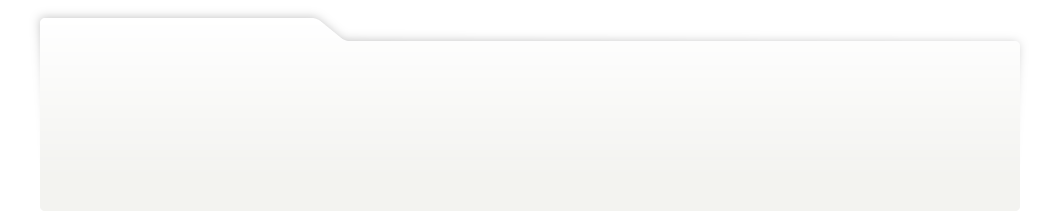
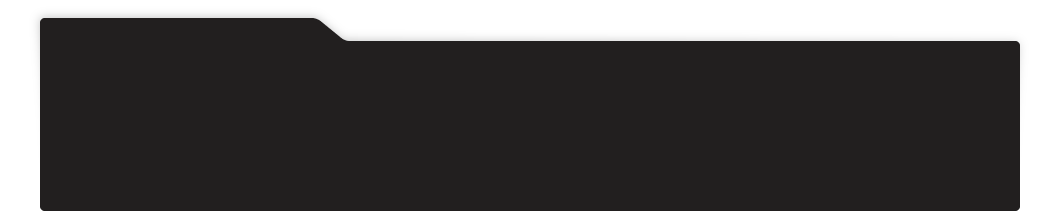
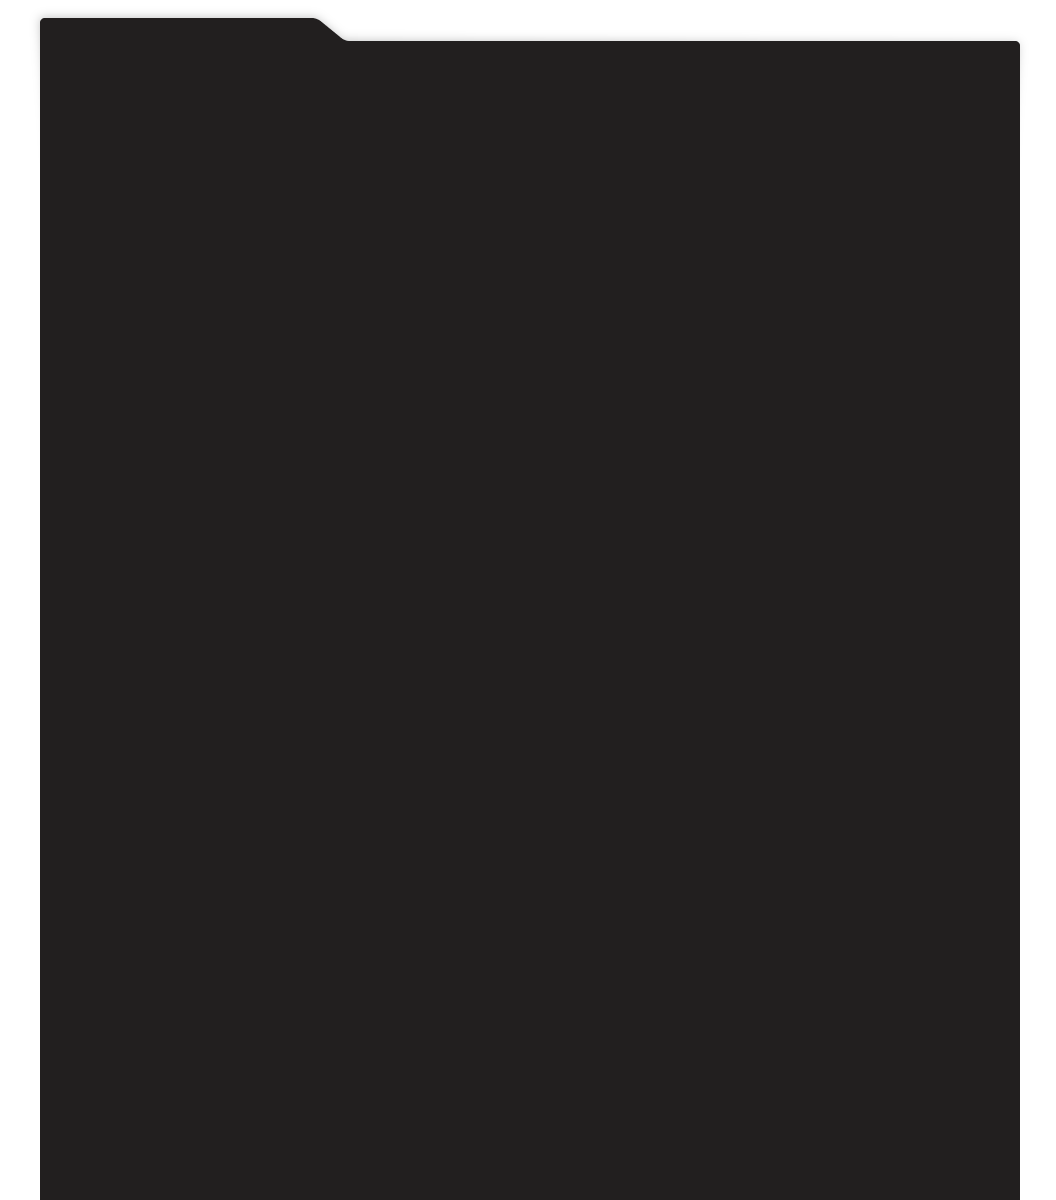
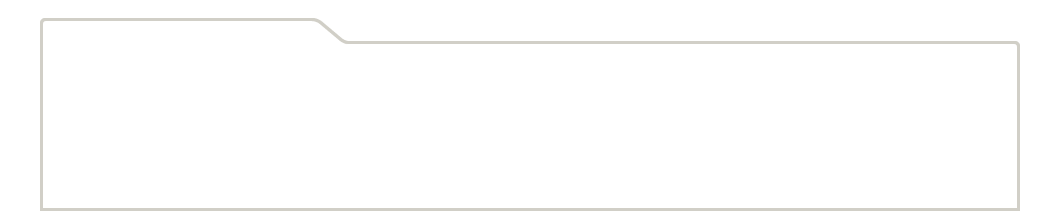
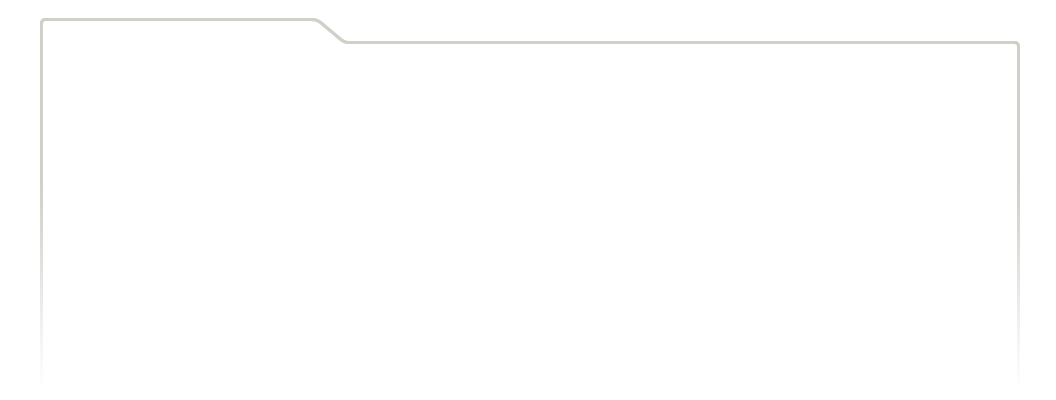
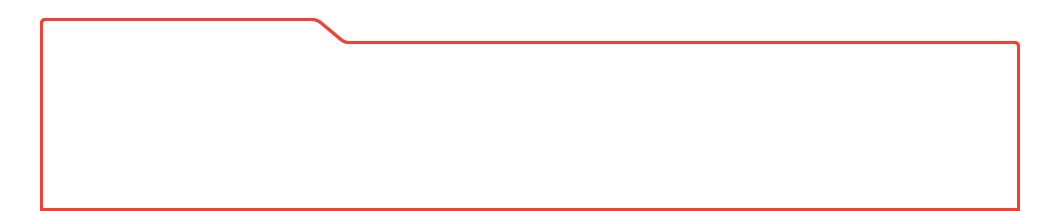
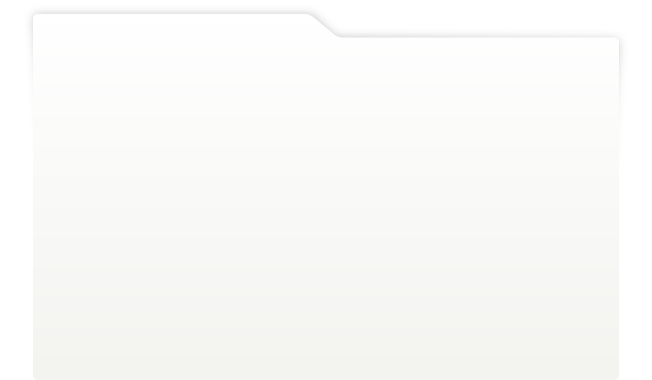
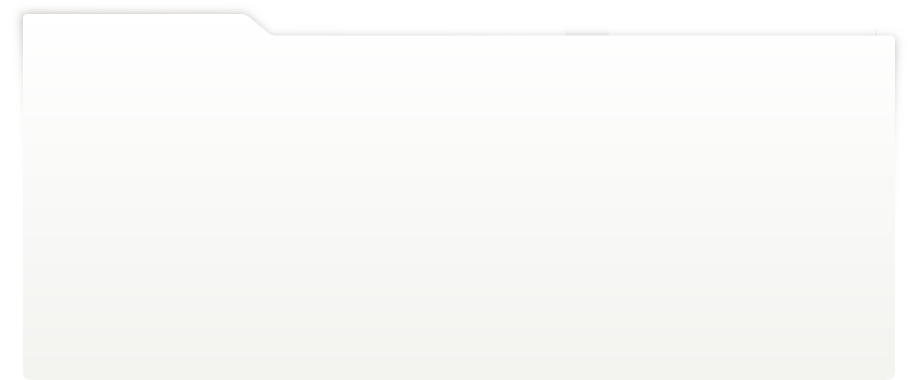
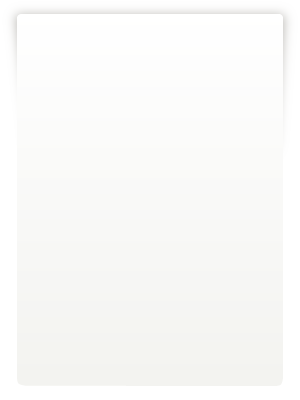
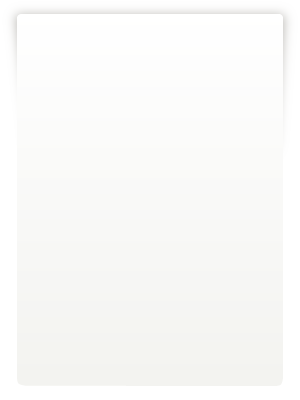
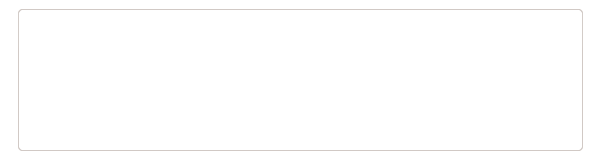
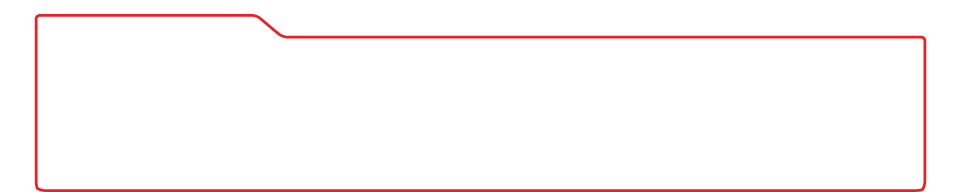
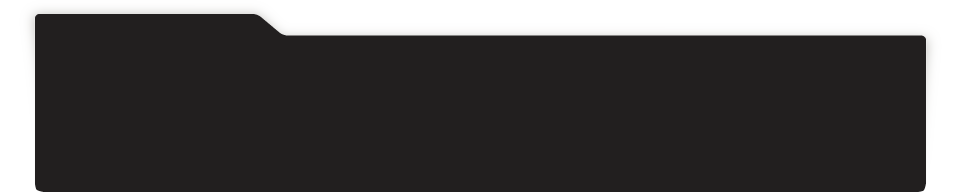
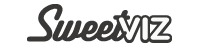
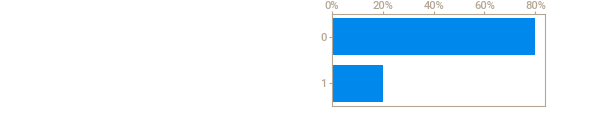
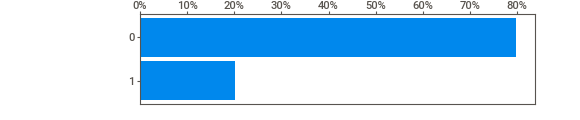
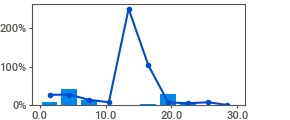
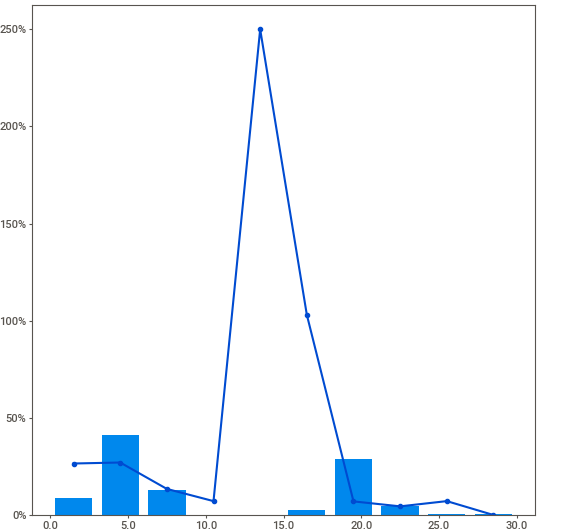
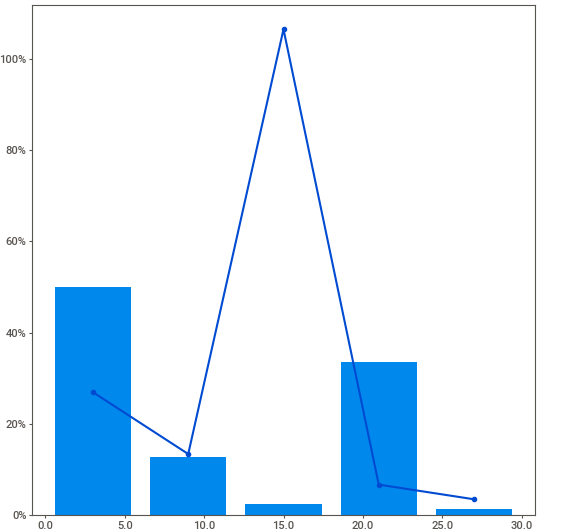
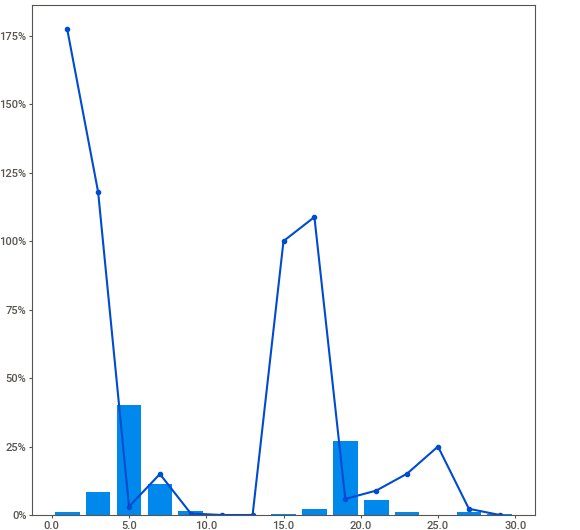
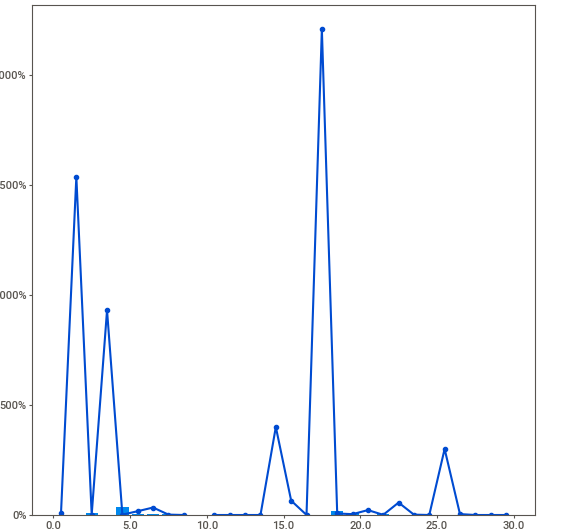
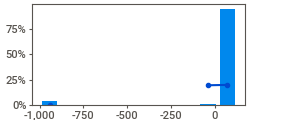
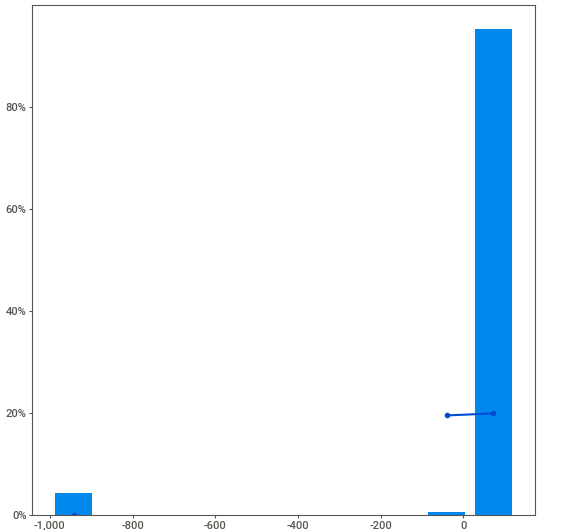
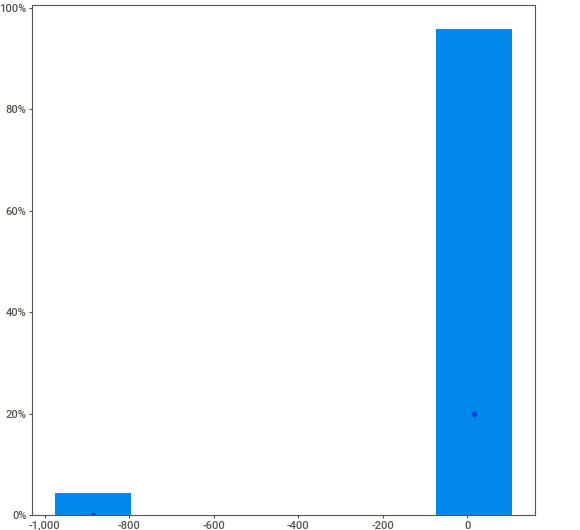
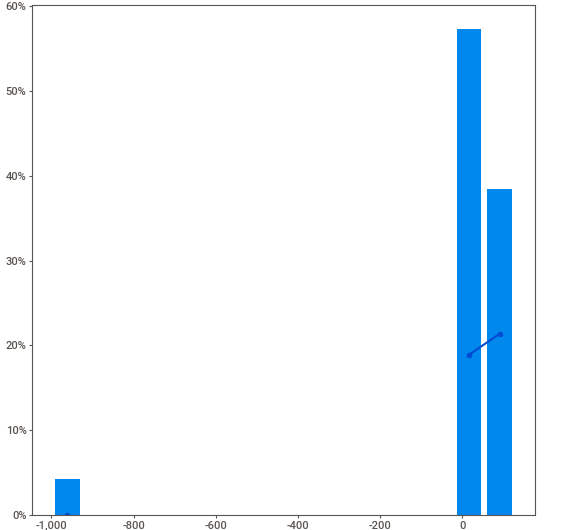
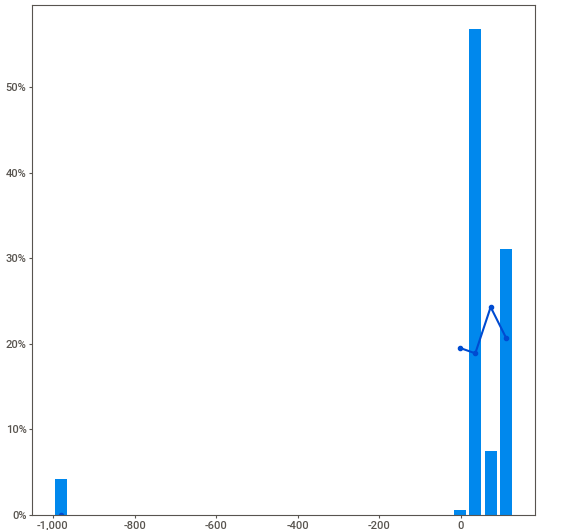
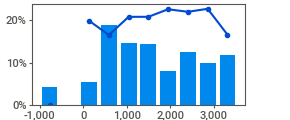
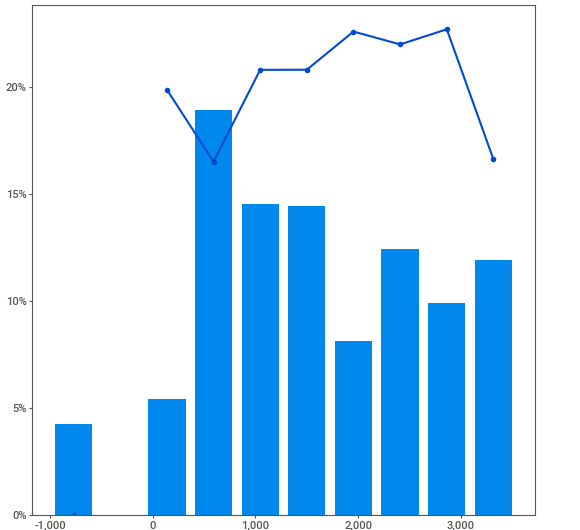
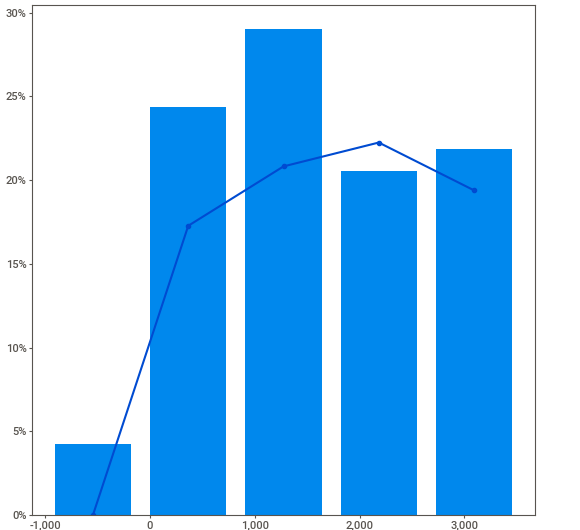
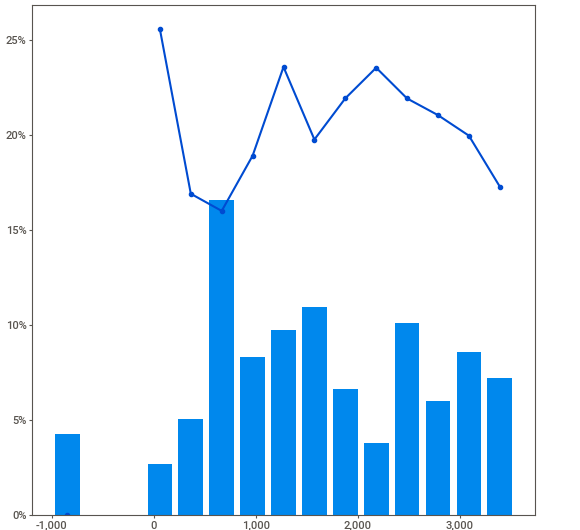
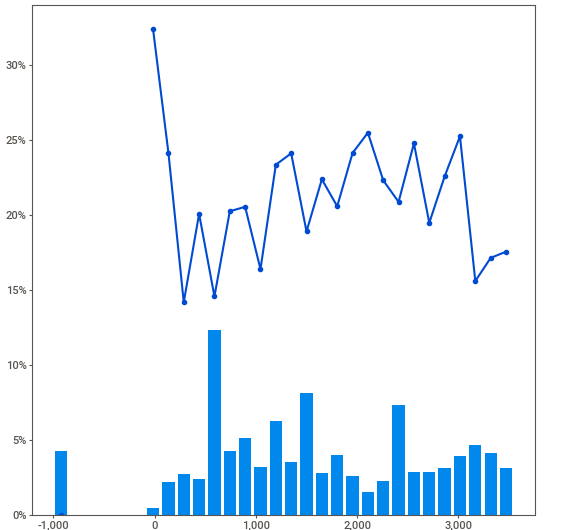
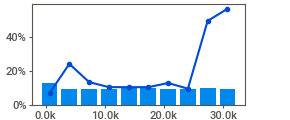
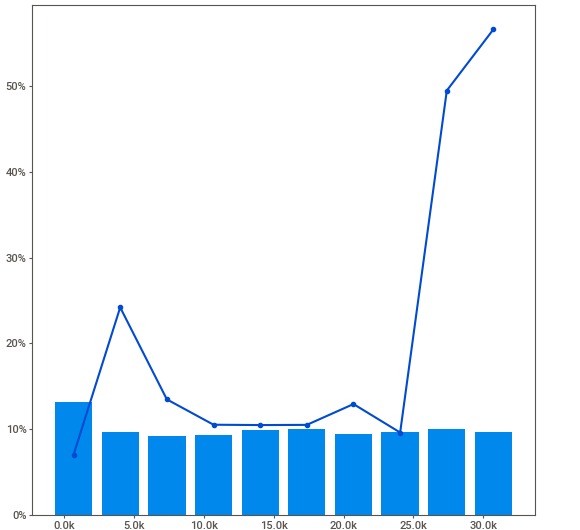
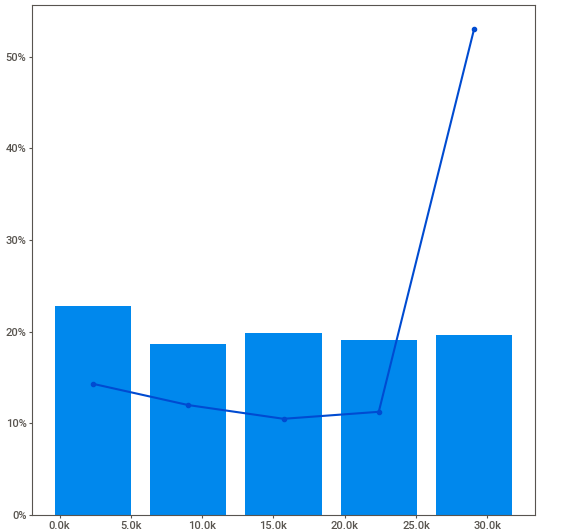
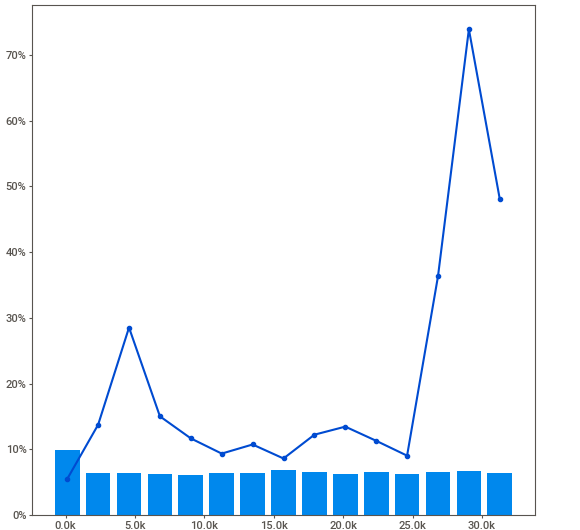
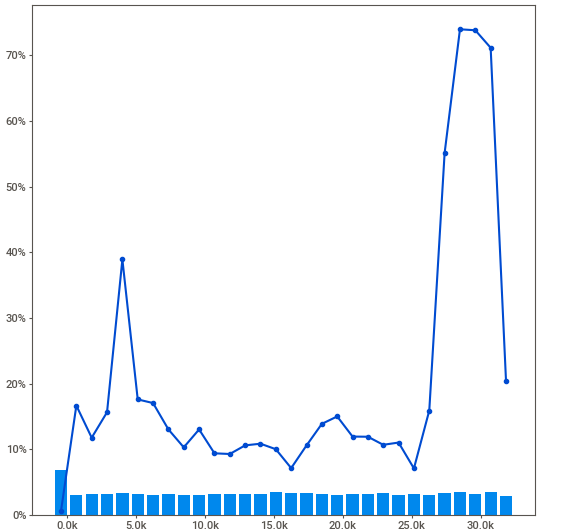
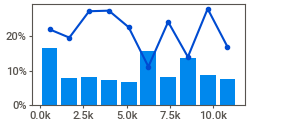
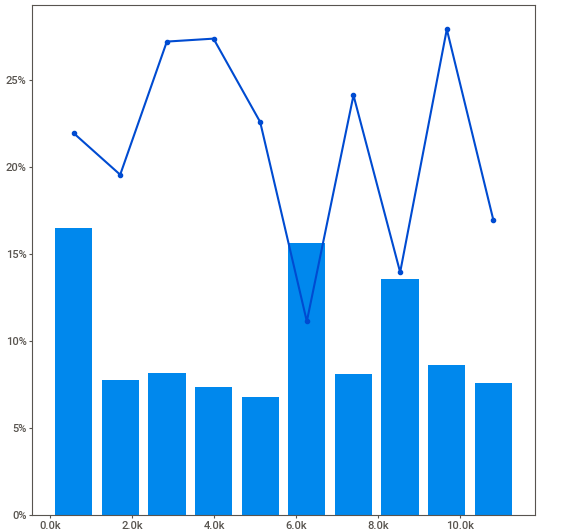
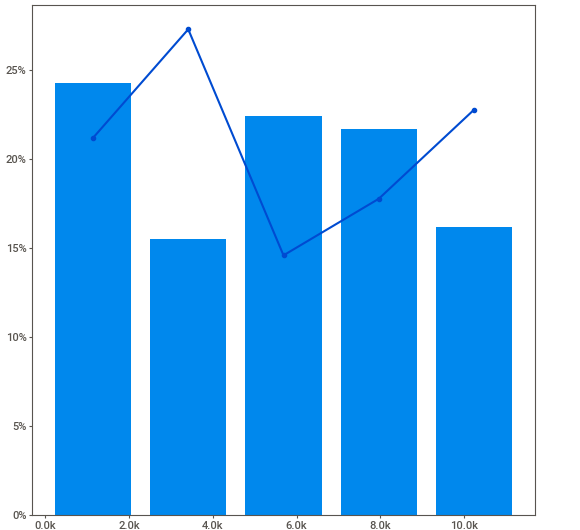
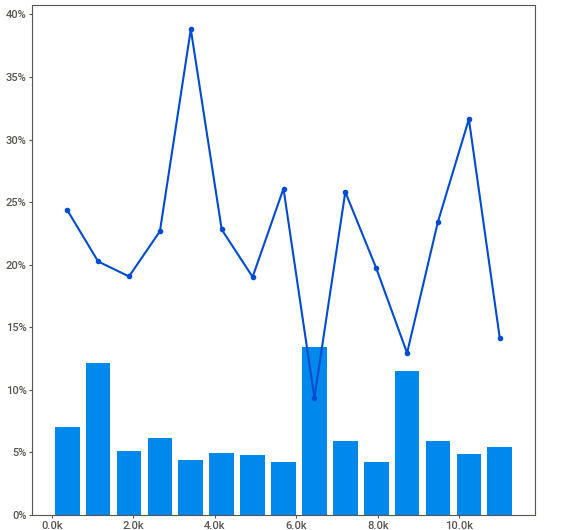
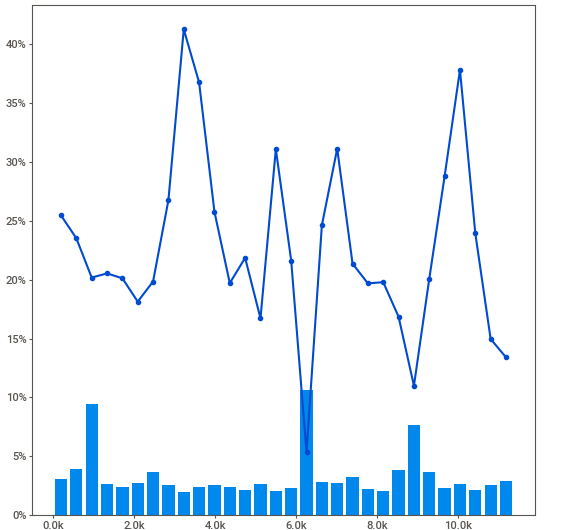
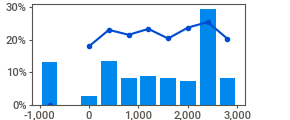
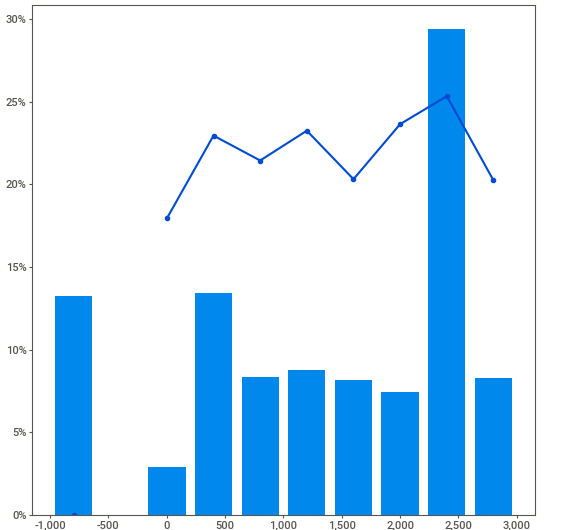
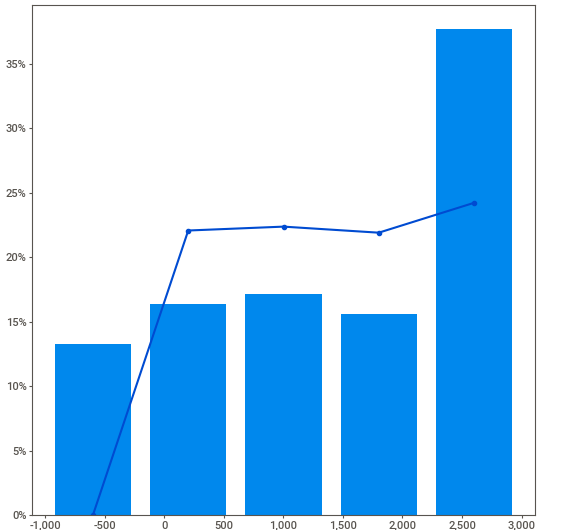
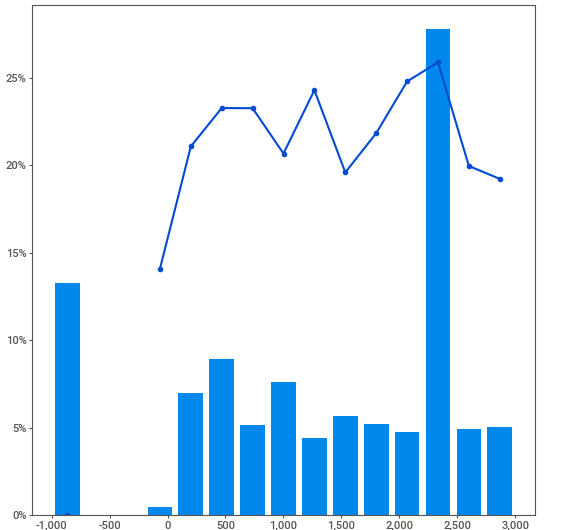
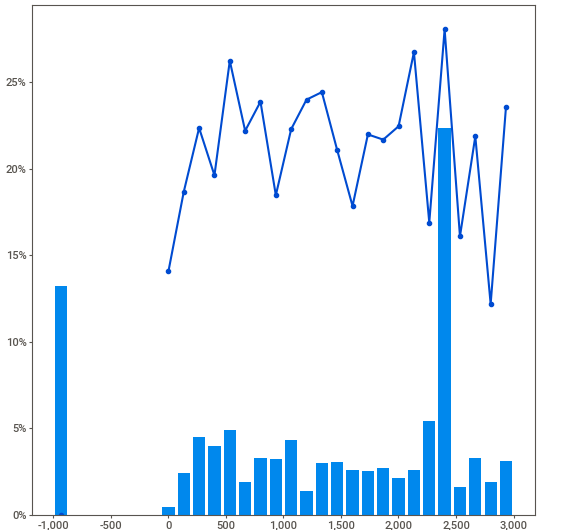
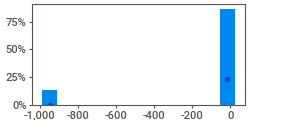
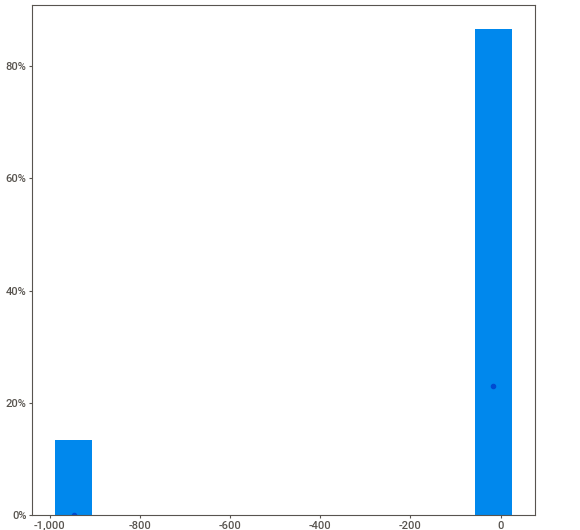
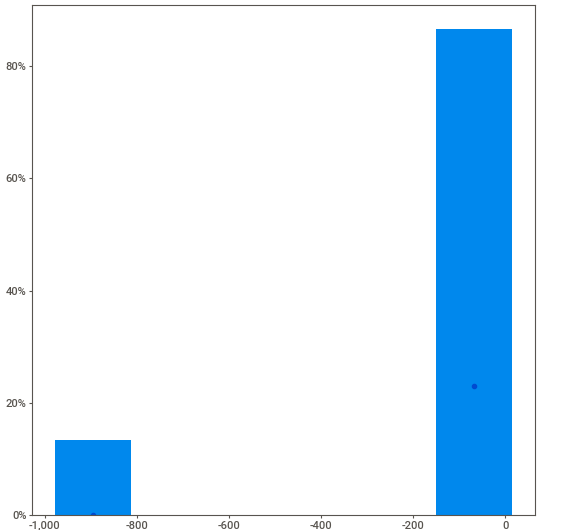
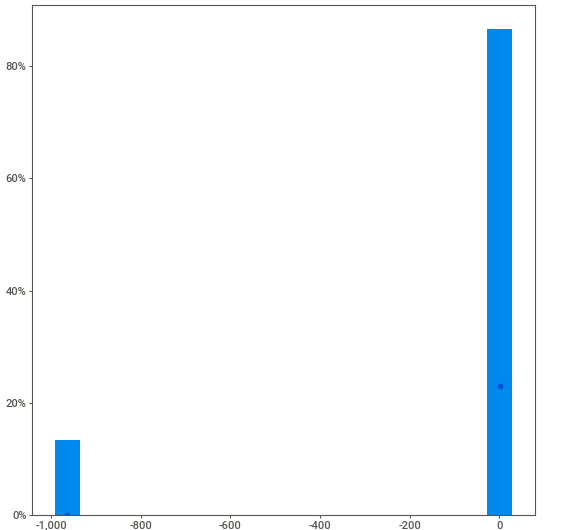
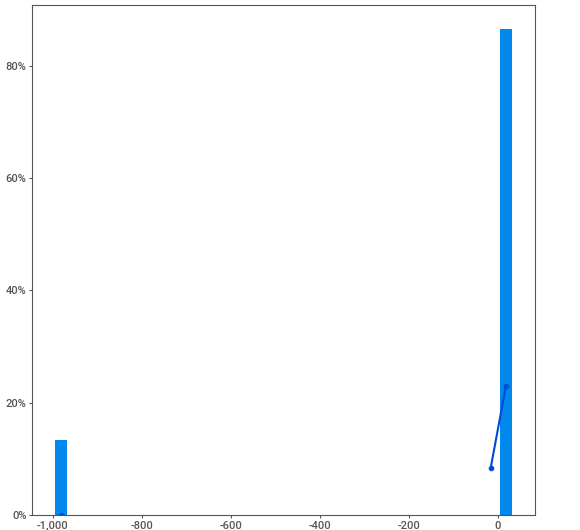
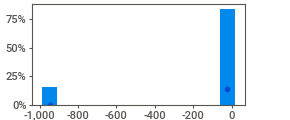
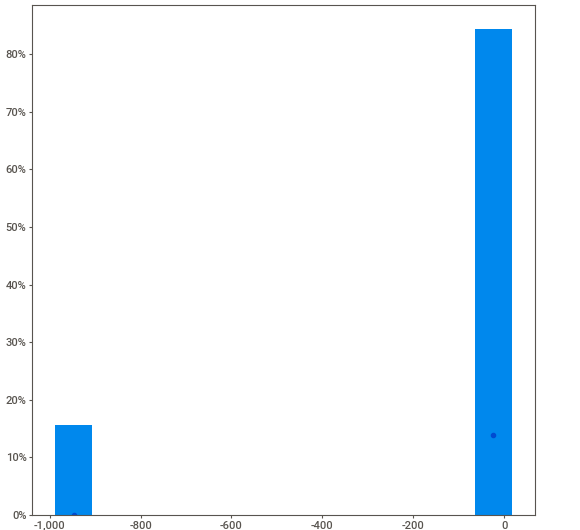
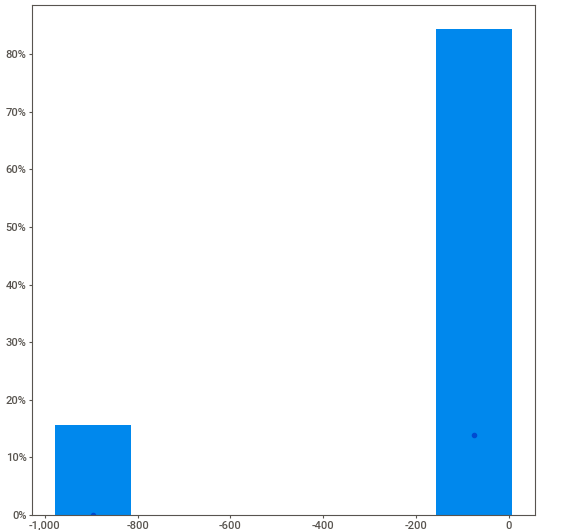
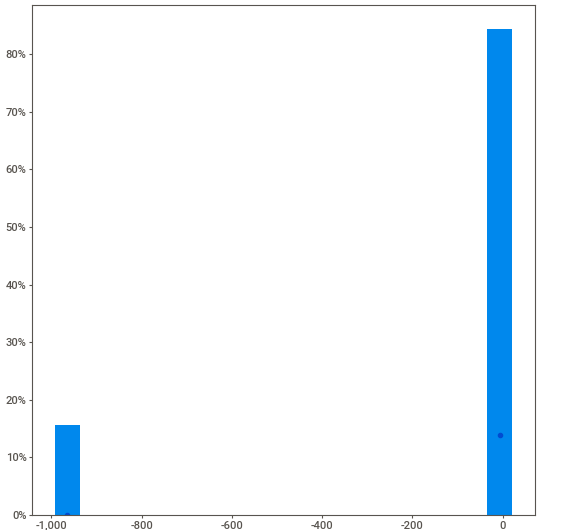
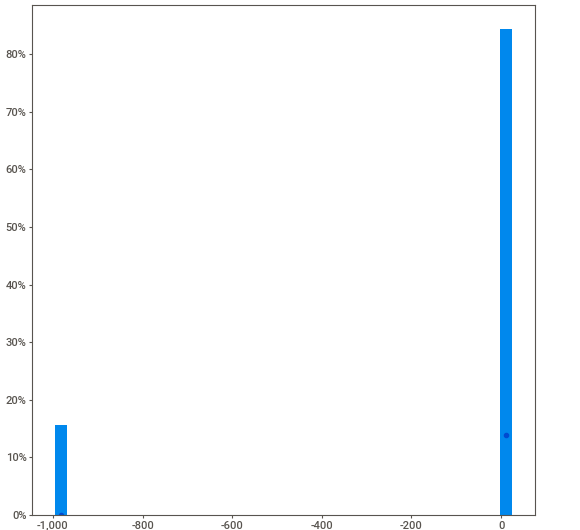
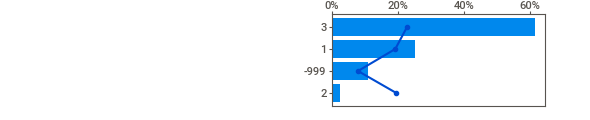
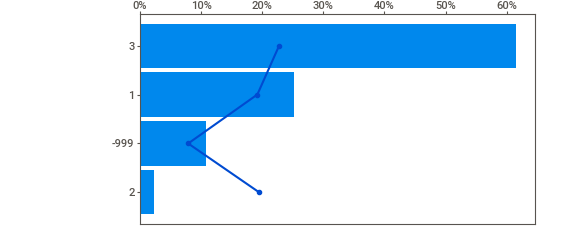
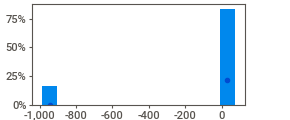
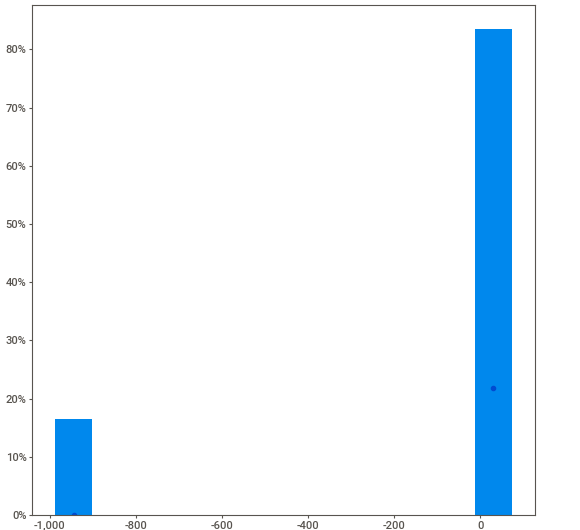
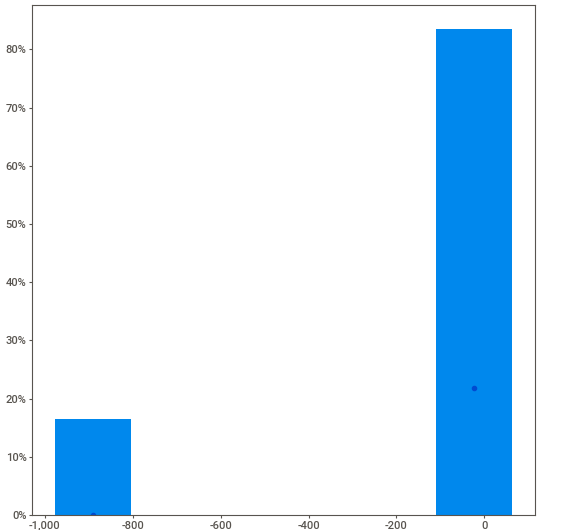
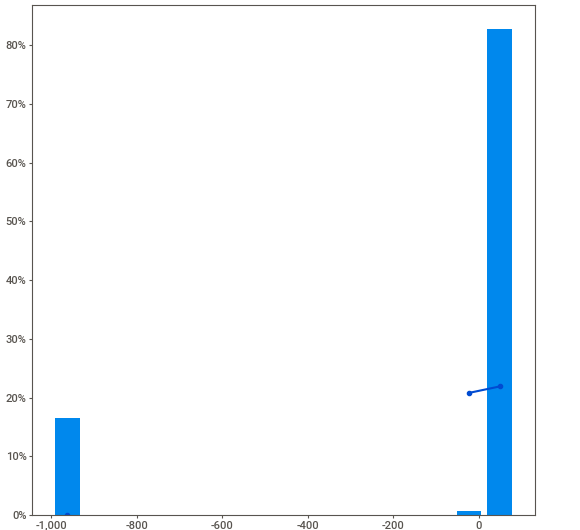
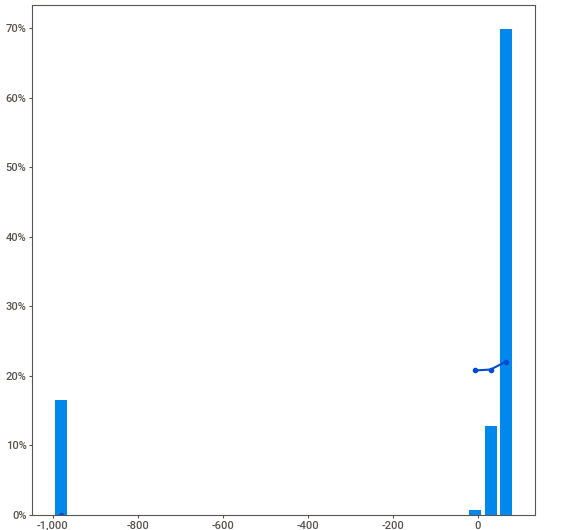
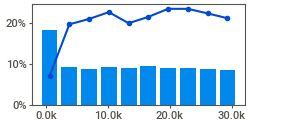
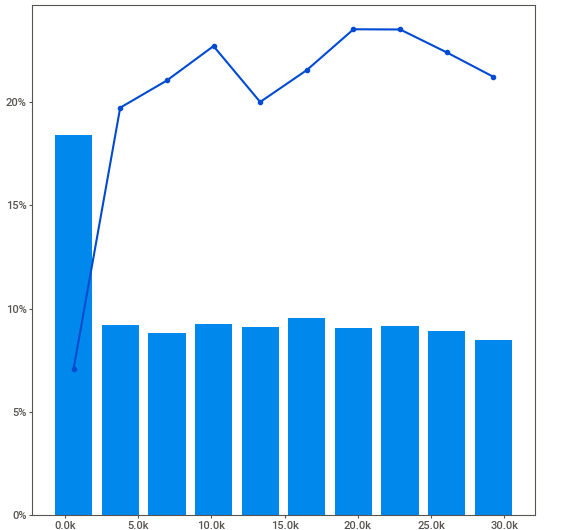
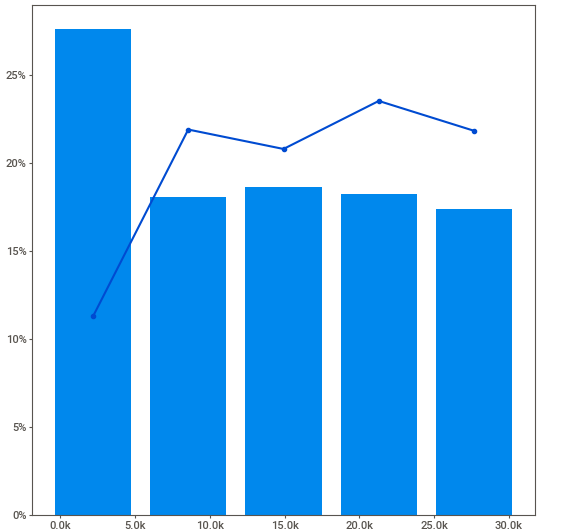
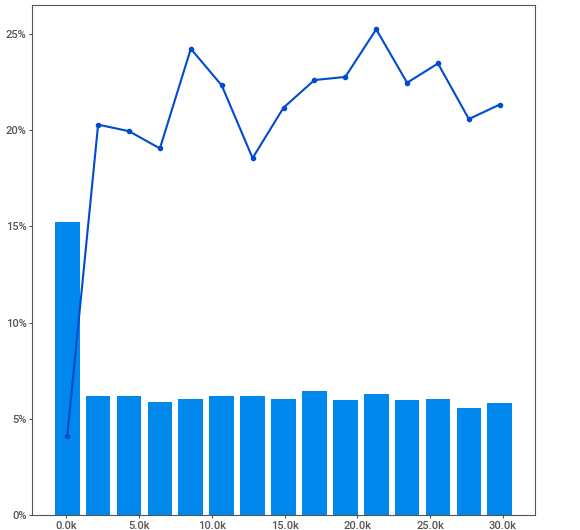
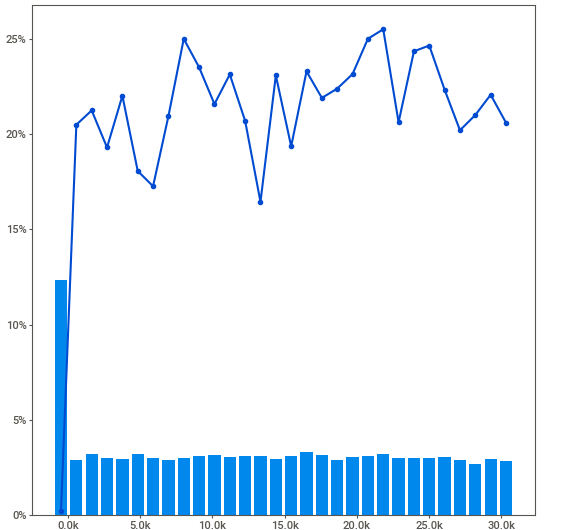
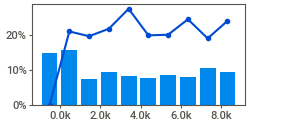
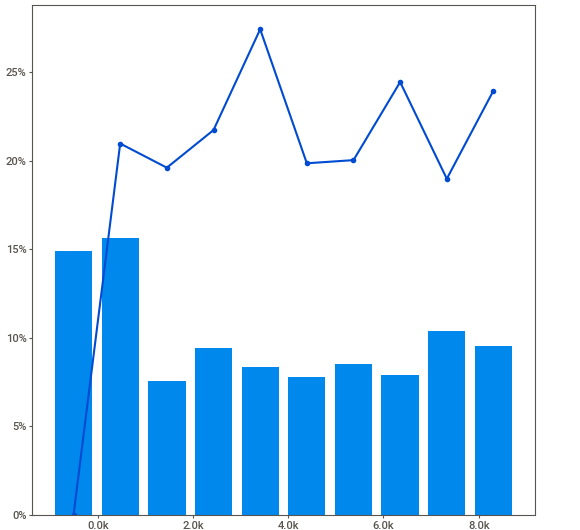
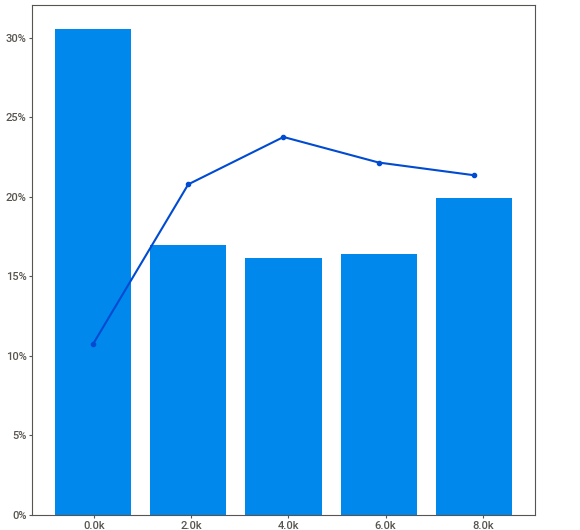
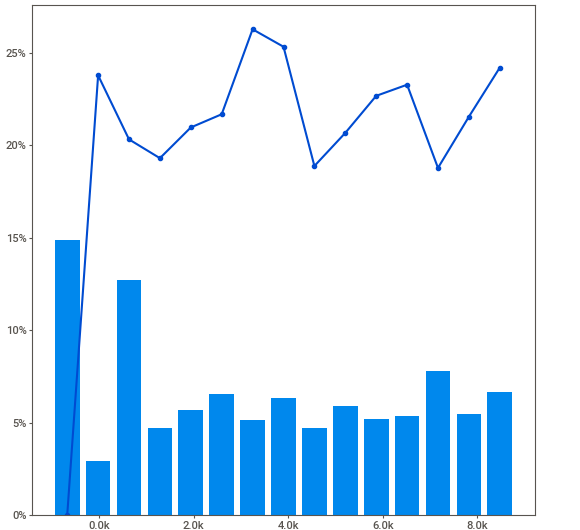
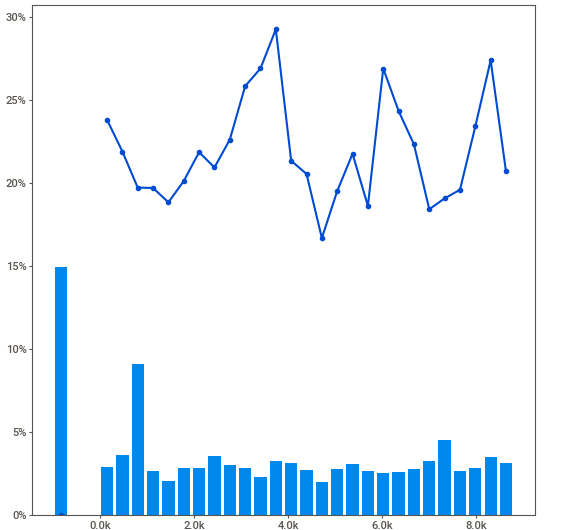
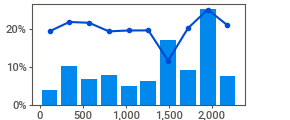
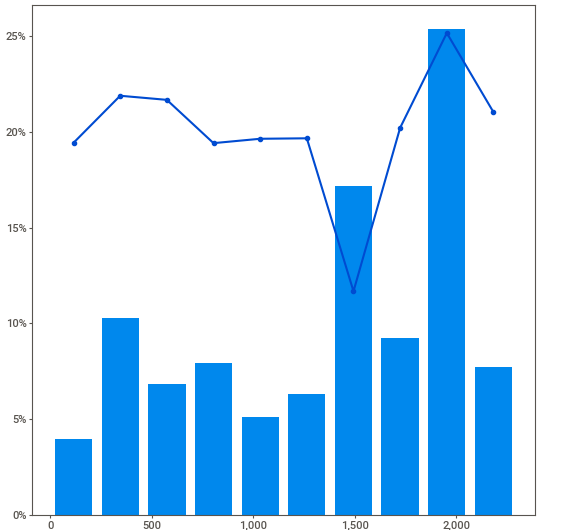
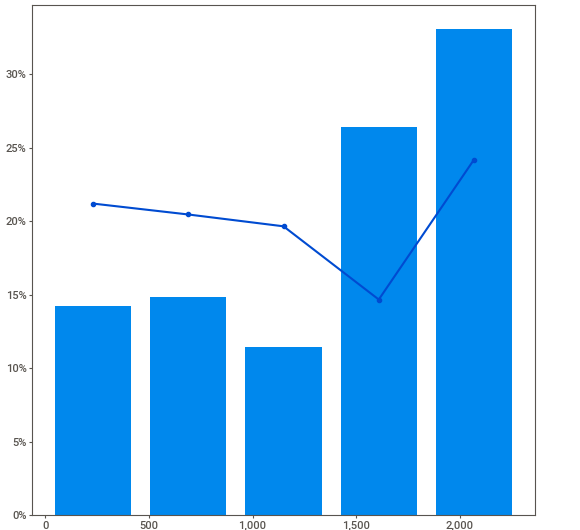
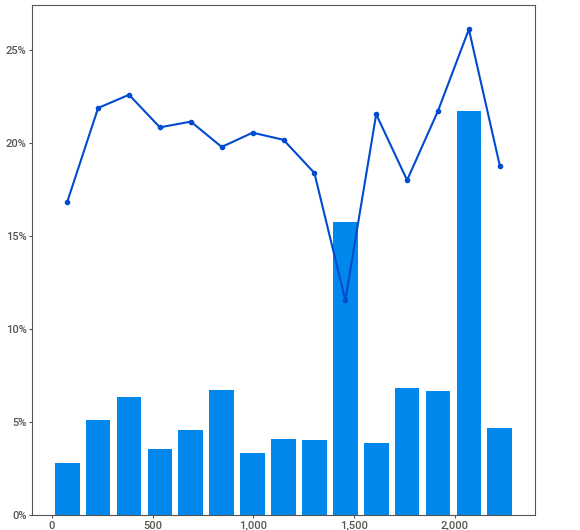
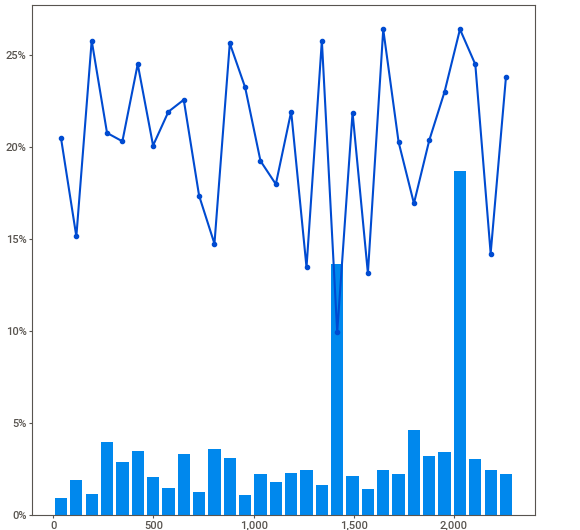
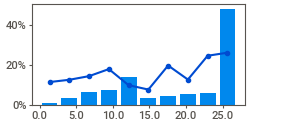
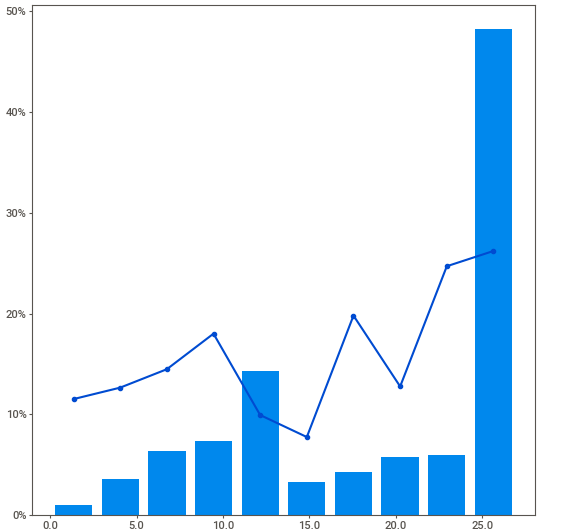
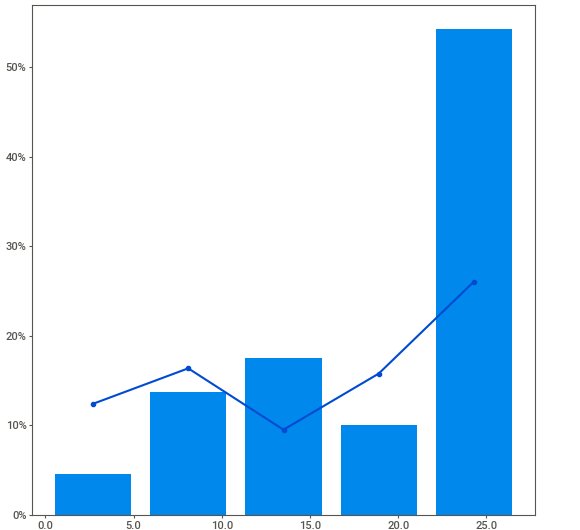
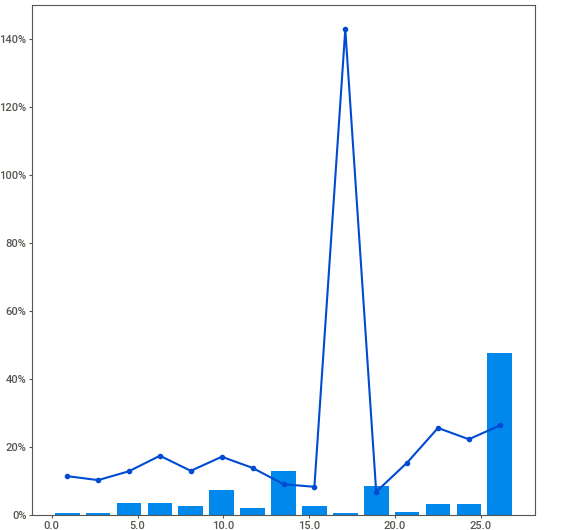
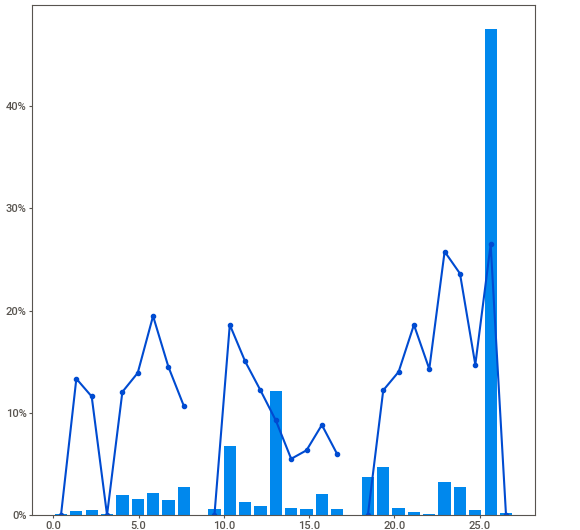
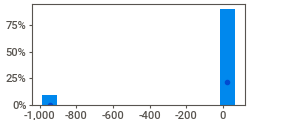
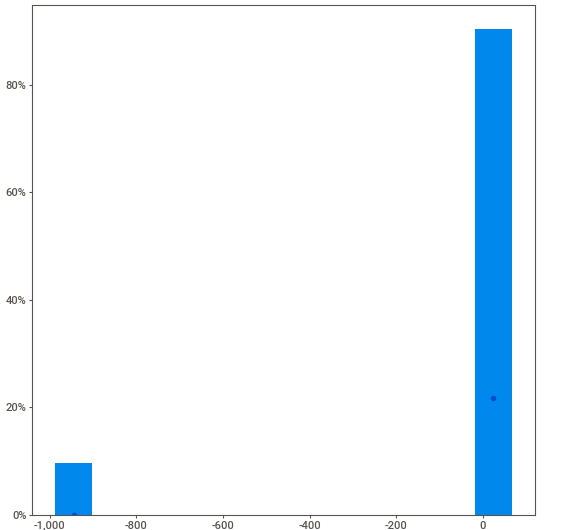
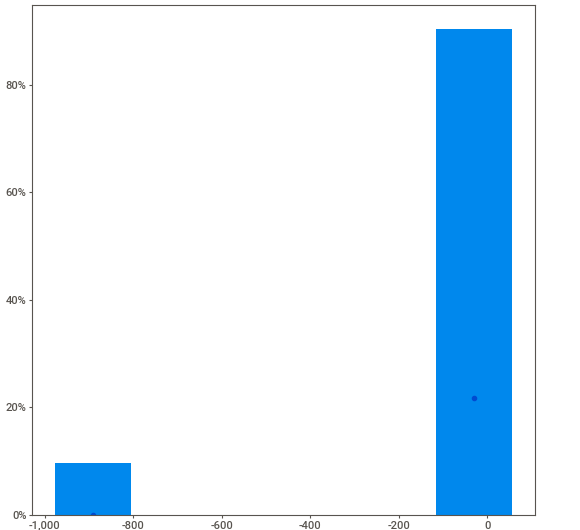
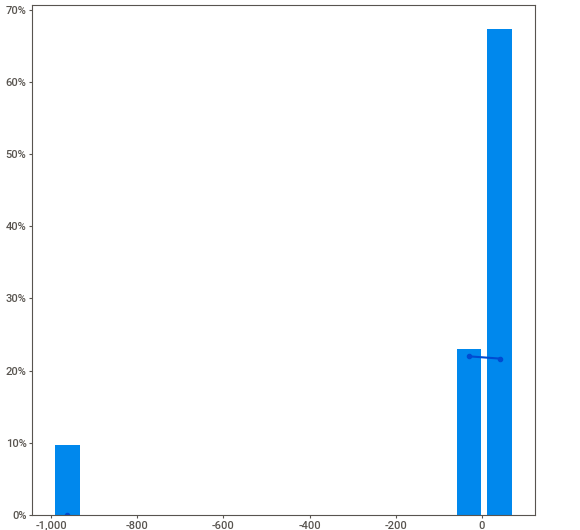
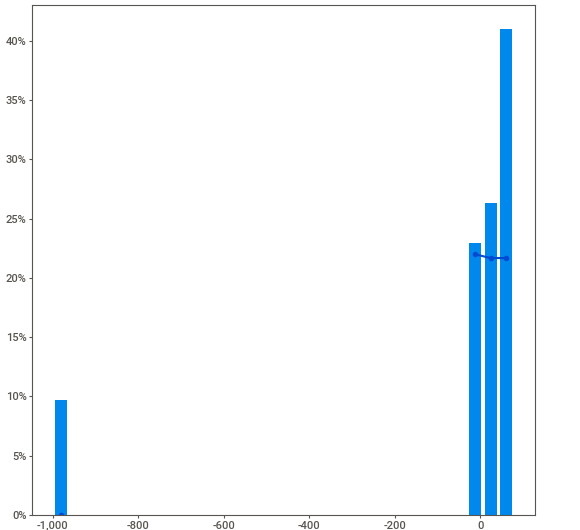
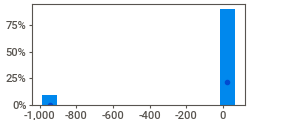
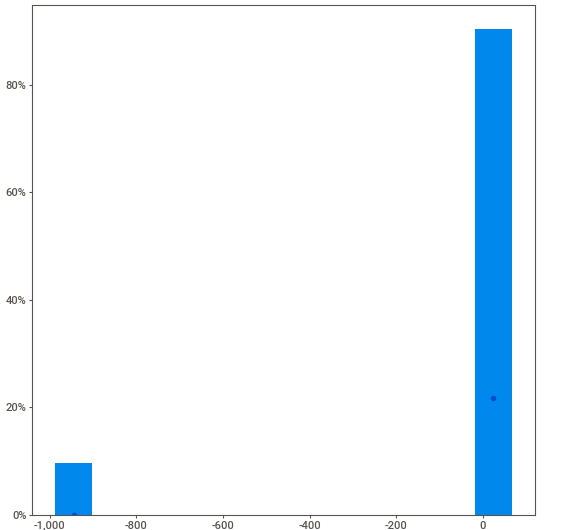
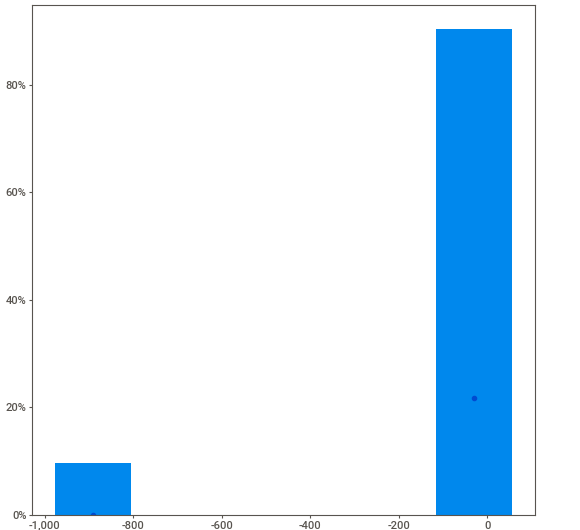
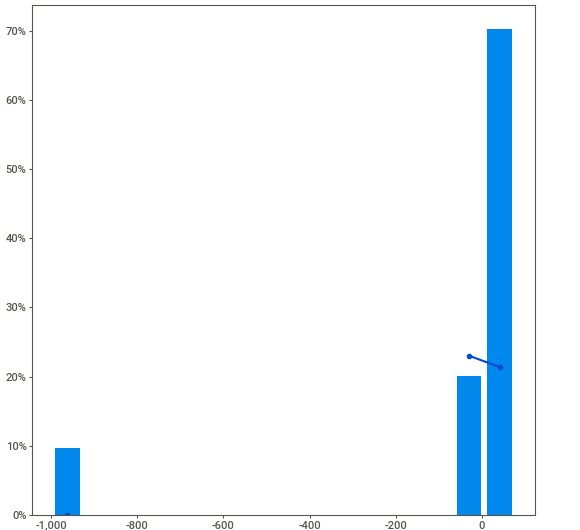
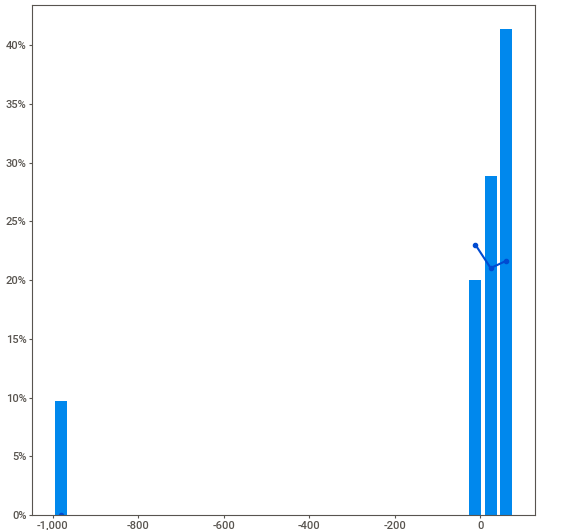
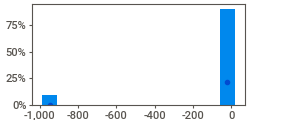
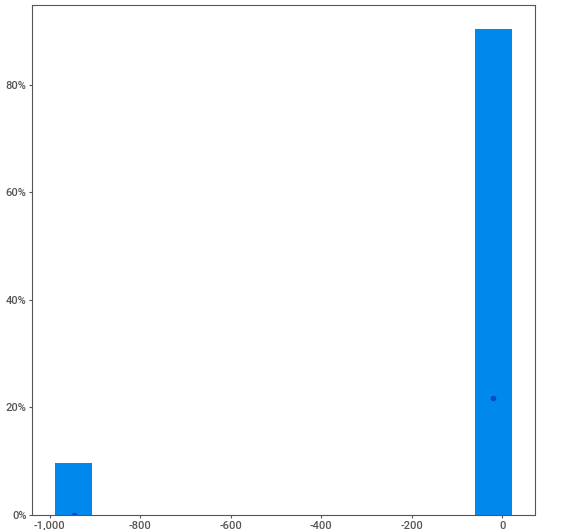
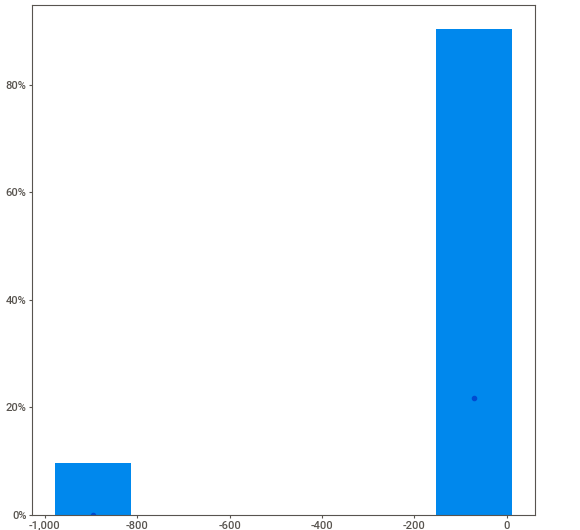
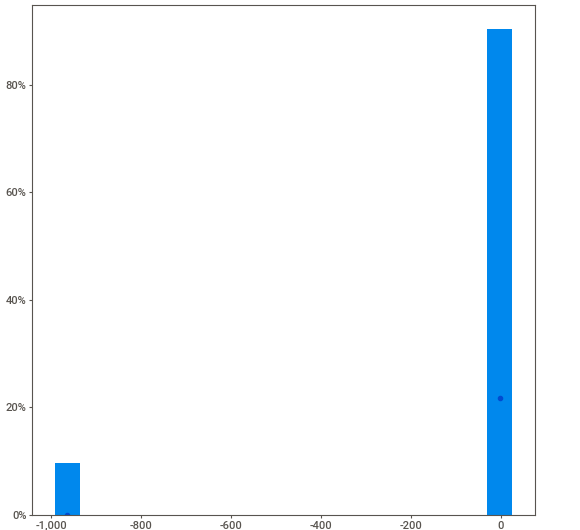
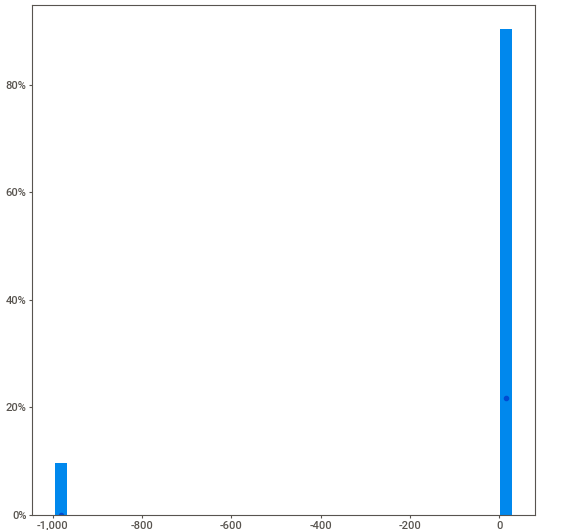
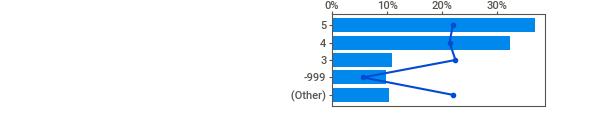
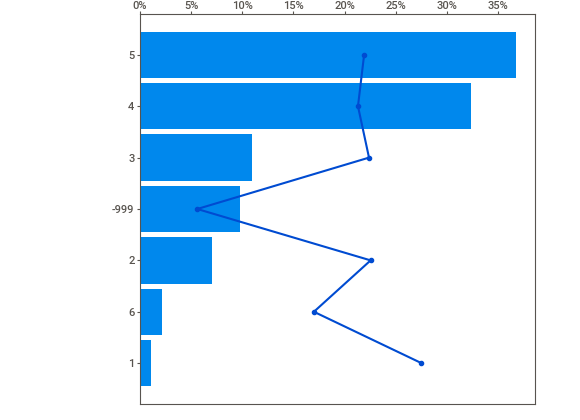
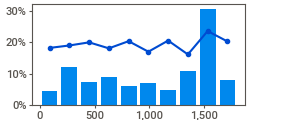
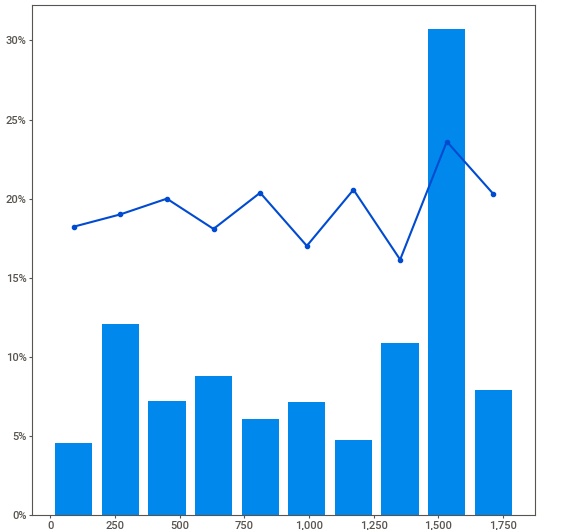
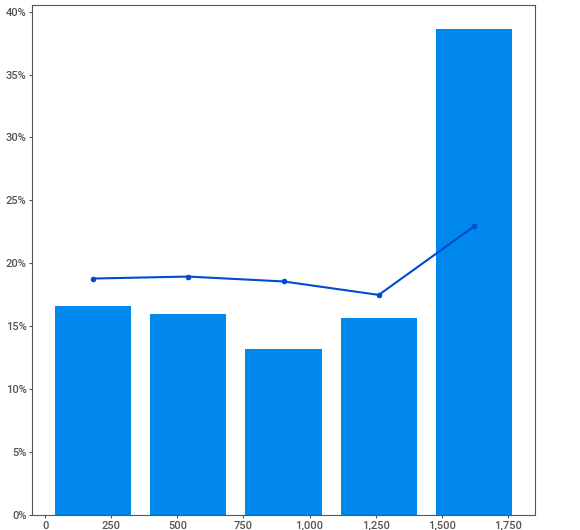
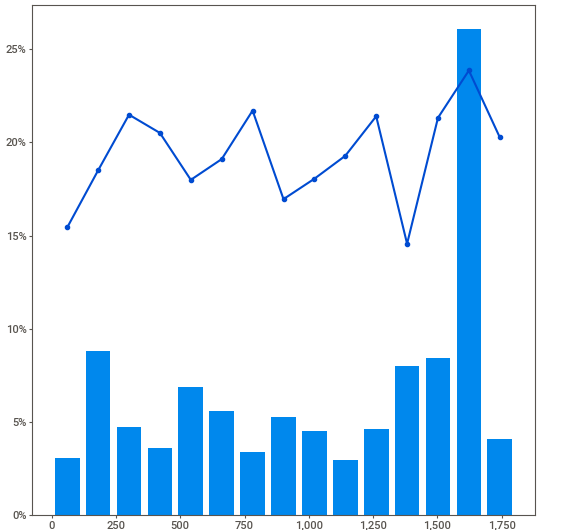
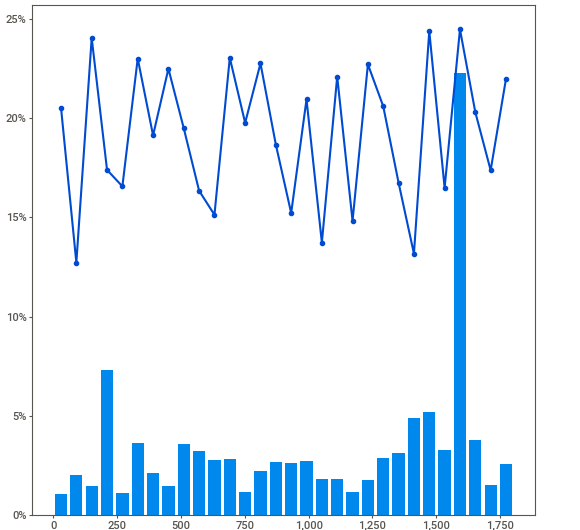
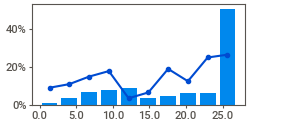
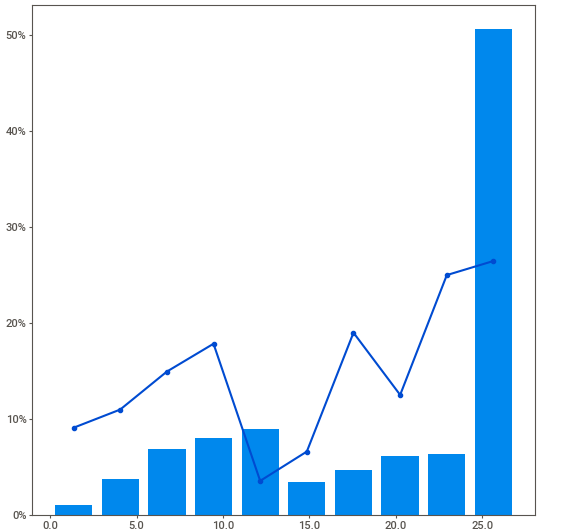
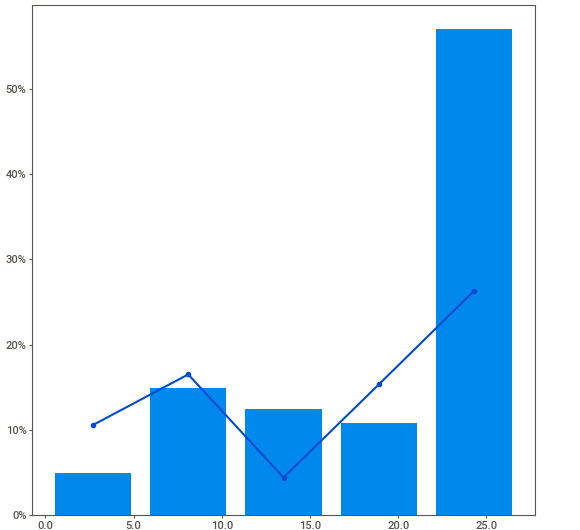
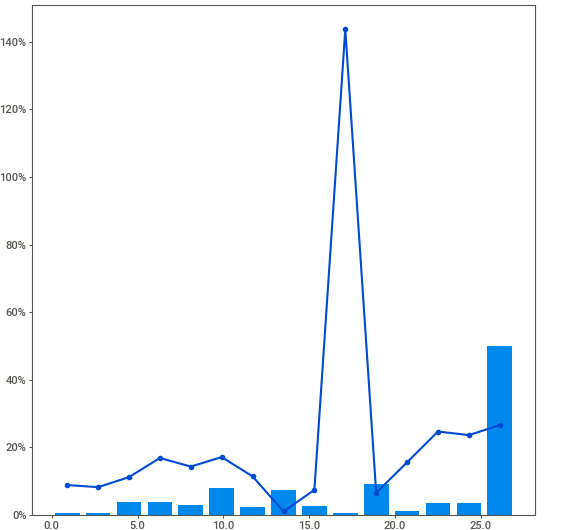
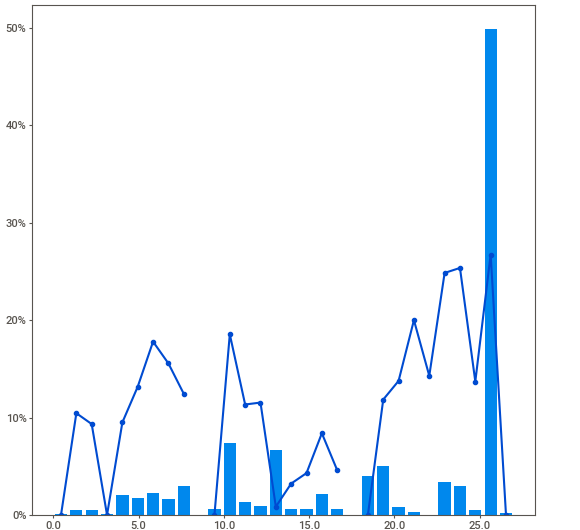
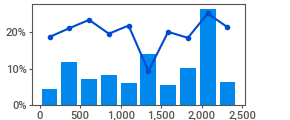
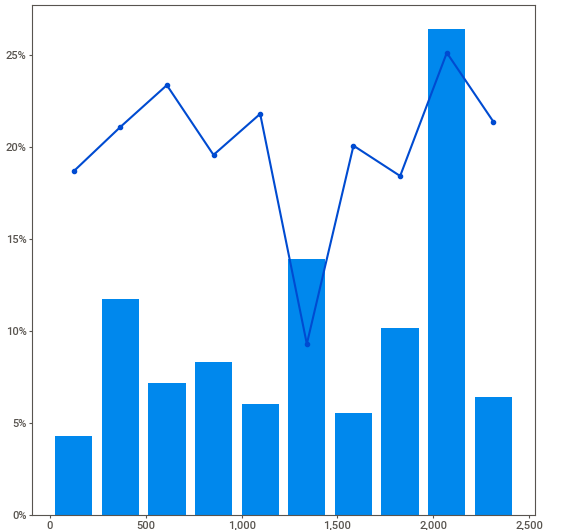
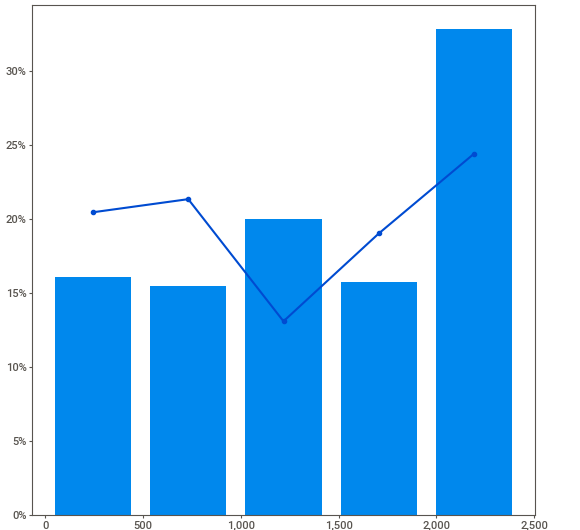
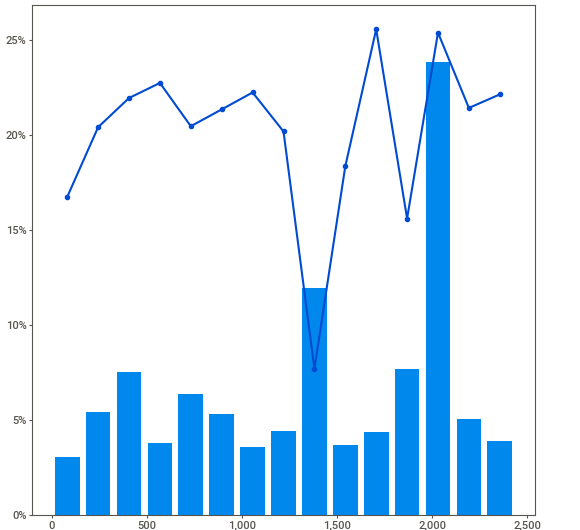
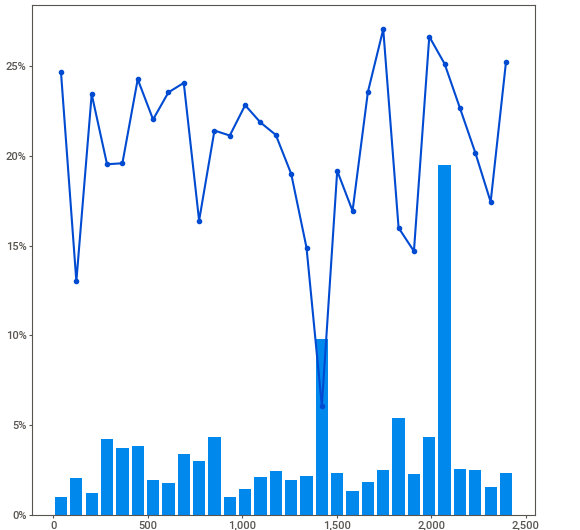
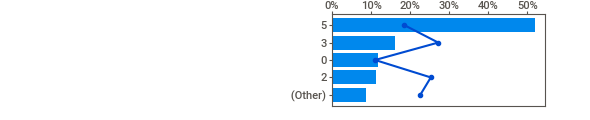
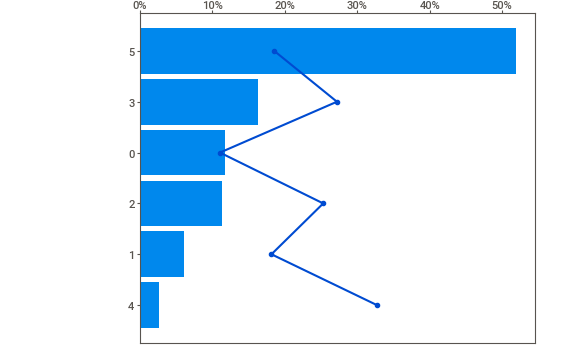
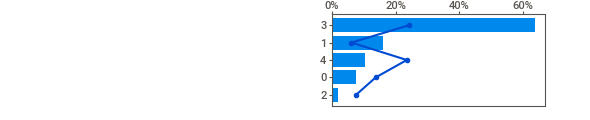
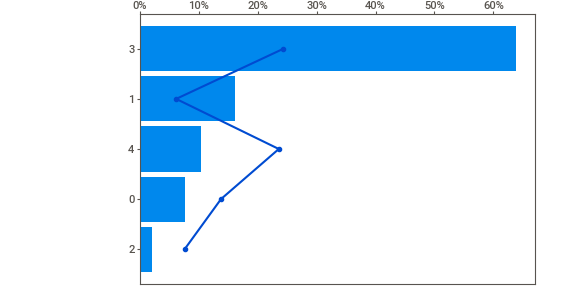
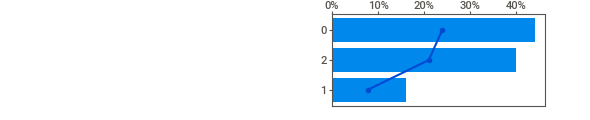
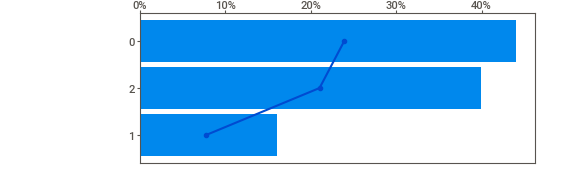
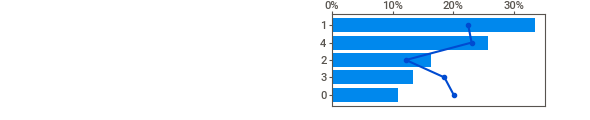
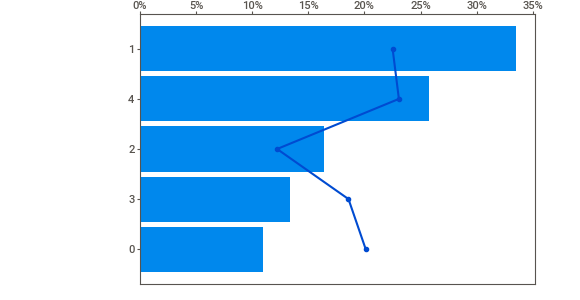
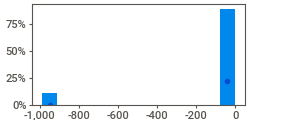
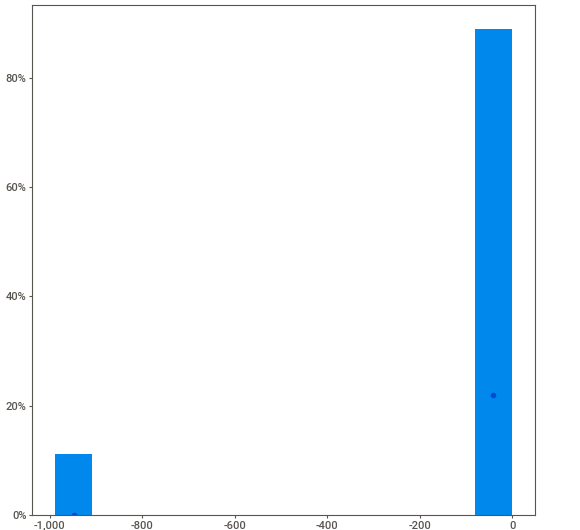
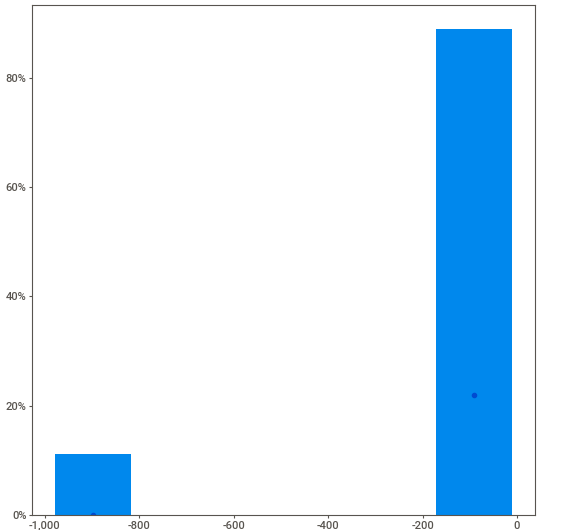
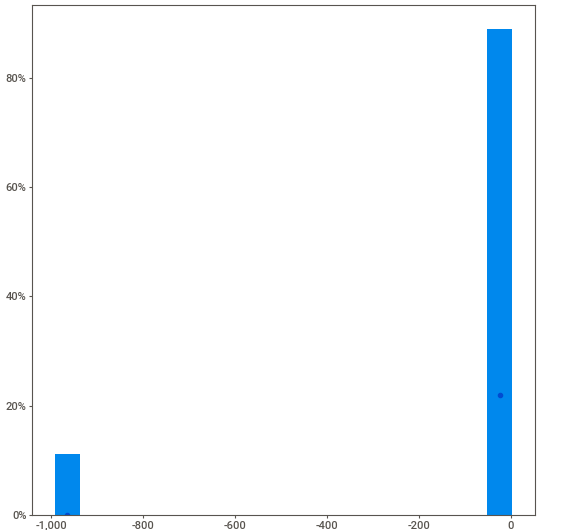
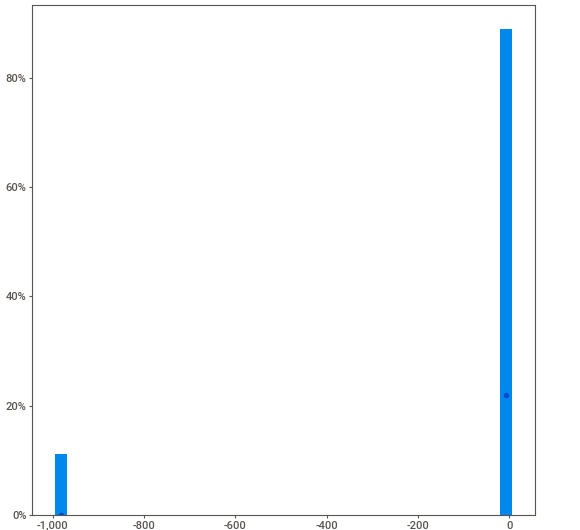
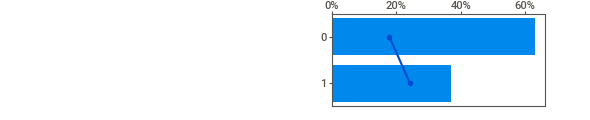
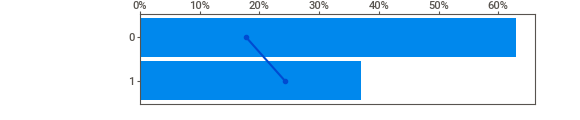
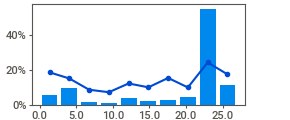
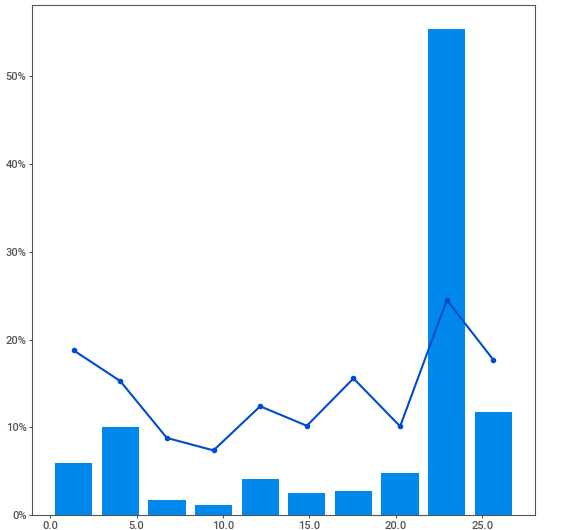
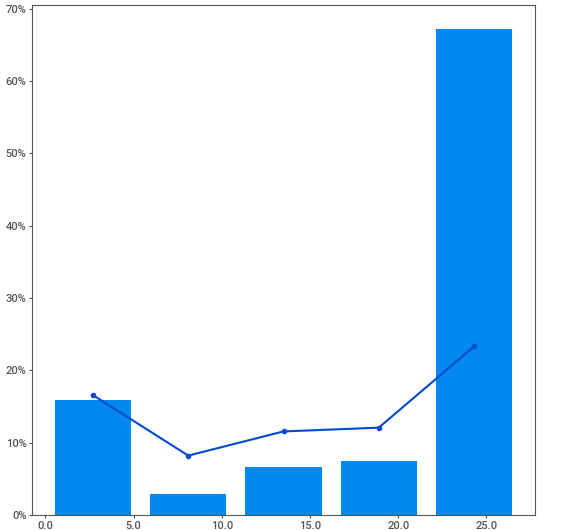
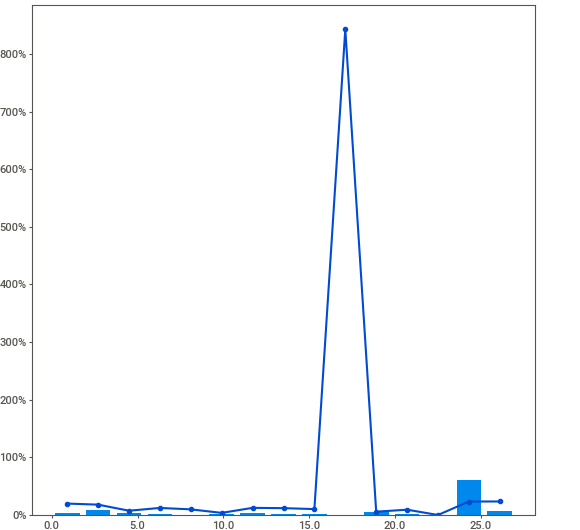
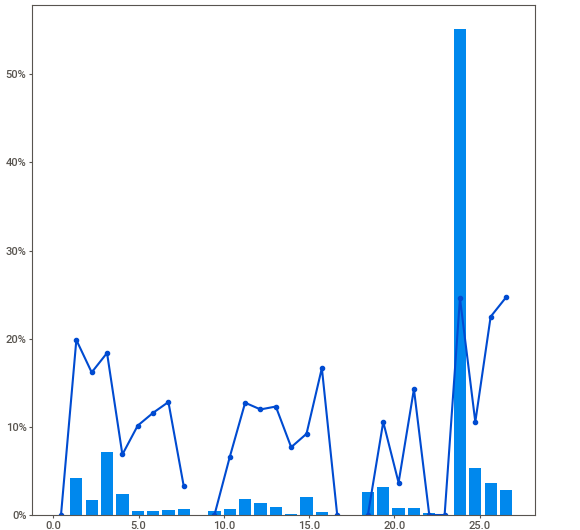
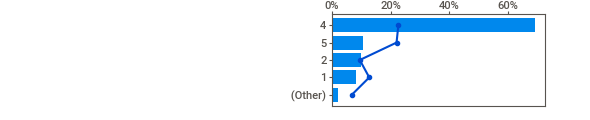
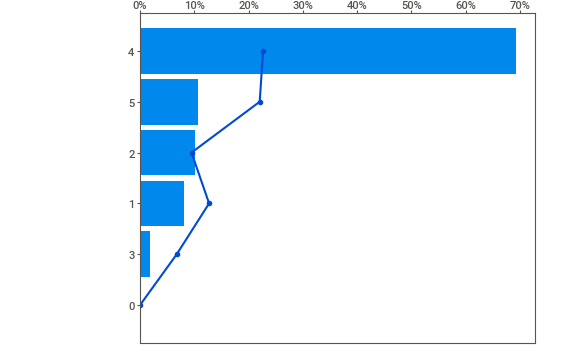
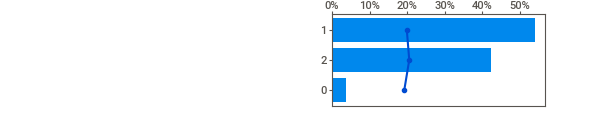
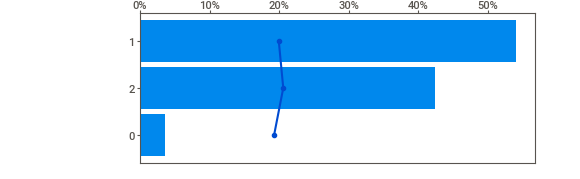
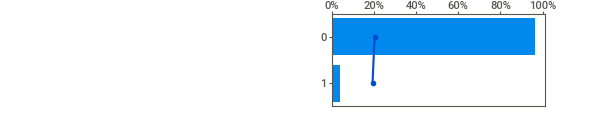
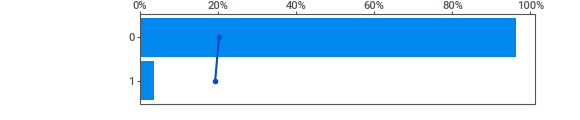
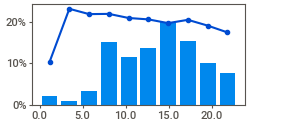
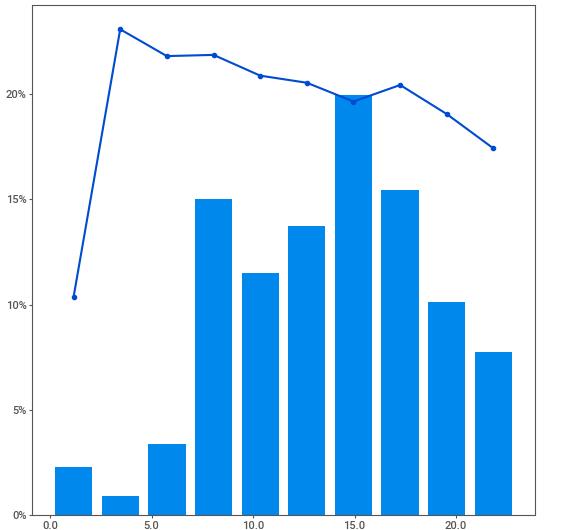
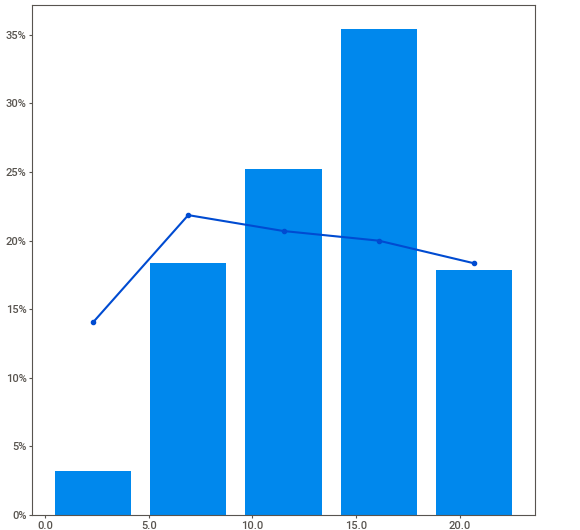
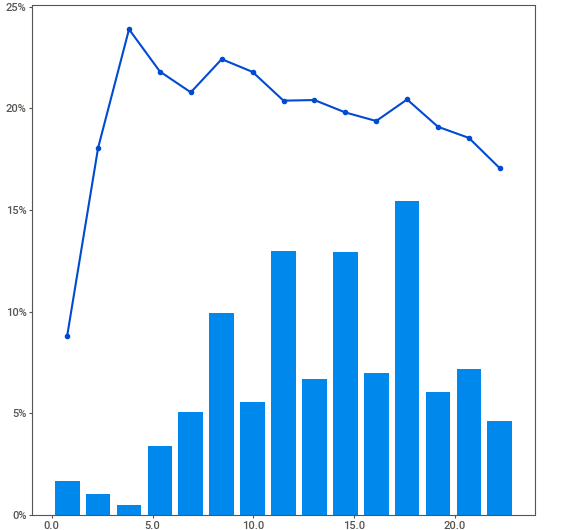
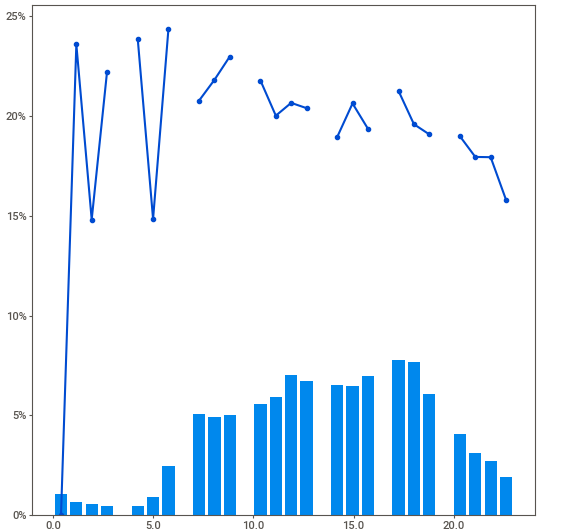
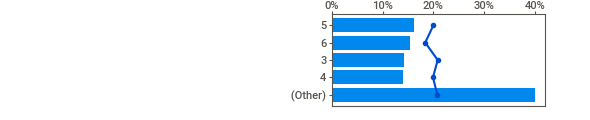
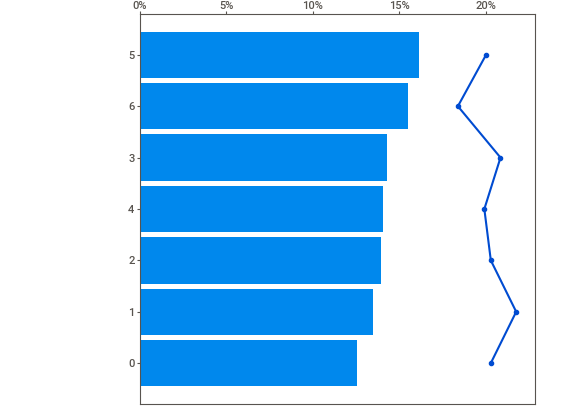
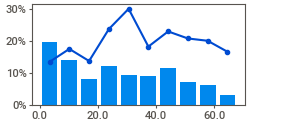
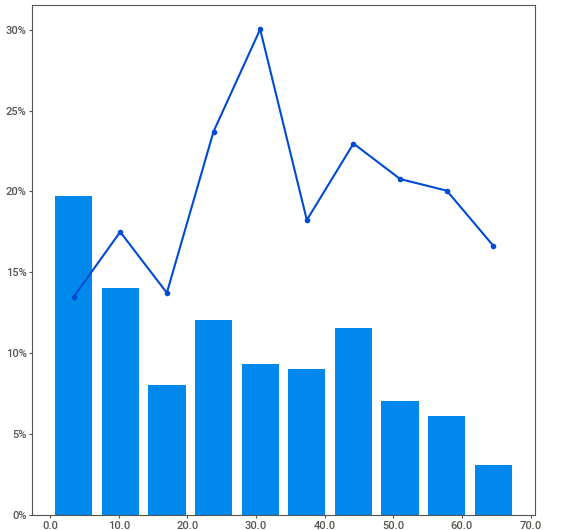
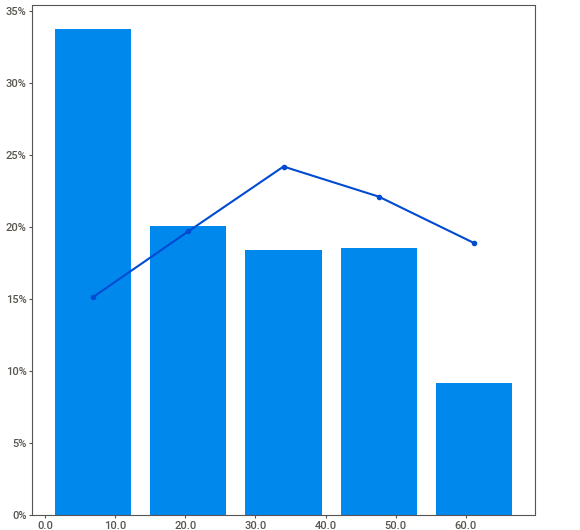
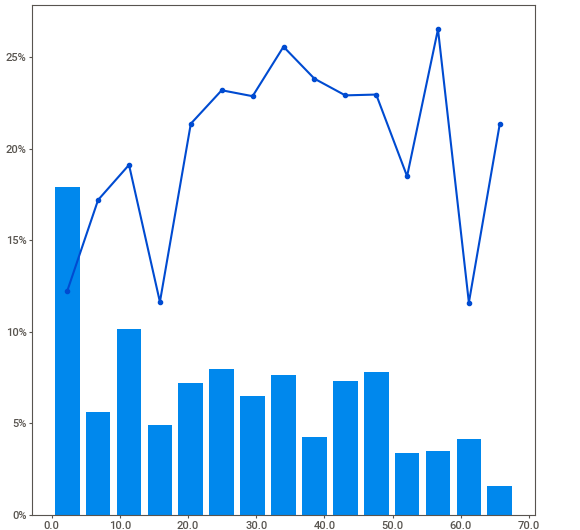
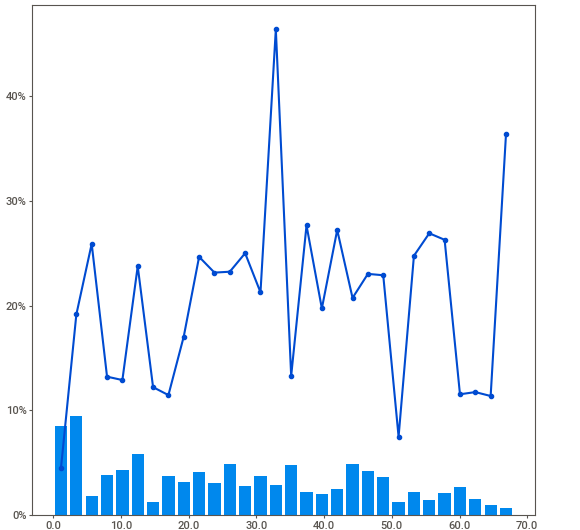
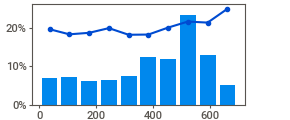
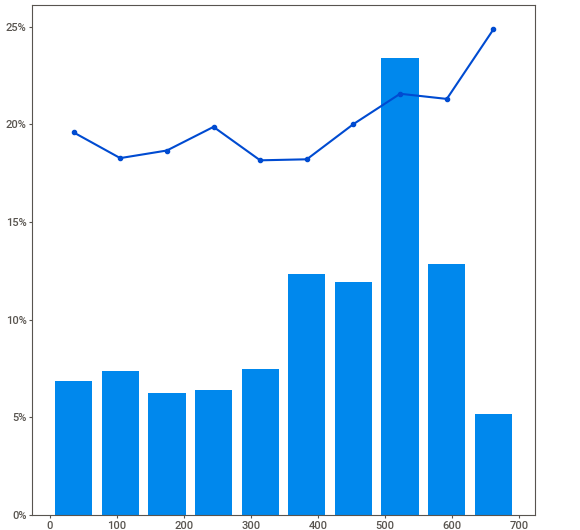
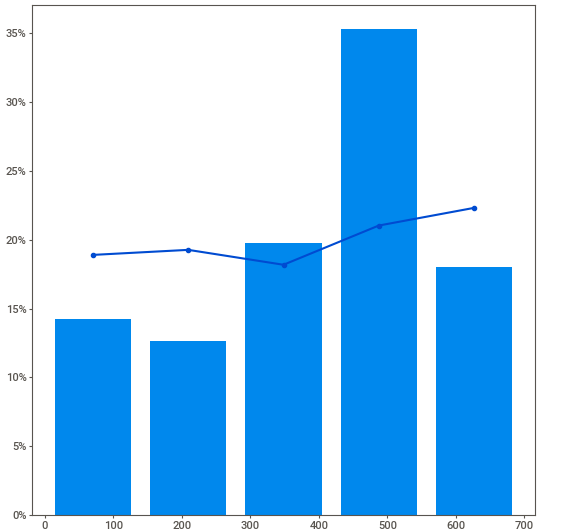
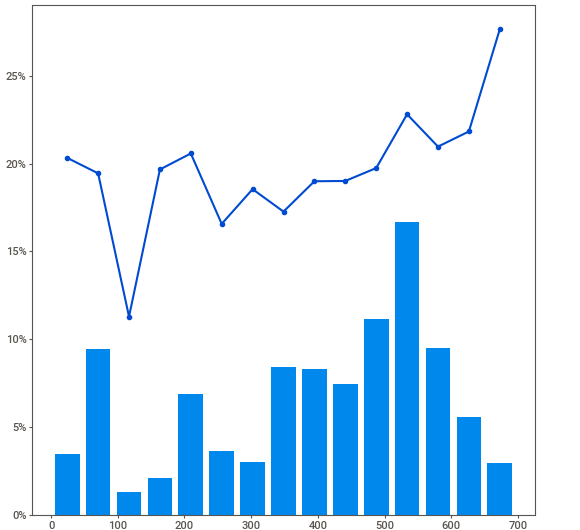
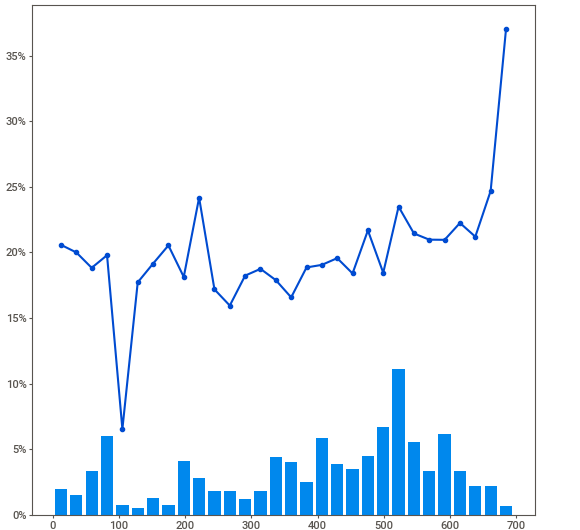
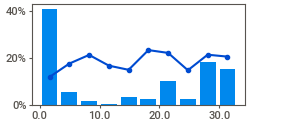
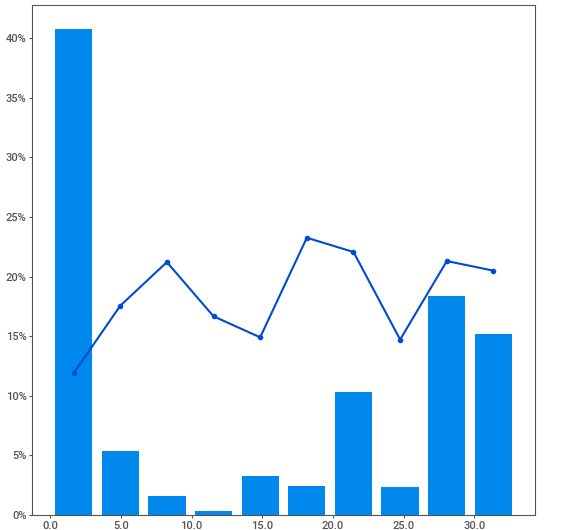
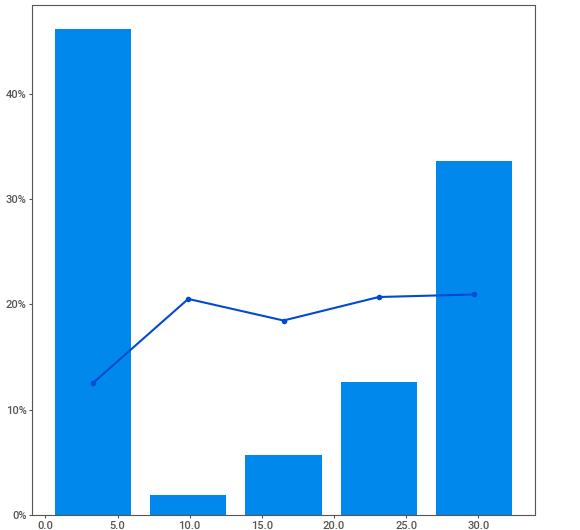
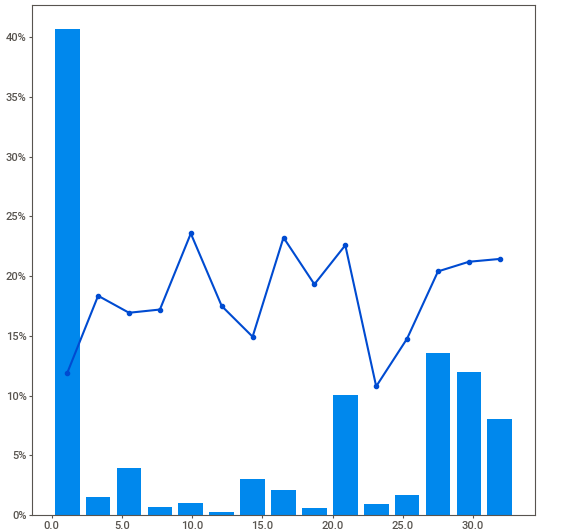
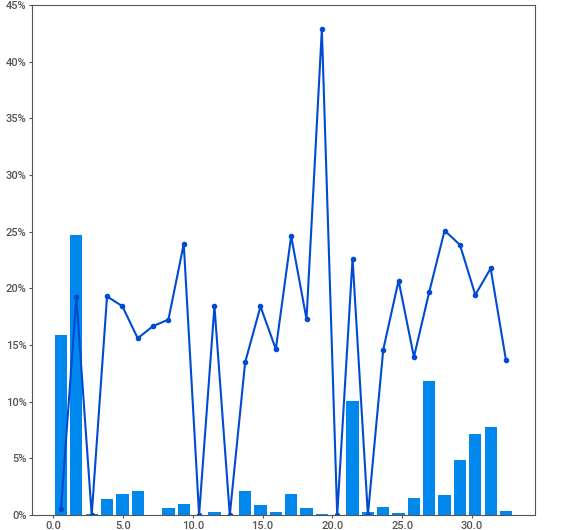
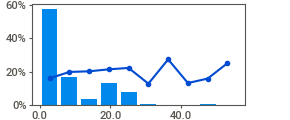
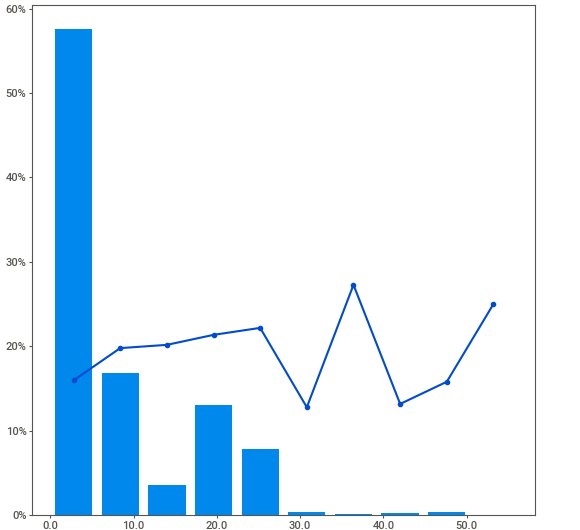
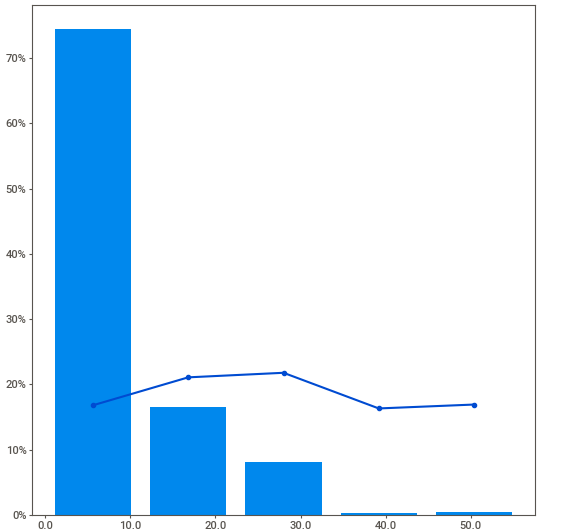
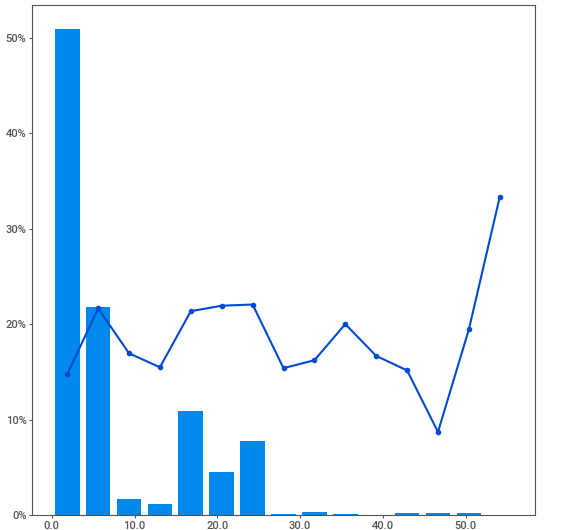
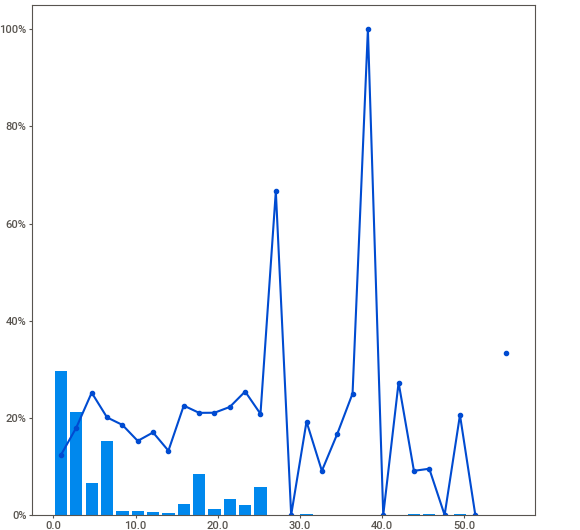
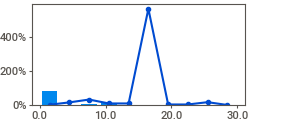
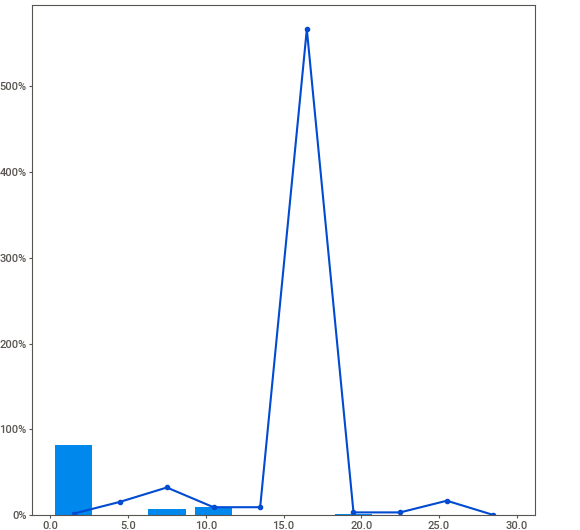
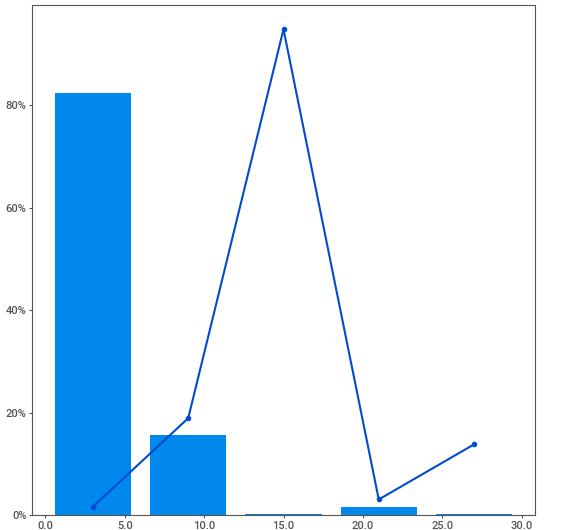
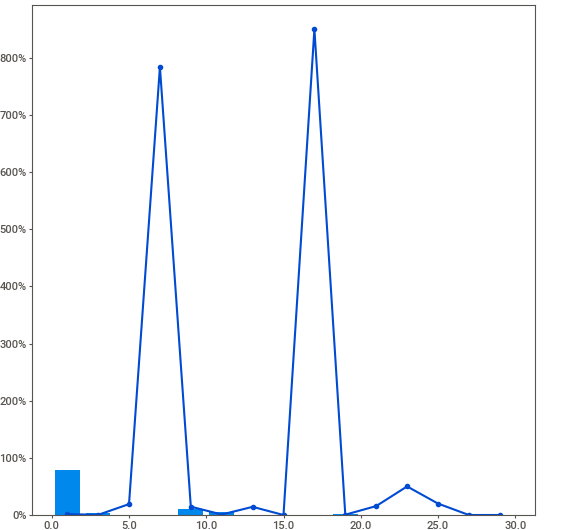
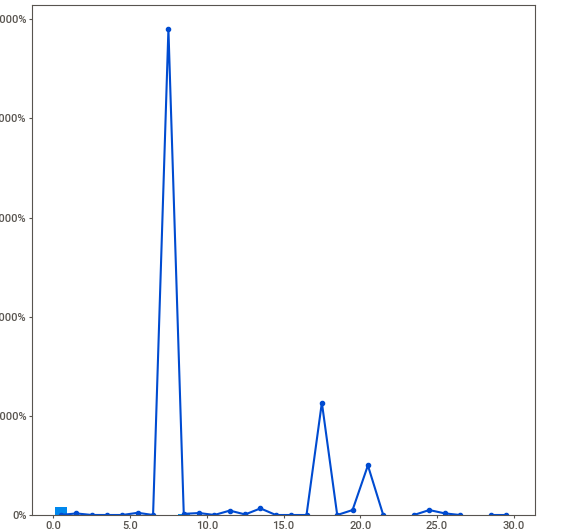
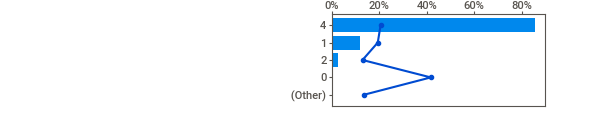
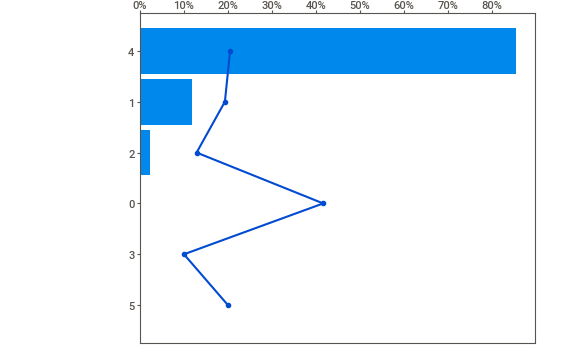
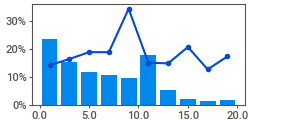
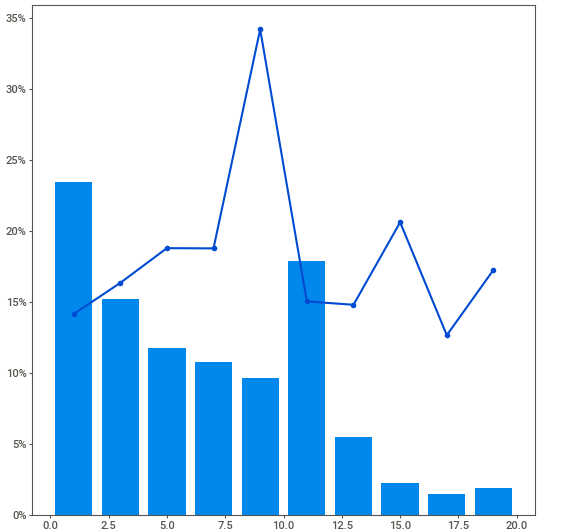
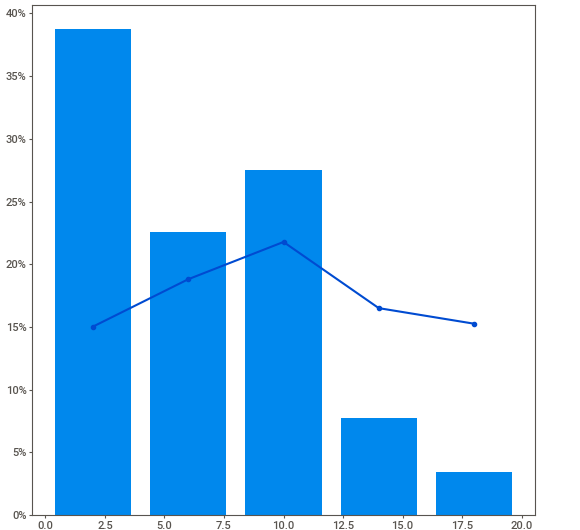
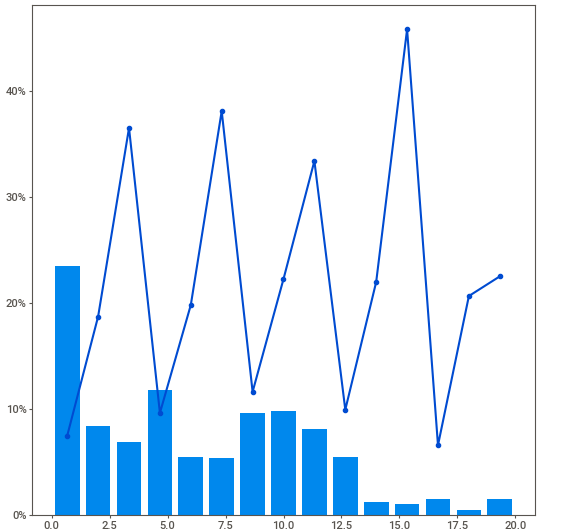
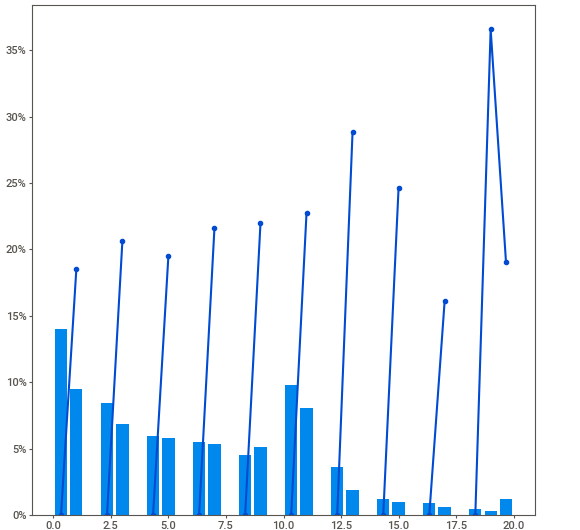
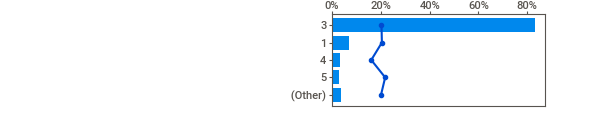
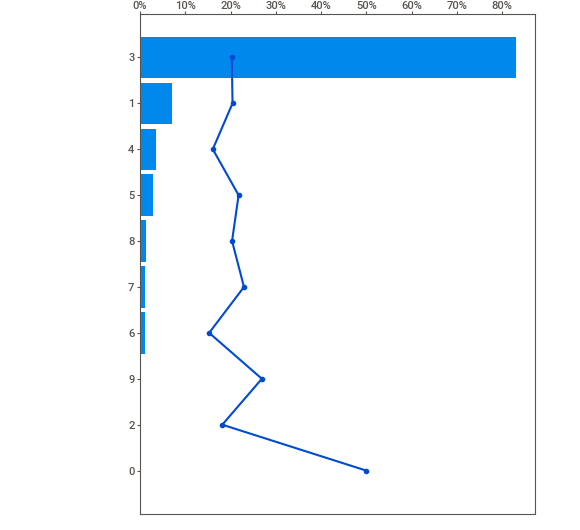
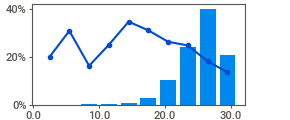
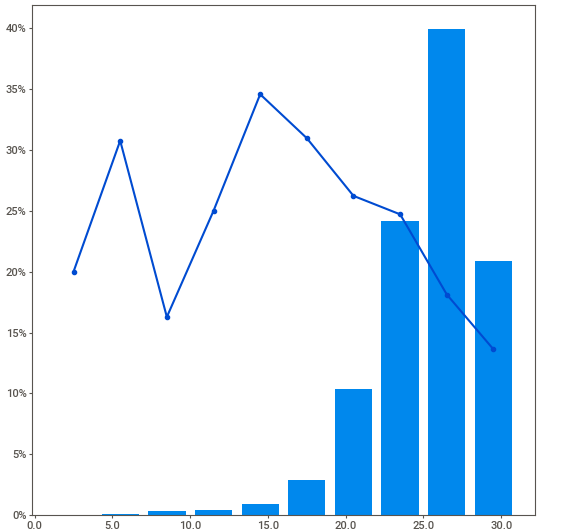
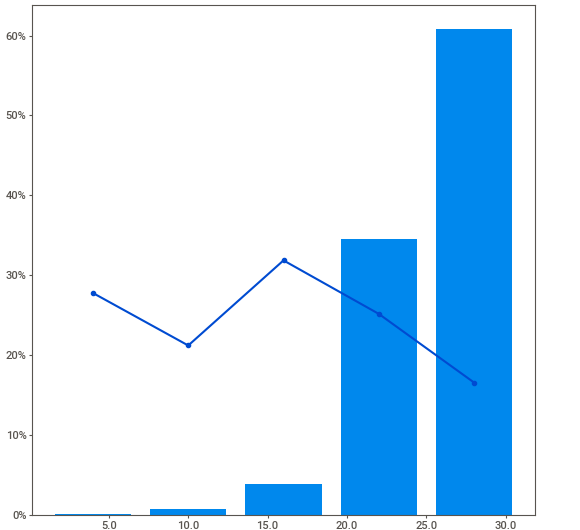
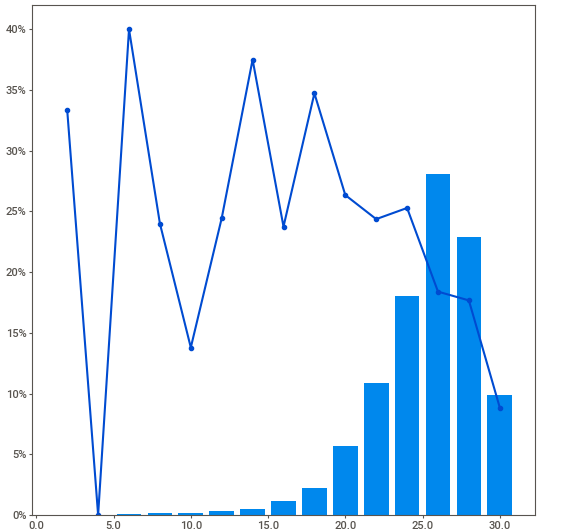
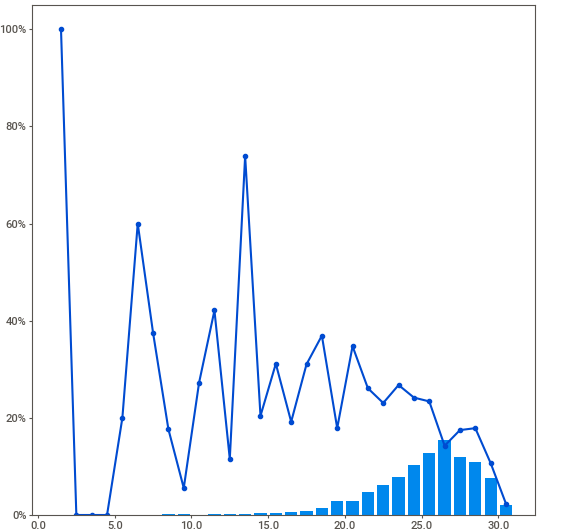
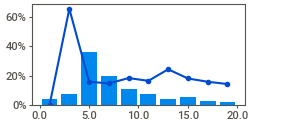
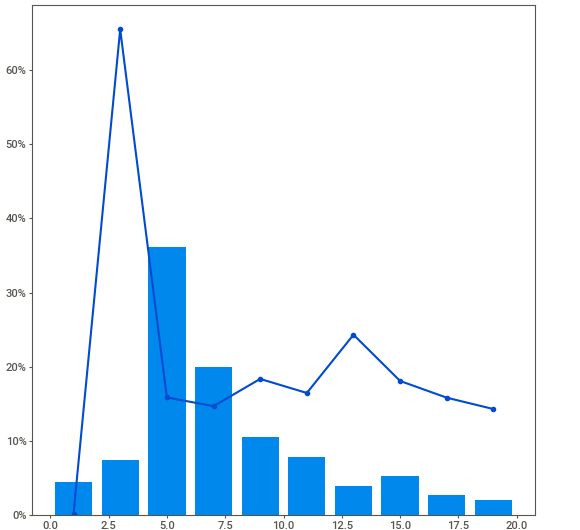
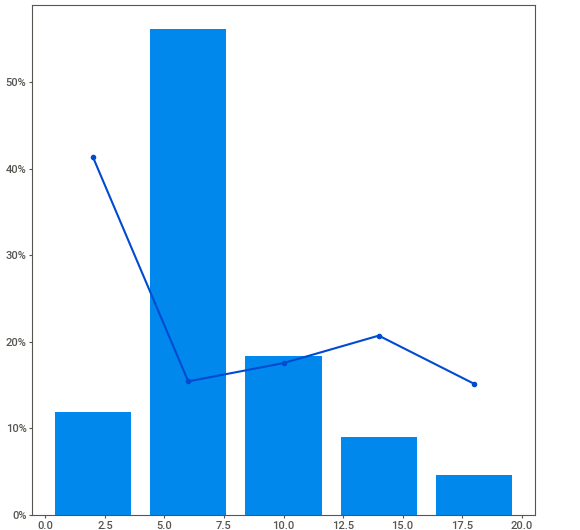
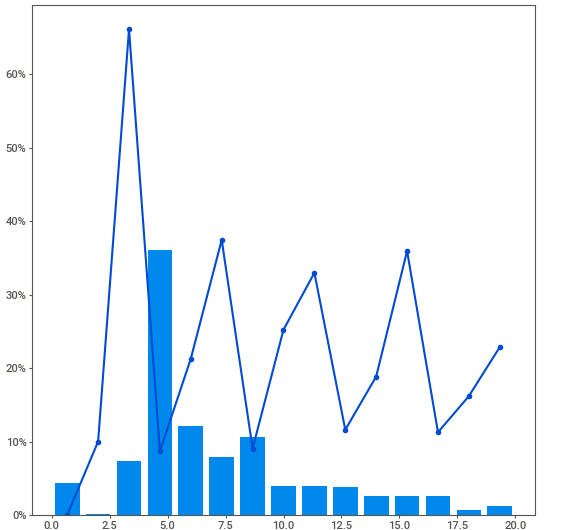
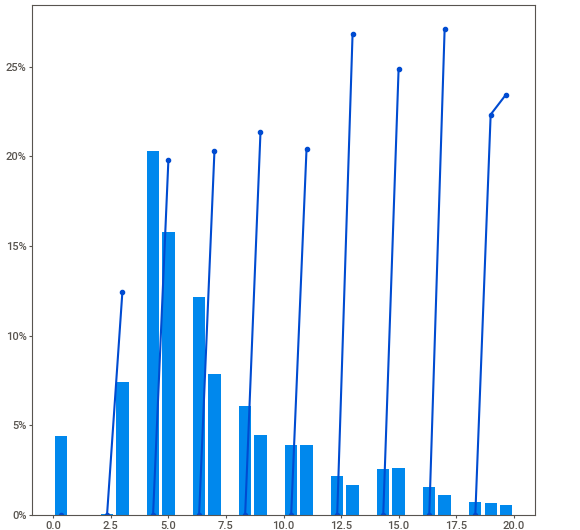
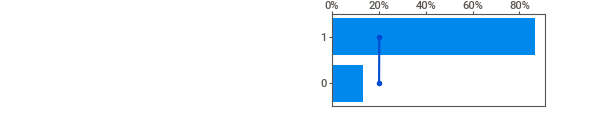
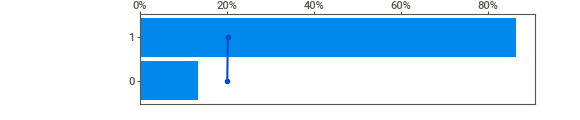
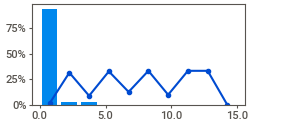
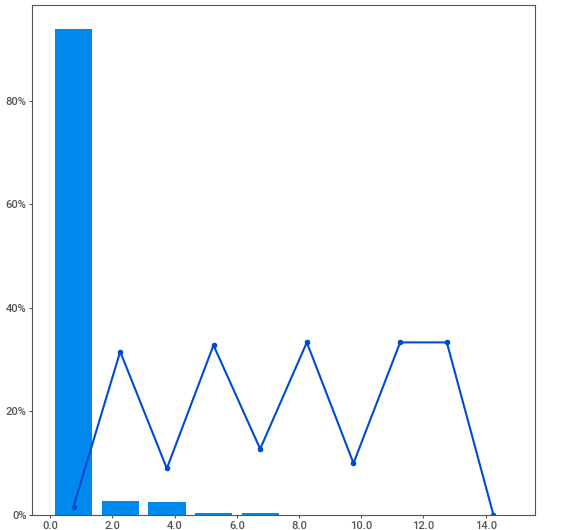
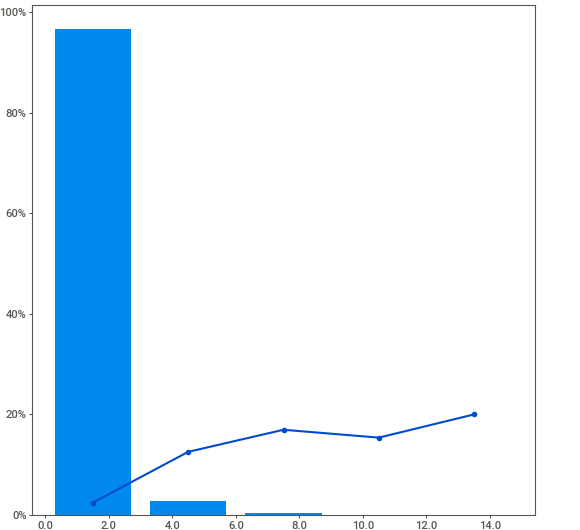
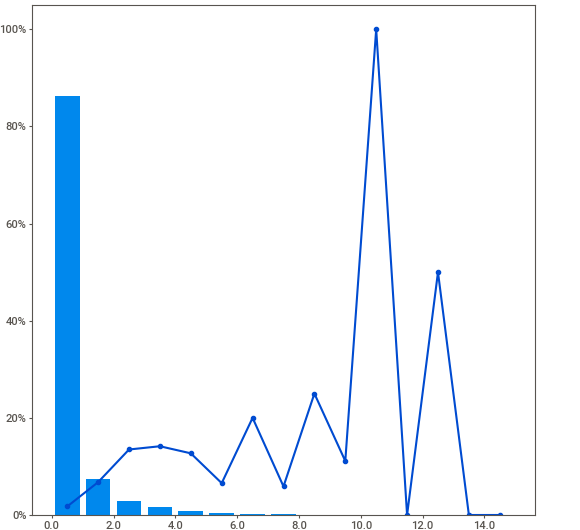
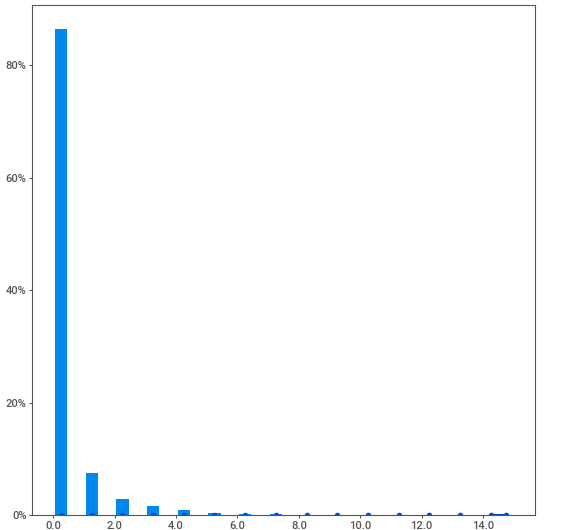
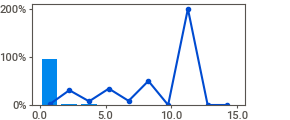
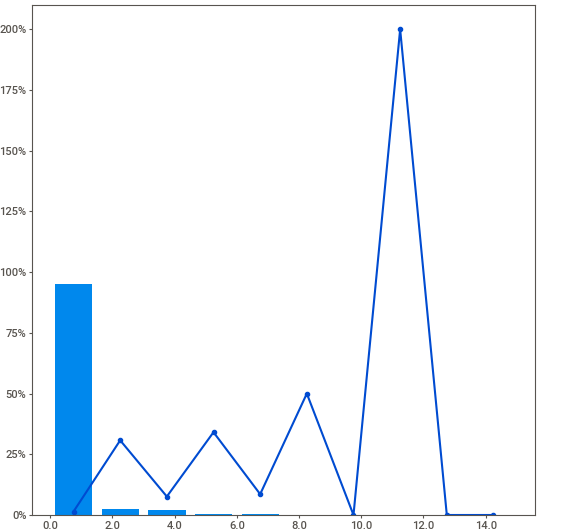
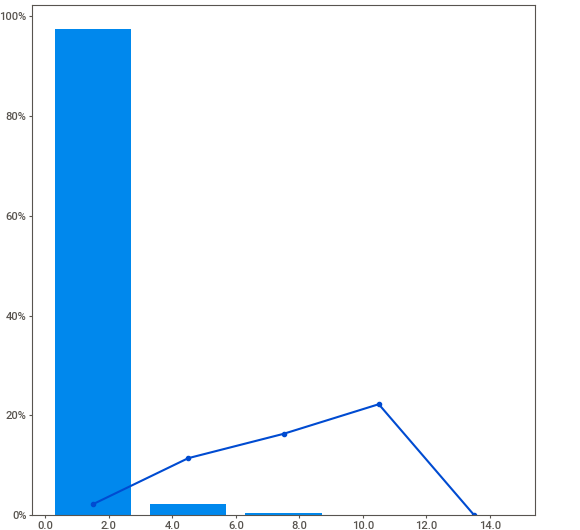
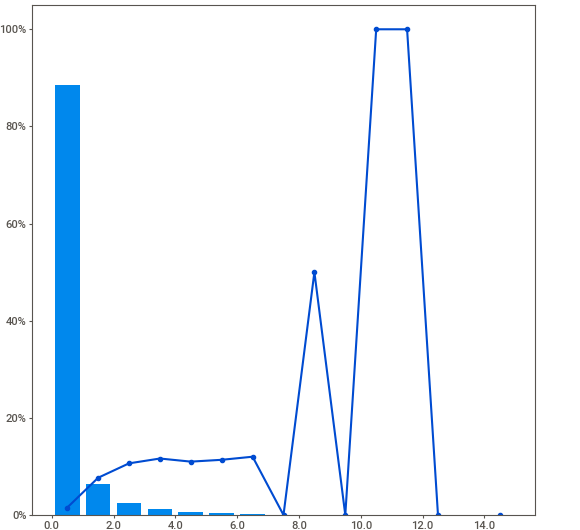
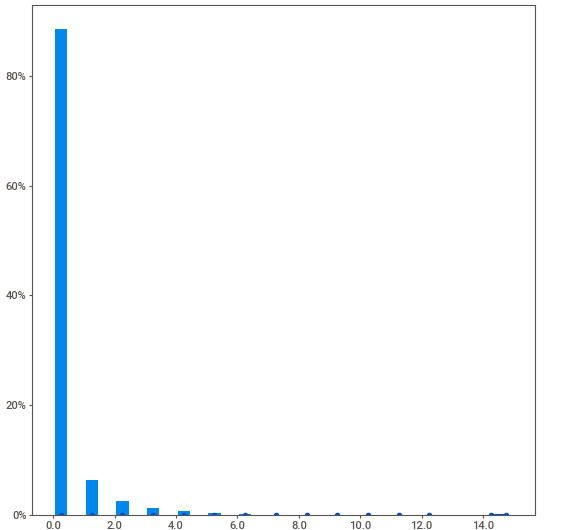
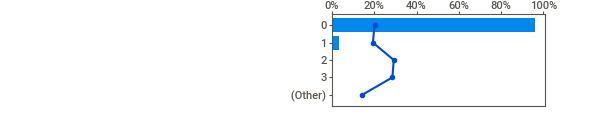
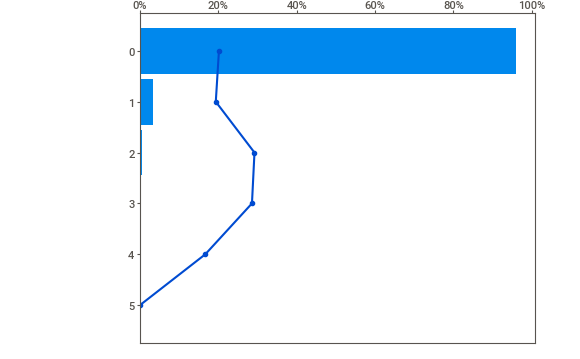
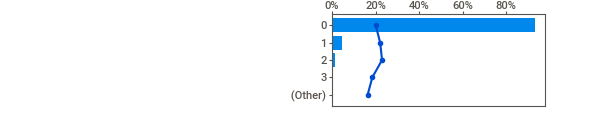
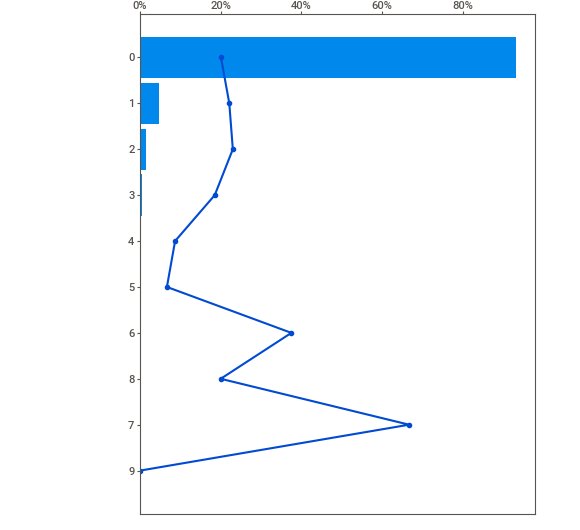
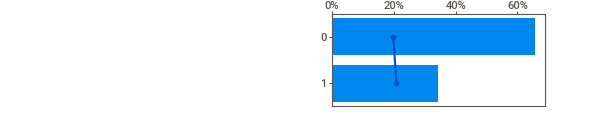
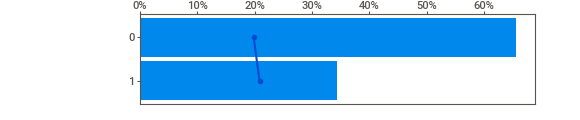
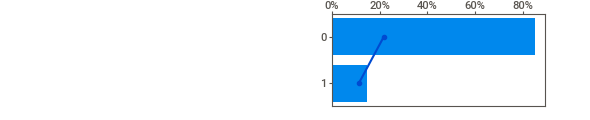
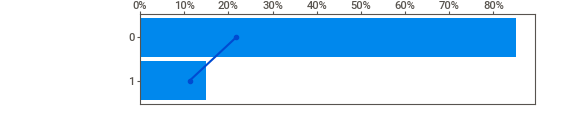
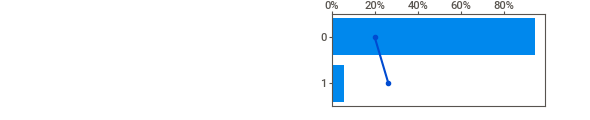
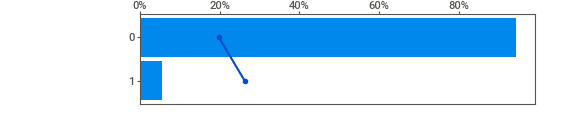
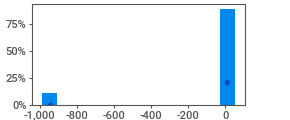
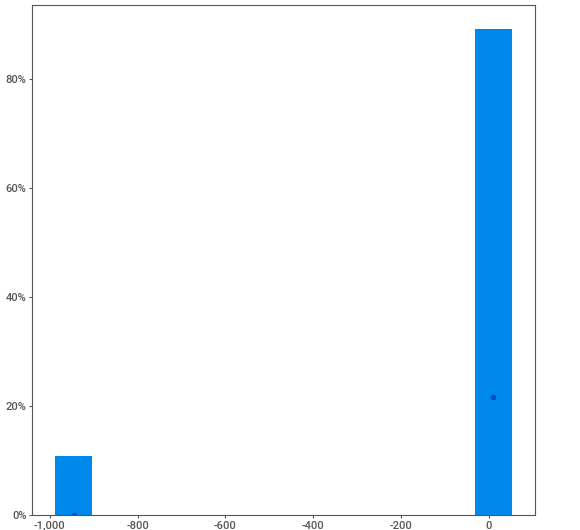
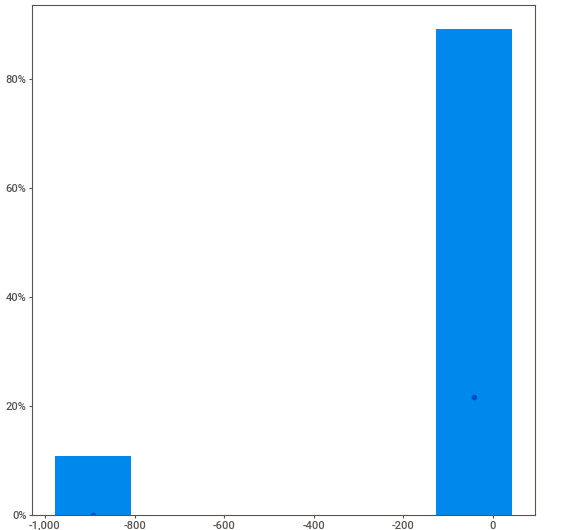
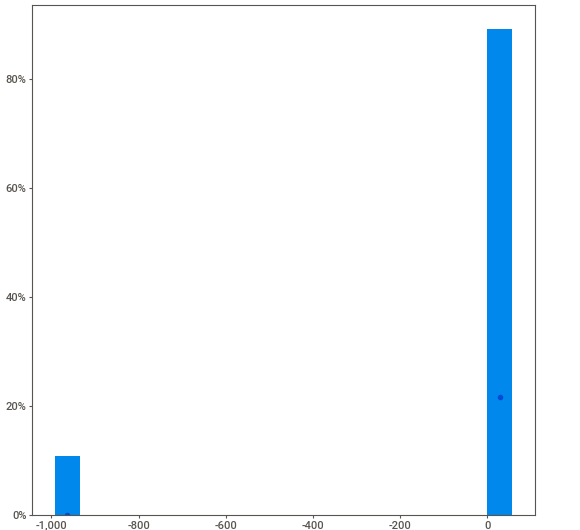
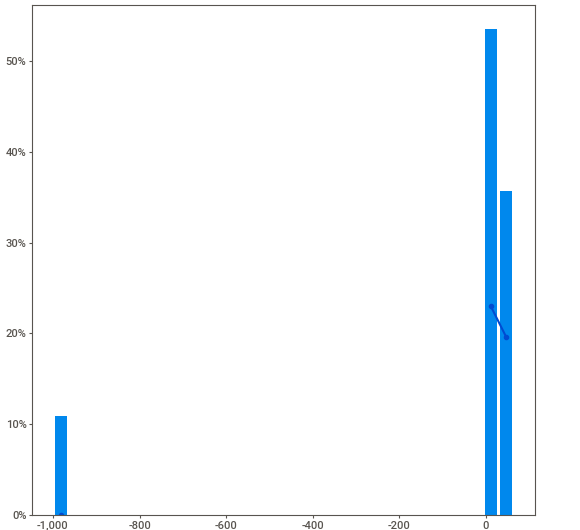
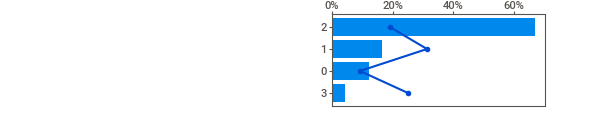
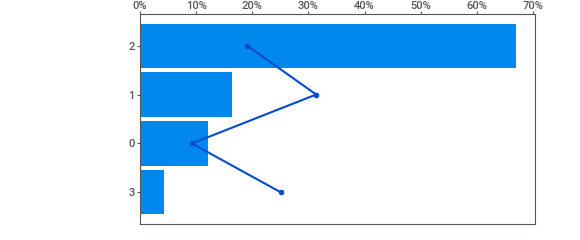
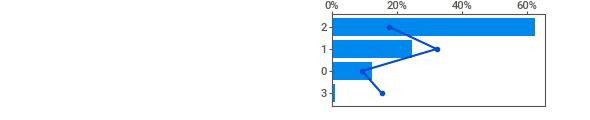
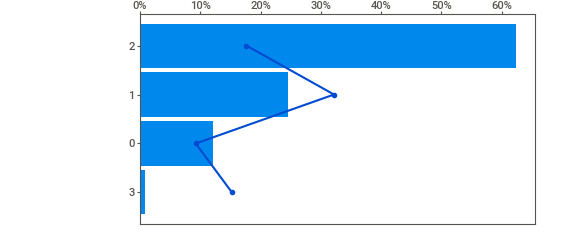
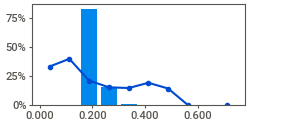
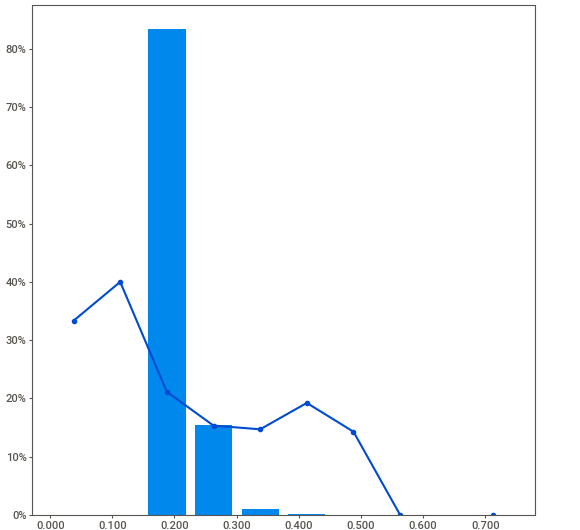
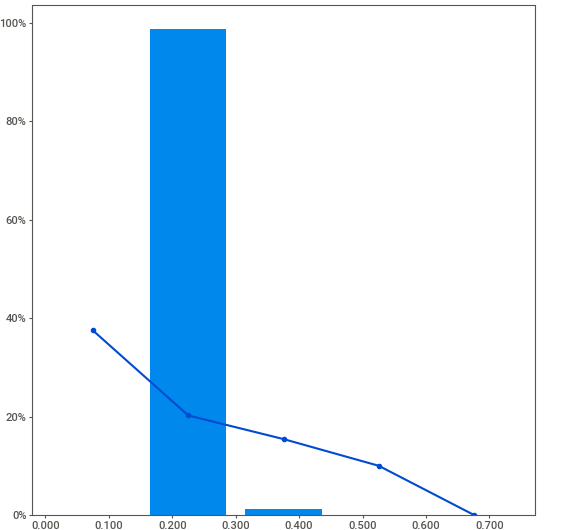
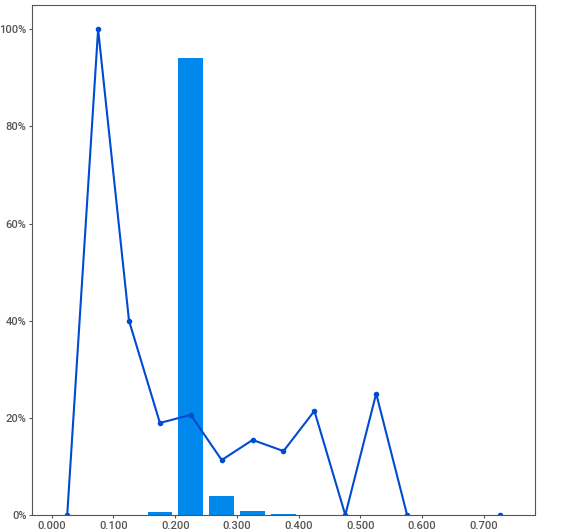
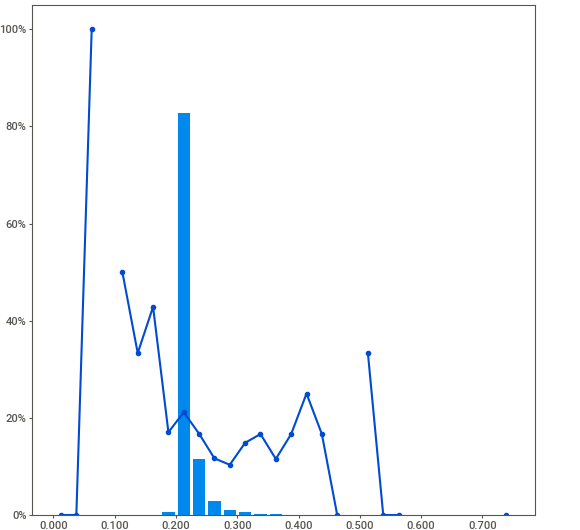
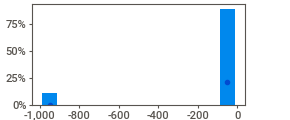
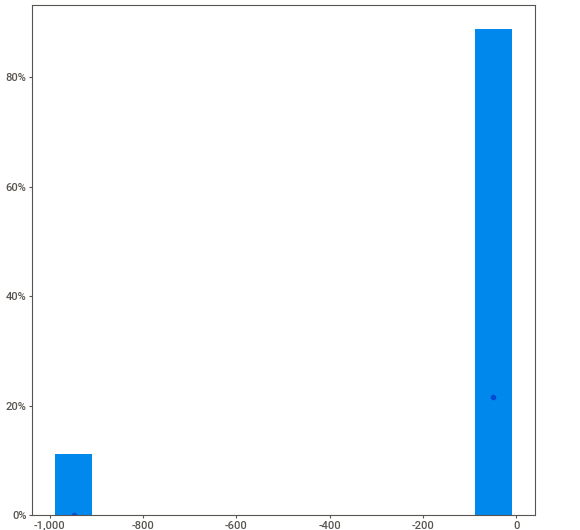
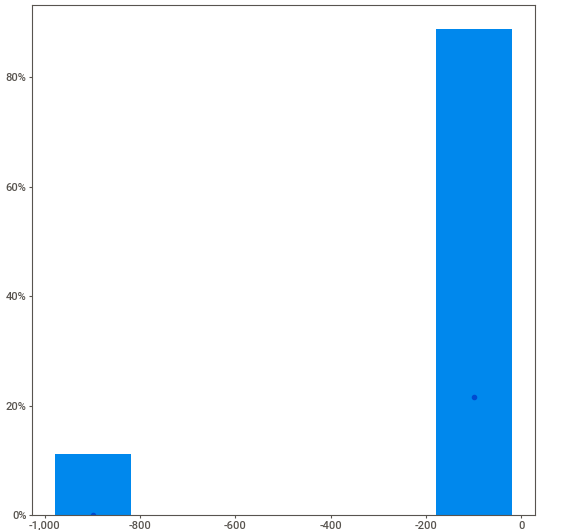
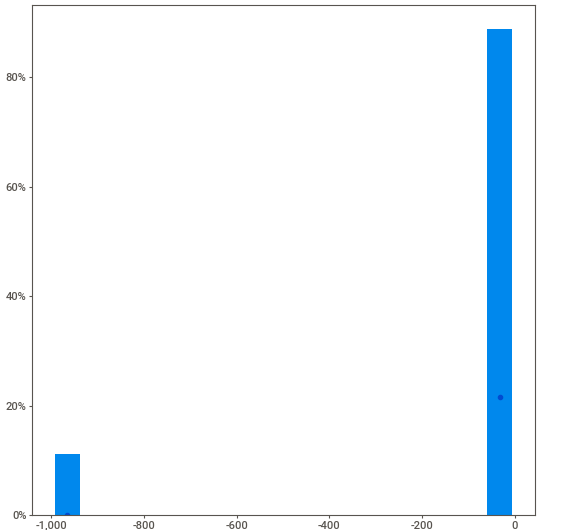
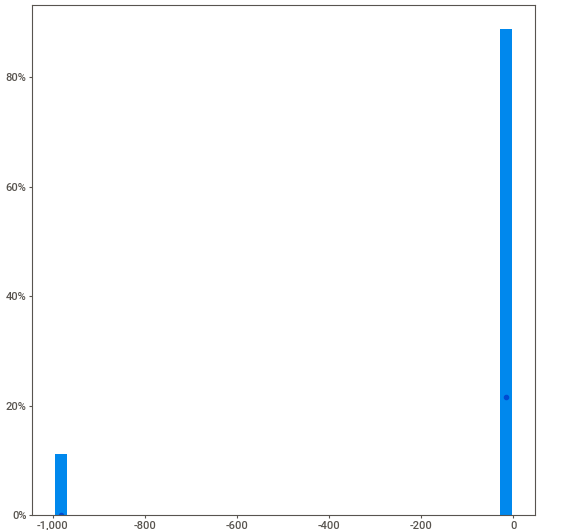
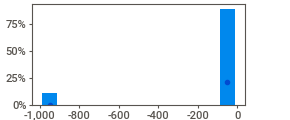
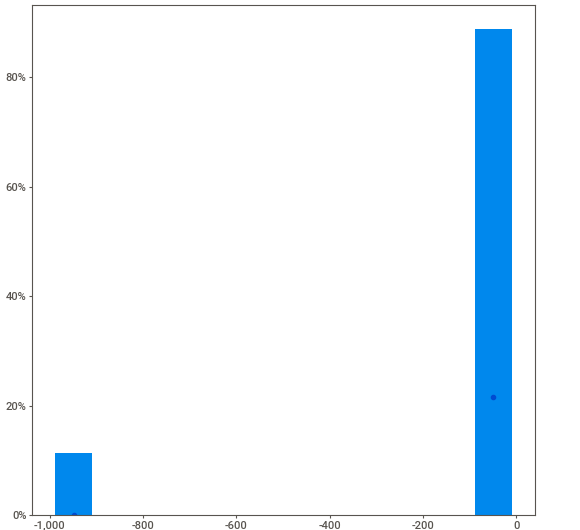
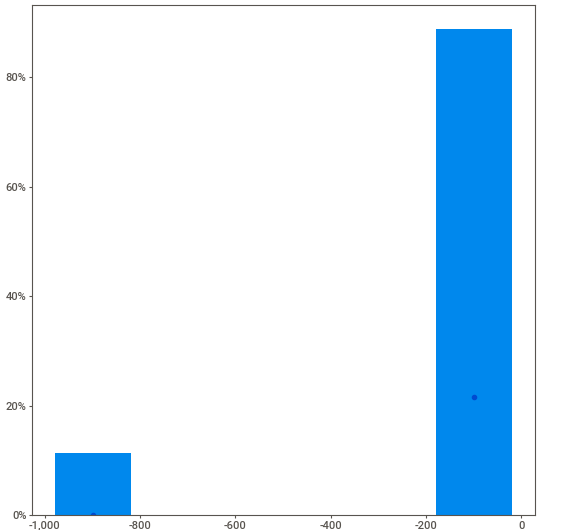
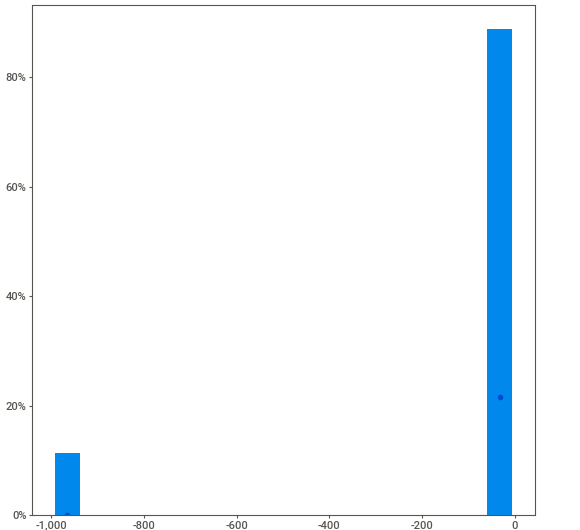
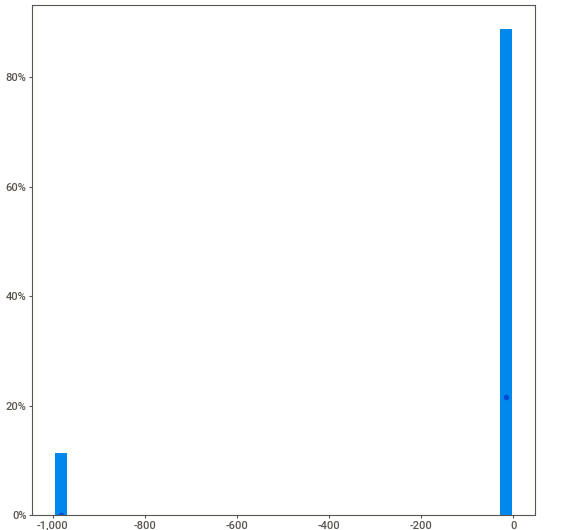
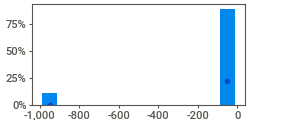
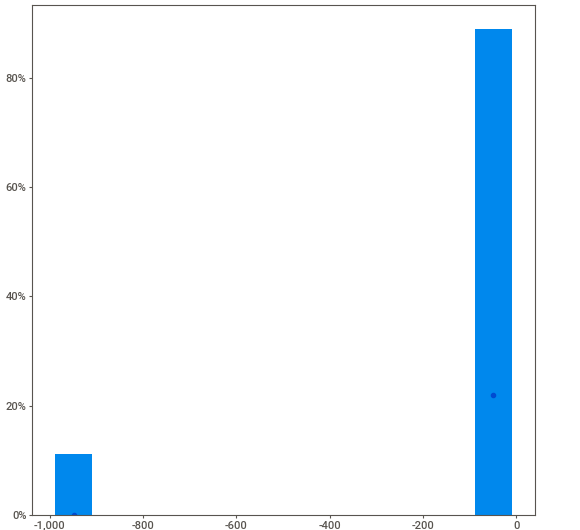
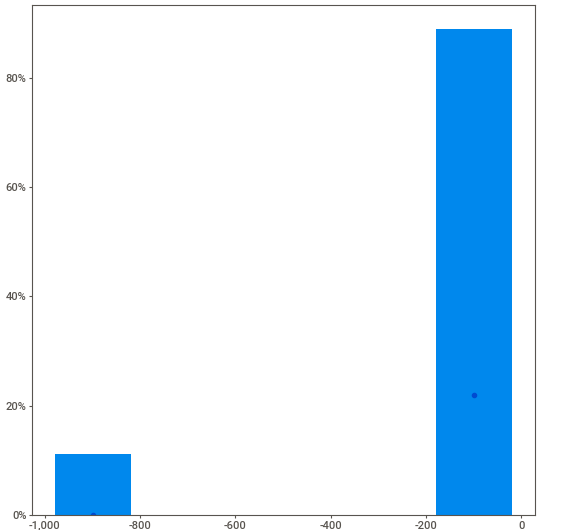
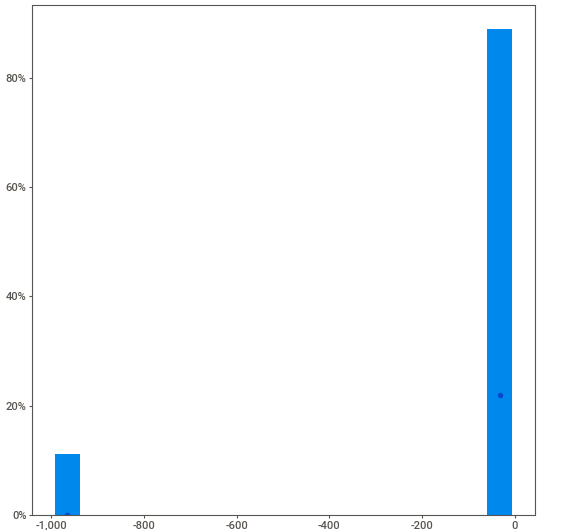
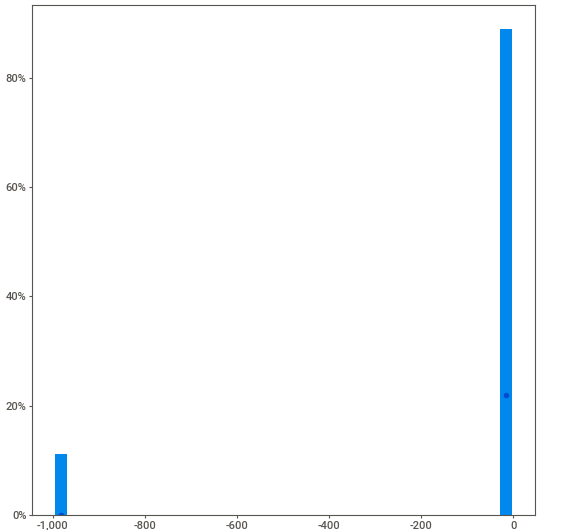
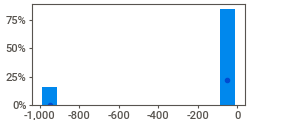
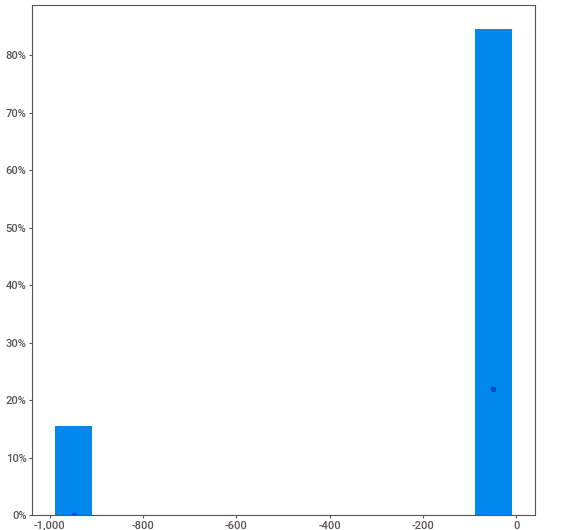
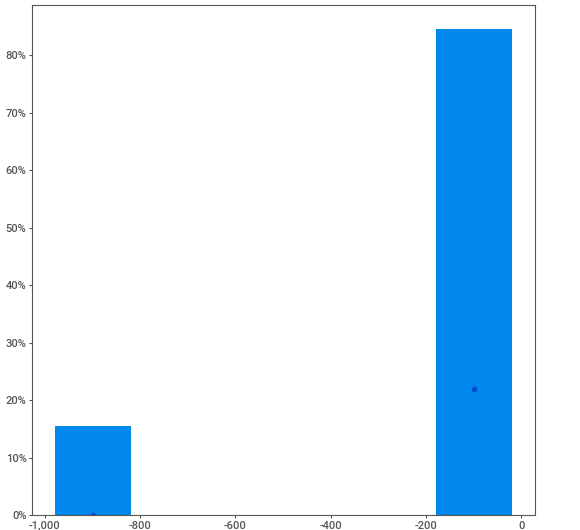
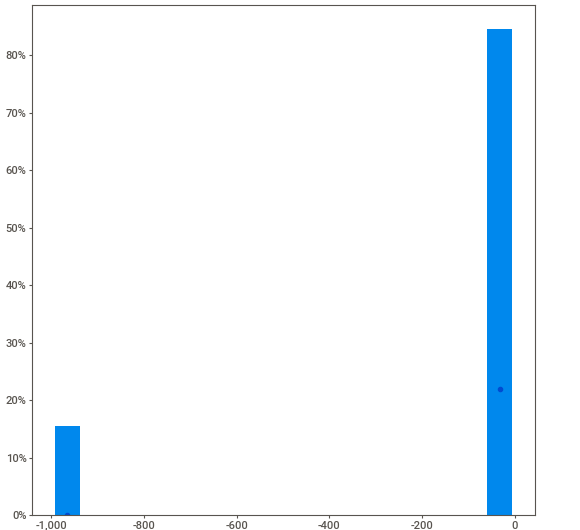
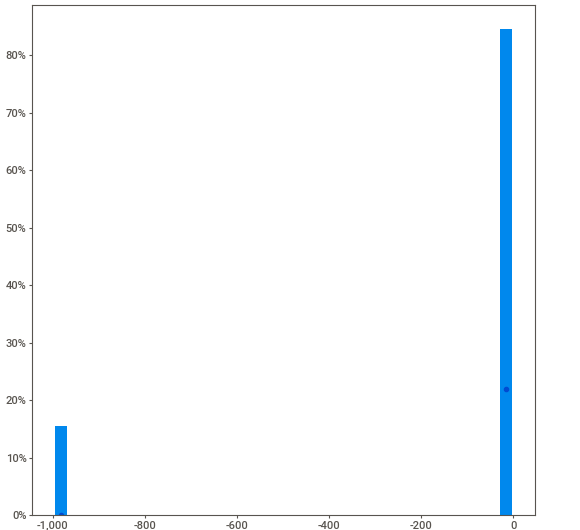
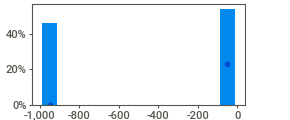
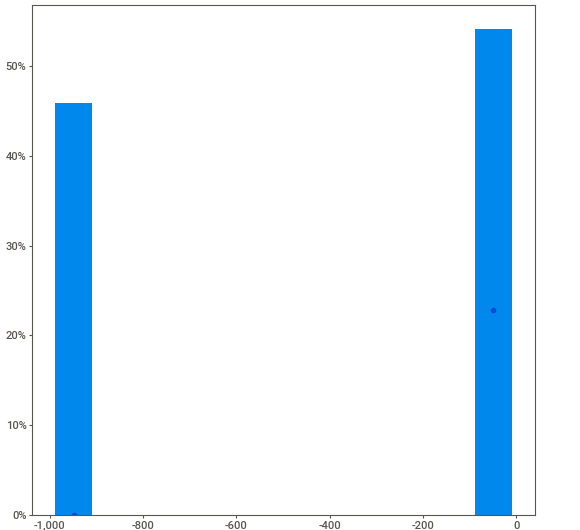
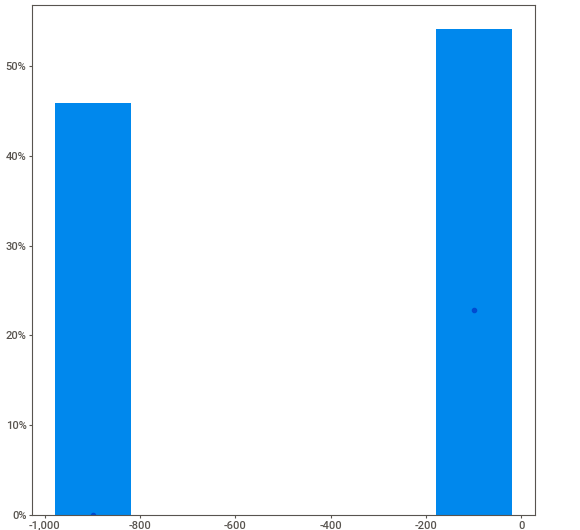
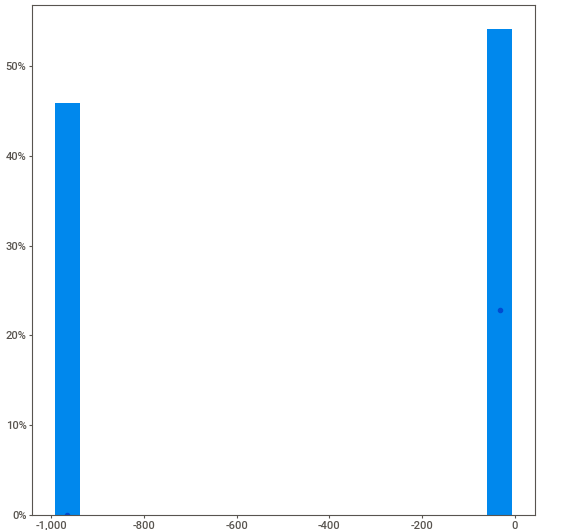
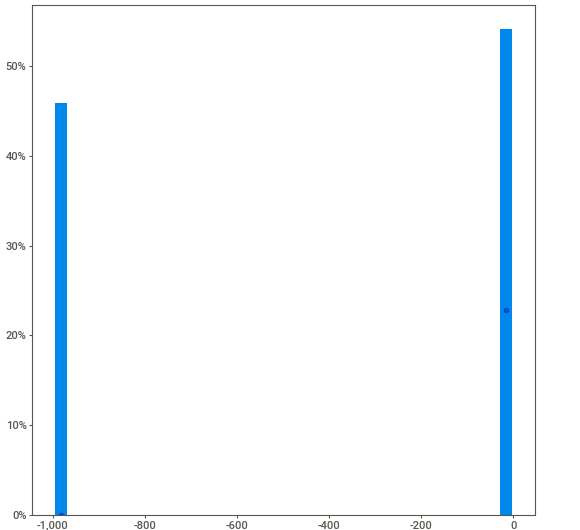
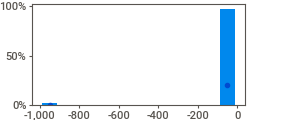
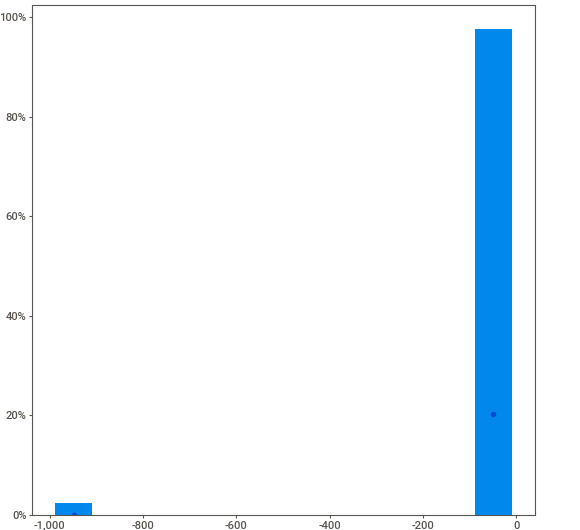
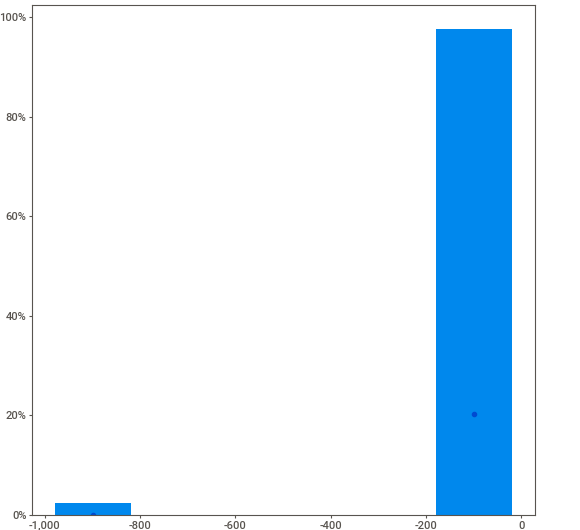
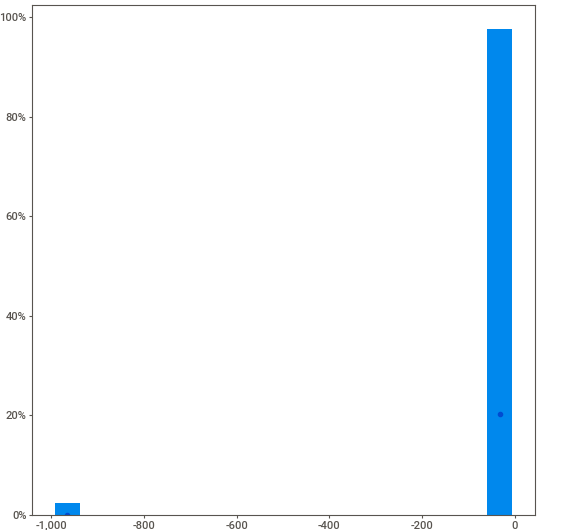
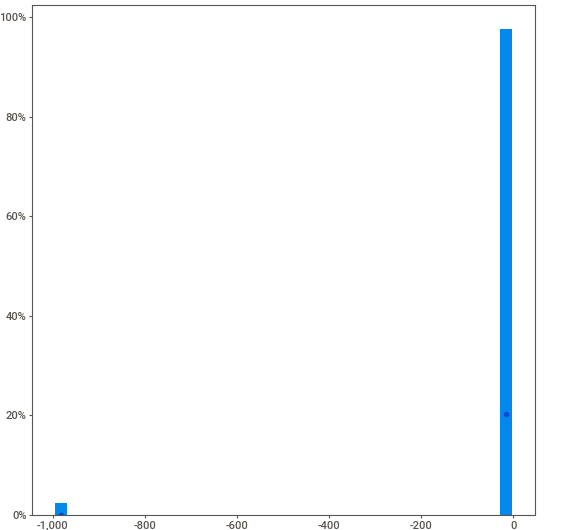
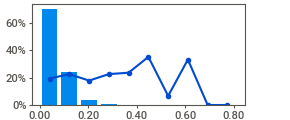
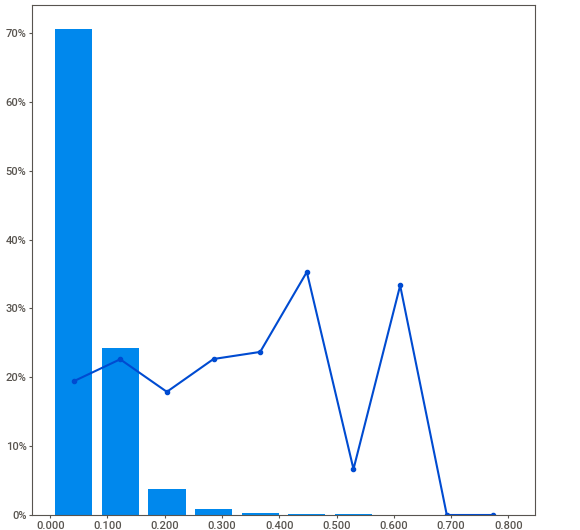
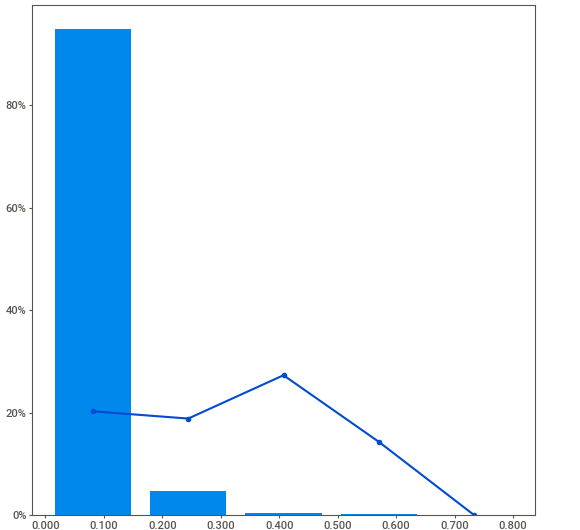
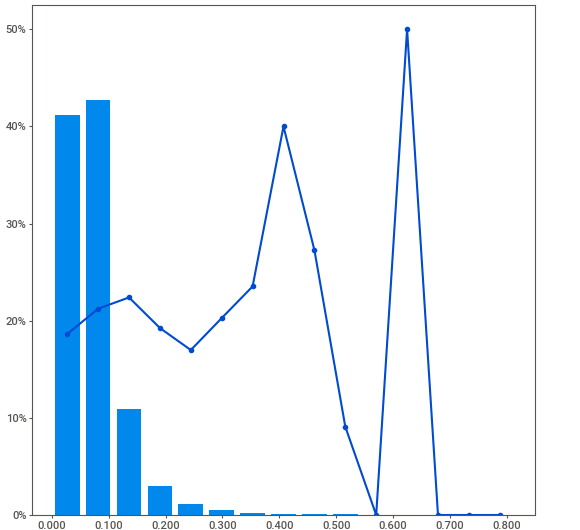
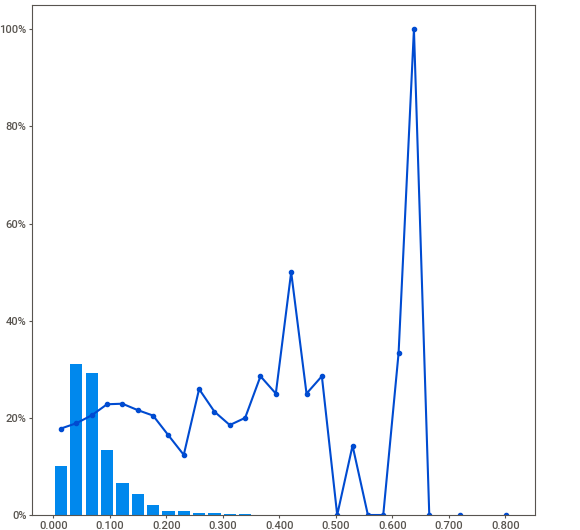
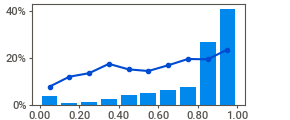
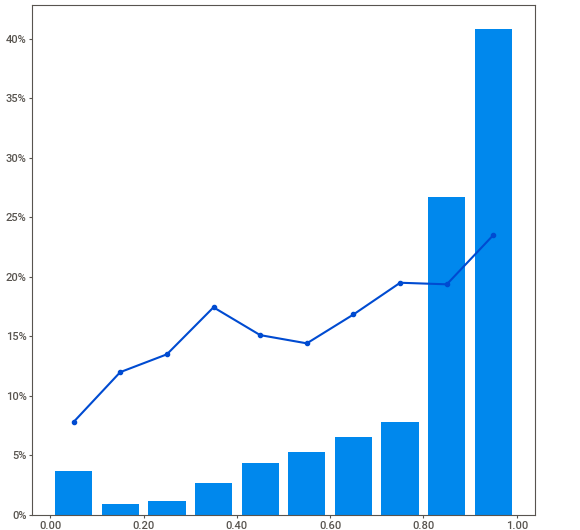
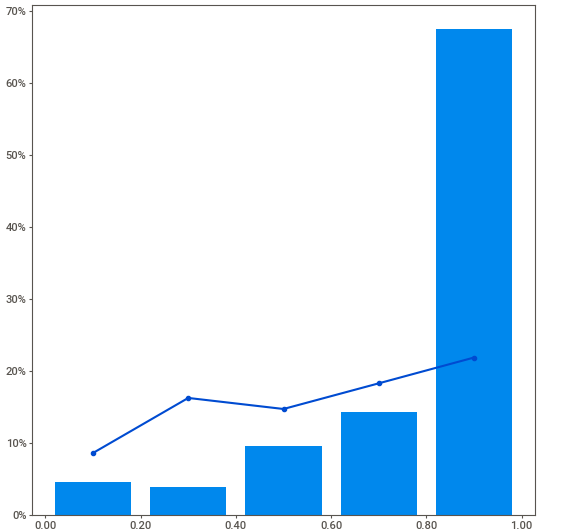
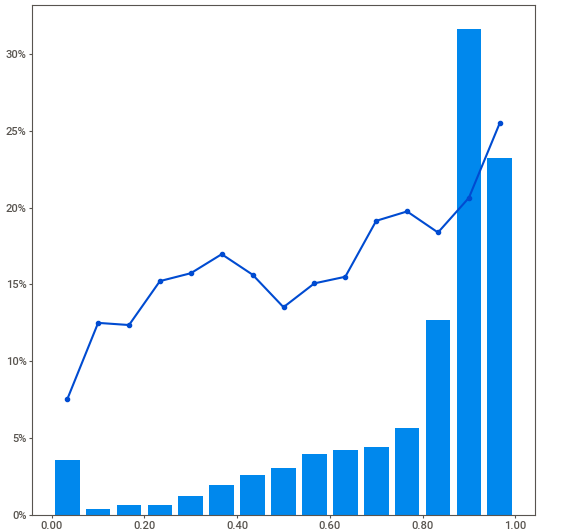
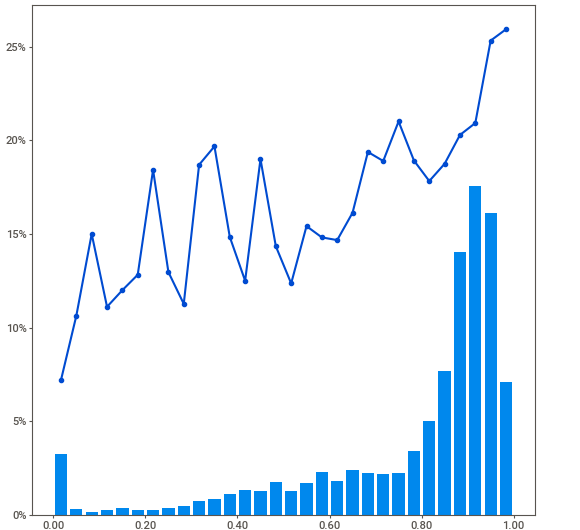
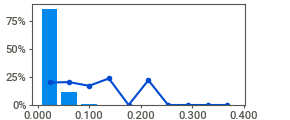
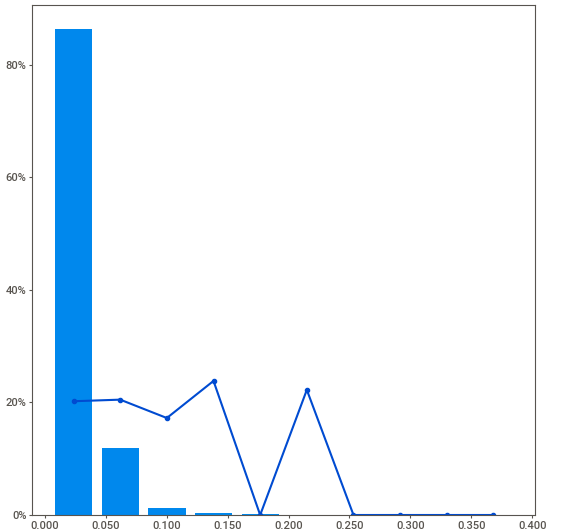
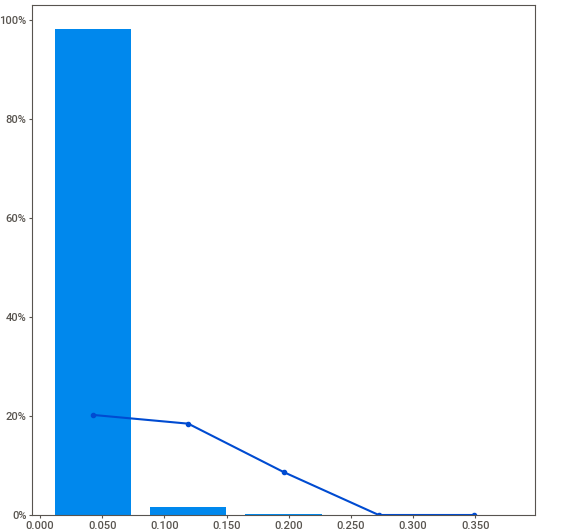
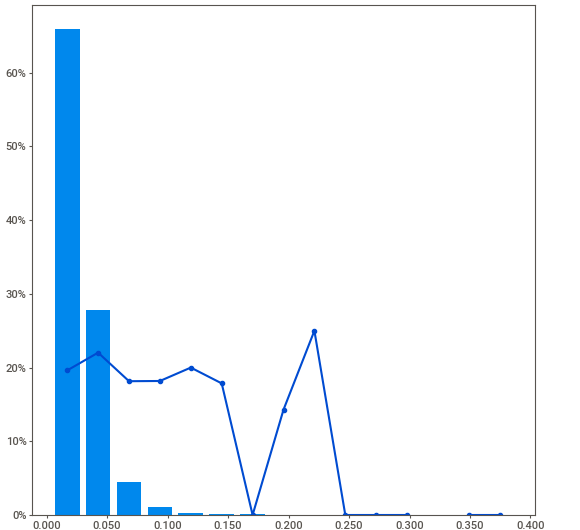
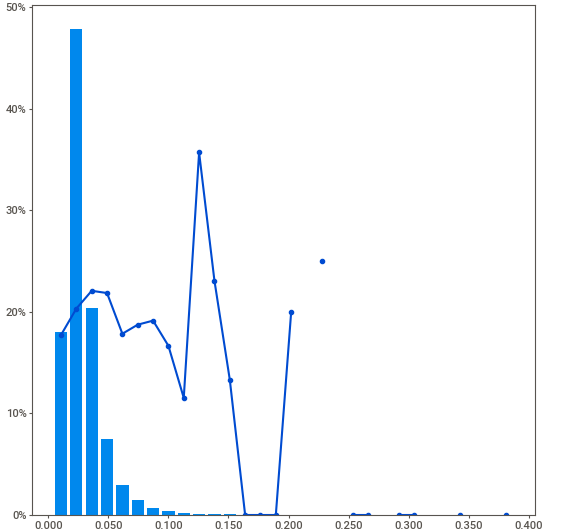
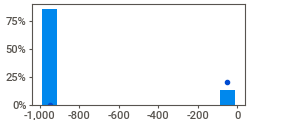
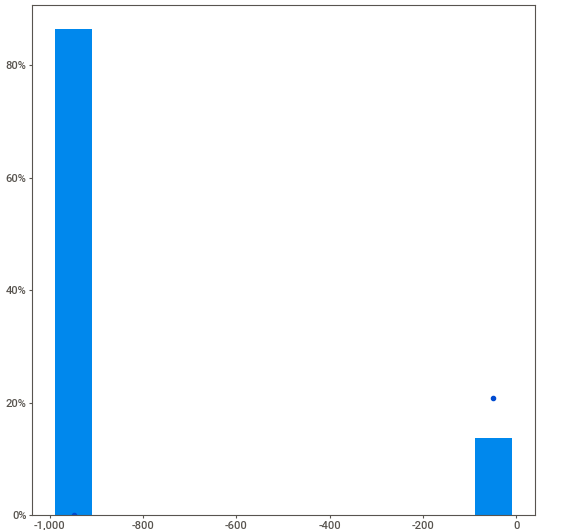
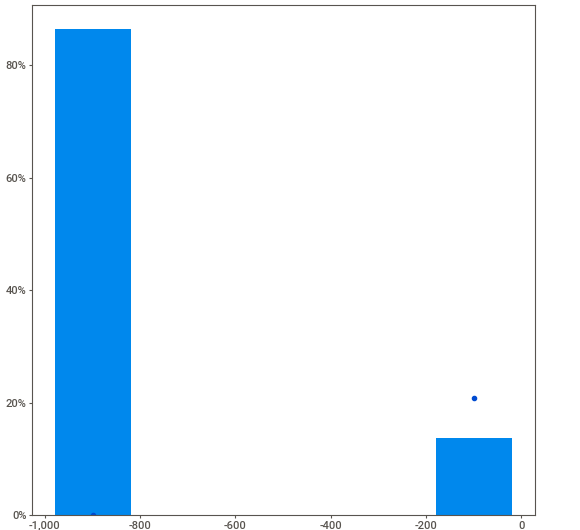
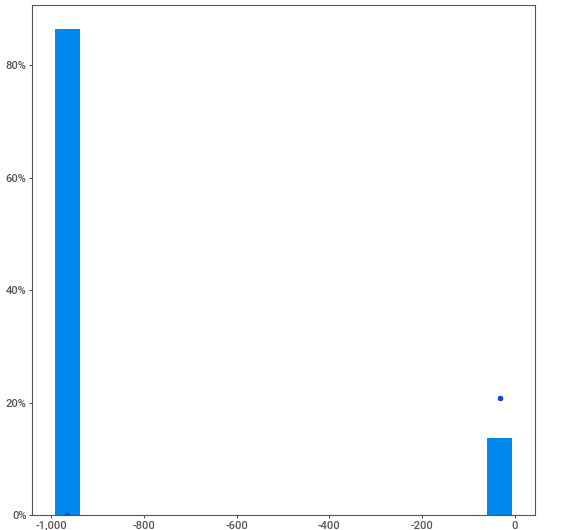
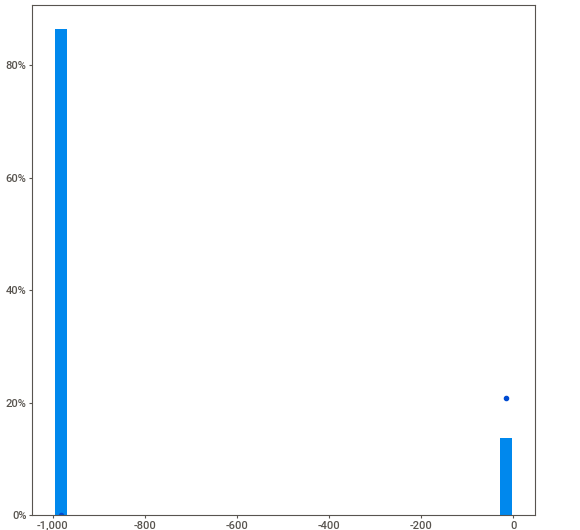
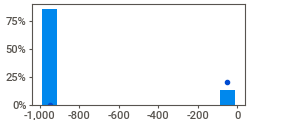
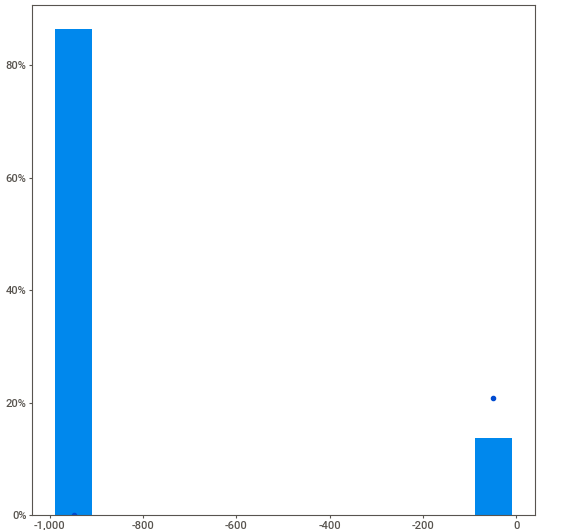
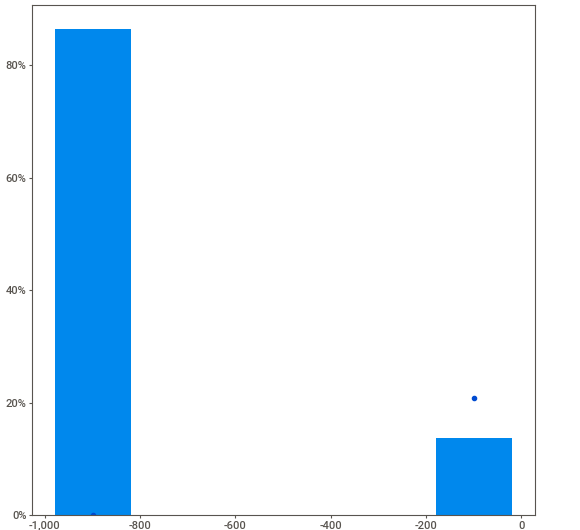
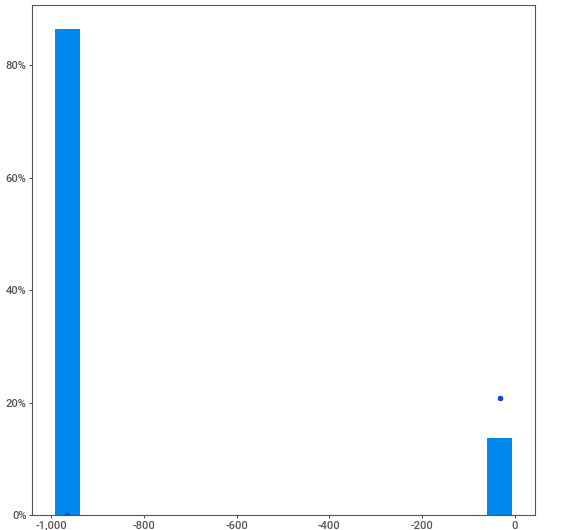
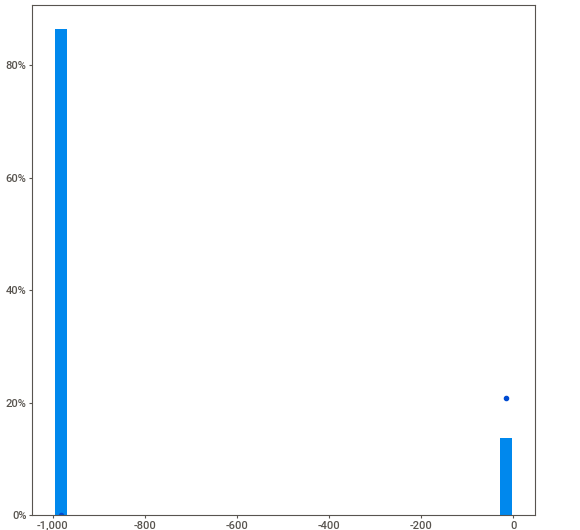
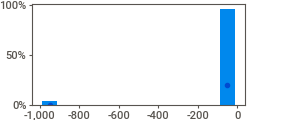
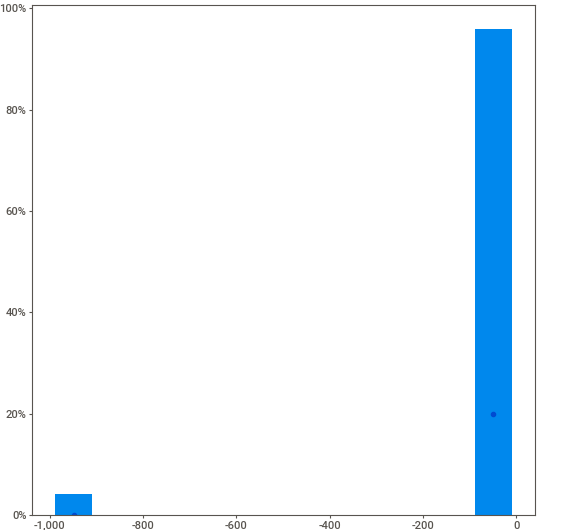
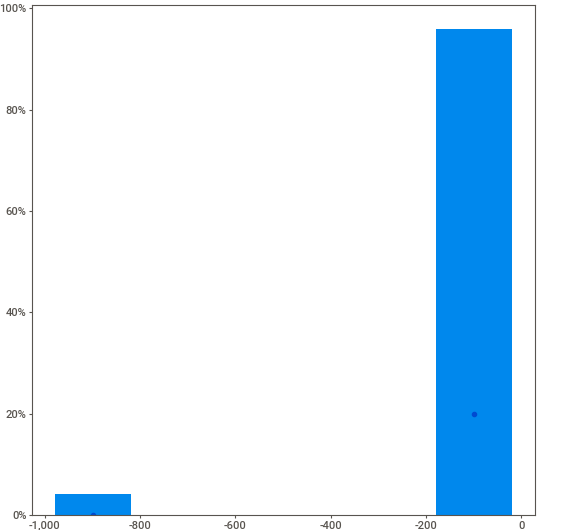
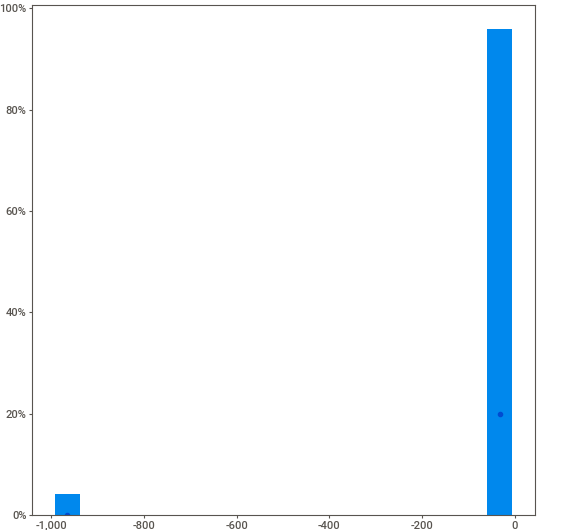
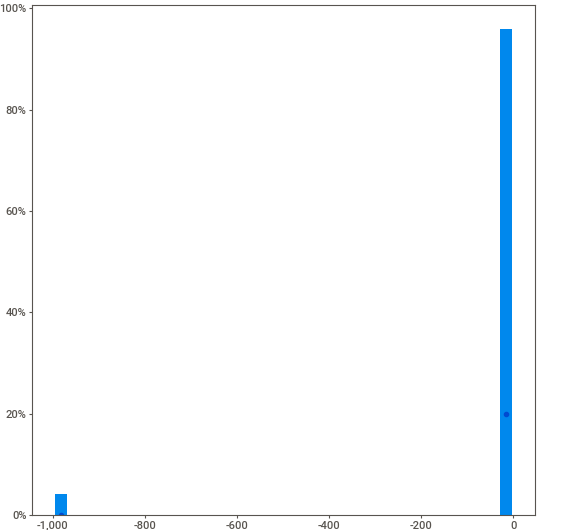
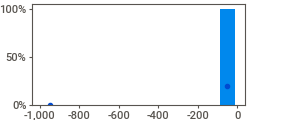
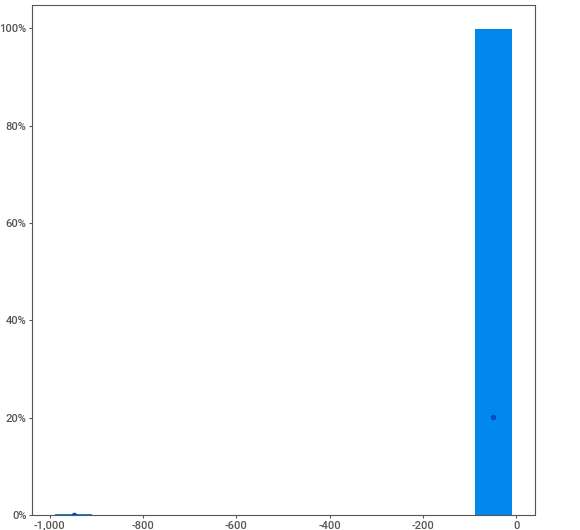
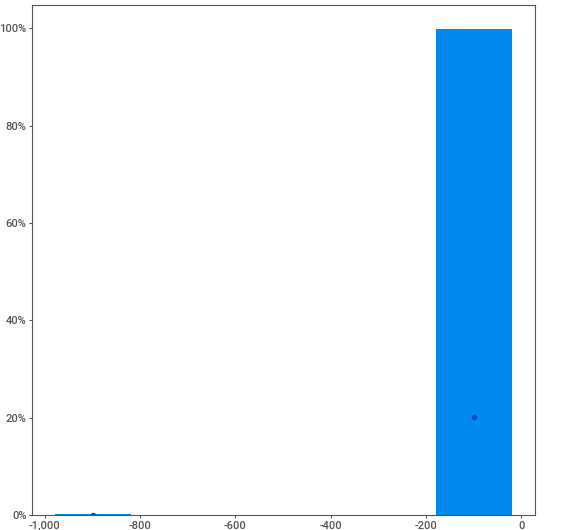
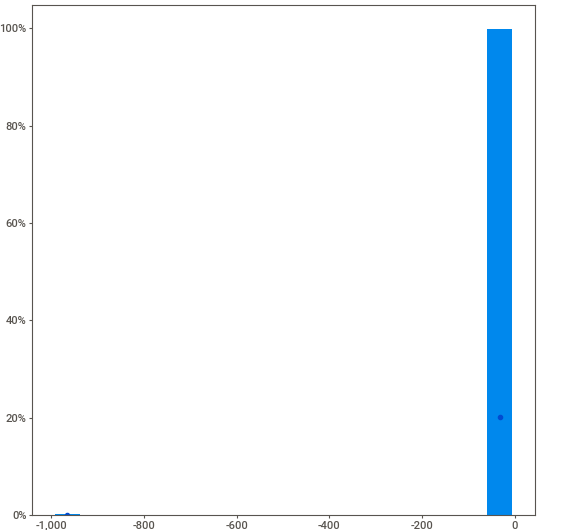
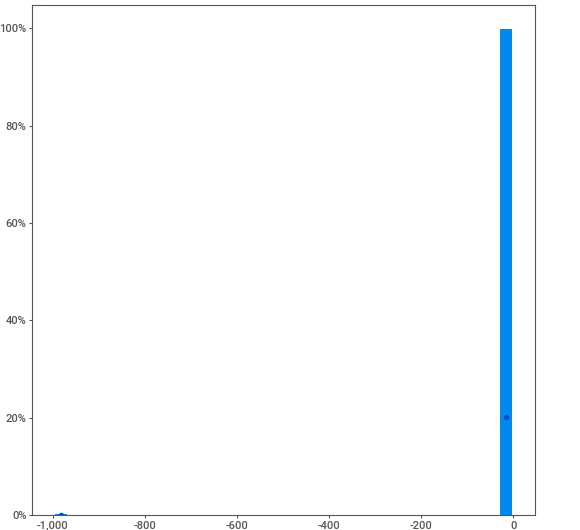
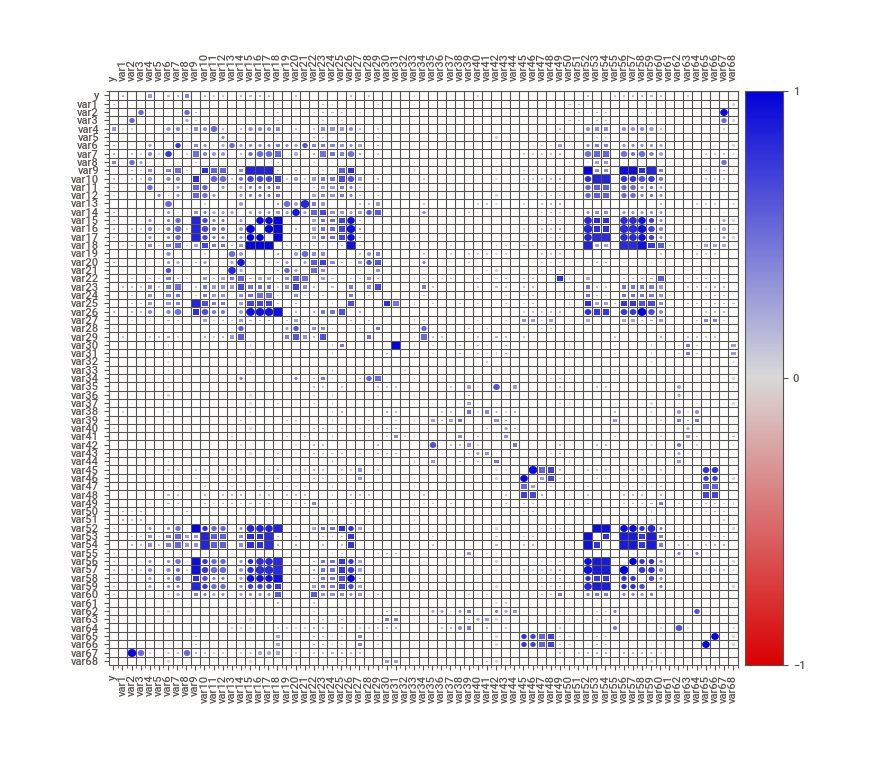
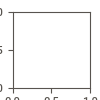

In [6]:
my_report.show_notebook()

# Feature Selection
---

Métodos utilizados para seleção de features:
    
- Variable Importance
- Information Gain
- Zero Proportion
- Null Proportion
- Backward Feature Elimination
- Exhaustive Feature Selection (off)
- Lasso Regularization (L1)
- Recursive Feature Elimination (RFE)
- Boruta
- Random Feature

Preparar dados para análises:

In [7]:
X_test = test[cat_nom+cat_ord+num_dis+num_con]
X = train[cat_nom+cat_ord+num_dis+num_con]
y = train.y

SEED=314

# Variable Importance

In [8]:
clf = RandomForestClassifier(max_depth=2, random_state=SEED)

clf.fit(X, y);

res_var_imp = pd.DataFrame({
    "feature": X.columns,
    "var_imp": clf.feature_importances_
})

res_var_imp.sort_values('var_imp', ascending=False)

feature   var_imp
3     var4  0.221136
7     var8  0.135883
6     var7  0.108444
5     var6  0.104201
0     var1  0.068059
..     ...       ...
42   var40  0.000000
36   var32  0.000000
40   var25  0.000000
39   var24  0.000000
34   var41  0.000000

[68 rows x 2 columns]

# Information Gain

In [9]:
%%time
mutual_info = mutual_info_classif(X, y)

CPU times: user 7.96 s, sys: 64.2 ms, total: 8.02 s
Wall time: 8.02 s


In [10]:
res_mutual_info = pd.DataFrame({
    "feature": X.columns,
    "mutual_info": mutual_info
})

res_mutual_info.sort_values('mutual_info', ascending=False)

feature  mutual_info
3     var4     0.134877
7     var8     0.061864
4     var5     0.061052
5     var6     0.057266
6     var7     0.044903
..     ...          ...
42   var40     0.000000
56   var55     0.000000
55   var68     0.000000
44   var45     0.000000
34   var41     0.000000

[68 rows x 2 columns]

# Zero Proportion

In [11]:
res_pzeros = pd.DataFrame({
    "feature": X.columns,
    "pzeros": (X.shape[0] - X.astype(bool).sum(axis=0)) / X.shape[0] * 100
})

res_pzeros.sort_values('pzeros', ascending=False)

feature     pzeros
var31   var31  96.360547
var47   var47  95.999434
var51   var51  94.470013
var48   var48  93.202577
var46   var46  88.501027
...       ...        ...
var21   var21   0.000000
var42   var42   0.000000
var26   var26   0.000000
var2     var2   0.000000
var10   var10   0.000000

[68 rows x 2 columns]

# Null Proportion

In [12]:
res_pnull = pd.DataFrame({
    "feature": X.columns,
    "pnull": 100 - (X.shape[0] - X.replace(-999, np.nan).isnull().sum()) / X.shape[0] * 100
})

res_pnull.sort_values('pnull', ascending=False)

feature      pnull
var66   var66  86.362671
var65   var65  86.362671
var60   var60  45.910925
var10   var10  16.561637
var8     var8  15.676556
...       ...        ...
var32   var32   0.000000
var42   var42   0.000000
var43   var43   0.000000
var24   var24   0.000000
var41   var41   0.000000

[68 rows x 2 columns]

# Backward Feature Elimination

In [13]:
%%time
lasso_newton = LogisticRegression(C=1, penalty="l2", solver='sag', tol = 0.1, random_state=314)
bfs=SequentialFeatureSelector(lasso_newton,
                              k_features='best',
                              forward=False,
                              floating=False, 
                              scoring='neg_log_loss',
                              cv=0,
                              verbose=2,
                              n_jobs=1)
bfs.fit(X, y);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    7.2s finished

[2021-08-06 14:53:03] Features: 67/1 -- score: -0.41227851599605814[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    6.9s finished

[2021-08-06 14:53:10] Features: 66/1 -- score: -0.41209933594224896[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:    6.6s finished

[2021-08-06 14:53:17] Features: 65/1 -- score: -0.4120419847216327[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: D

CPU times: user 5min 45s, sys: 5min 53s, total: 11min 39s
Wall time: 2min 58s


SequentialFeatureSelector(cv=0,
                          estimator=LogisticRegression(C=1, random_state=314,
                                                       solver='sag', tol=0.1),
                          forward=False, k_features='best',
                          scoring='neg_log_loss', verbose=2)

In [14]:
res_bfs = pd.DataFrame({
    "feature": X.columns,
    "bfs": np.where(X.columns.isin(bfs.k_feature_names_), "to_keep", "to_remove")
})
res_bfs.sort_values('bfs', ascending=True)

feature        bfs
67   var66    to_keep
18   var19    to_keep
61   var60    to_keep
29   var35    to_keep
20   var21    to_keep
..     ...        ...
34   var41  to_remove
35   var26  to_remove
36   var32  to_remove
38   var43  to_remove
33   var39  to_remove

[68 rows x 2 columns]

# Exhaustive Feature Selection

In [15]:
# %%time
# 
# efs = ExhaustiveFeatureSelector(LGBMClassifier(),
#                                 min_features=10,
#                                 max_features=75,
#                                 scoring='neg_log_loss',
#                                 print_progress=True,
#                                 cv=5)
# 
# efs.fit(X, y);

In [16]:
# res_efs = pd.DataFrame({
#     "feature": X.columns,
#     "efs": np.where(X.columns.isin(efs.k_feature_names_), "to_keep", "to_remove")
# })
# res_efs.sort_values('efs', ascending=True)

# Lasso Regularization (L1)

In [17]:
%%time

lasso = LogisticRegression(C=1, penalty="l1", solver="liblinear", random_state=314).fit(X, y)
lasso_selector = SelectFromModel(lasso, prefit=True, threshold="median")

CPU times: user 2.78 s, sys: 12.2 ms, total: 2.8 s
Wall time: 2.8 s


In [18]:
res_lasso = pd.DataFrame({
    "feature": X.columns,
    "lasso": np.where(lasso_selector.get_support(), "to_keep", "to_remove")
})
res_lasso.sort_values('lasso', ascending=True)

feature      lasso
0     var1    to_keep
48   var49    to_keep
24   var29    to_keep
25   var30    to_keep
26   var31    to_keep
..     ...        ...
29   var35  to_remove
30   var36  to_remove
31   var37  to_remove
35   var26  to_remove
67   var66  to_remove

[68 rows x 2 columns]

# RFE

In [19]:
%%time

rf = RandomForestClassifier(n_jobs=-1, max_depth=4)
rfe_selector = RFECV(rf, min_features_to_select=20, step=1, n_jobs=1, verbose=1)
#rfe_selector.fit(X_sample.values, y[X_sample.index]) #dev
rfe_selector.fit(X.values, y)

Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 fe

RFECV(estimator=RandomForestClassifier(max_depth=4, n_jobs=-1),
      min_features_to_select=20, n_jobs=1, verbose=1)

In [20]:
res_rfe = pd.DataFrame({
    "feature": X.columns,
    "rfe": np.where(rfe_selector.support_, "to_keep", "to_remove")
})
res_rfe.sort_values('rfe', ascending=True)

feature        rfe
0     var1    to_keep
51   var52    to_keep
52   var53    to_keep
53   var54    to_keep
54   var67    to_keep
..     ...        ...
36   var32  to_remove
37   var42  to_remove
38   var43  to_remove
40   var25  to_remove
67   var66  to_remove

[68 rows x 2 columns]

# Boruta

In [21]:
%%time

rf = RandomForestClassifier(n_jobs=-1, max_depth=4)
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=314)
boruta_selector.fit(X.values, y)
#boruta_selector.fit(X_sample.values, y[X_sample.index]) #dev

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	68
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	68
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	68
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	68
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	68
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	68
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	68
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	40
Tentative: 	6
Rejected: 	22
Iteration: 	9 / 100
Confirmed: 	40
Tentative: 	6
Rejected: 	22
Iteration: 	10 / 100
Confirmed: 	40
Tentative: 	6
Rejected: 	22
Iteration: 	11 / 100
Confirmed: 	40
Tentative: 	6
Rejected: 	22
Iteration: 	12 / 100
Confirmed: 	41
Tentative: 	5
Rejected: 	22
Iteration: 	13 / 100
Confirmed: 	41
Tentative: 	5
Rejected: 	22
Iteration: 	14 / 100
Confirmed: 	41
Tentative: 	5
Rejected: 	22
Iteration: 	15 / 100
Confirmed: 	41
Tentative: 	5
Rejected: 	22
Iteration: 	16 / 100
Confirmed: 	41
Tentative: 	5
Reject

BorutaPy(estimator=RandomForestClassifier(max_depth=4, n_estimators=231,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7FED97D65490),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FED97D65490, verbose=2)

In [22]:
res_boruta = pd.DataFrame({
    "feature": X.columns,
    "boruta": np.where(boruta_selector.support_, "to_keep", "to_remove")
})
res_boruta.sort_values('boruta', ascending=True)

feature     boruta
0     var1    to_keep
49   var50    to_keep
24   var29    to_keep
64   var63    to_keep
63   var62    to_keep
..     ...        ...
43   var44  to_remove
44   var45  to_remove
45   var46  to_remove
47   var48  to_remove
67   var66  to_remove

[68 rows x 2 columns]

# Random Column

In [23]:
X_random = pd.concat([X, pd.DataFrame({'random':[uniform(0.0, 100.0) for i in range(X.shape[0])]})], axis=1)

In [24]:
%%time
rf = RandomForestClassifier(n_jobs=-1, max_depth=3)
rf.fit(X_random, y);

CPU times: user 1.76 s, sys: 42.5 ms, total: 1.8 s
Wall time: 654 ms


RandomForestClassifier(max_depth=3, n_jobs=-1)

In [25]:
varip_random = np.float(rf.feature_importances_[X_random.columns=="random"])
print("Random VarImp:", varip_random)

res_rand_var_imp = pd.DataFrame({
    "feature": X_random.columns,
    "rand_var_imp": rf.feature_importances_,
    "rand_var": np.where(rf.feature_importances_ > varip_random, "to_keep", "to_remove")
})
res_rand_var_imp.sort_values('rand_var_imp', ascending=False)

Random VarImp: 5.001238599553399e-05


feature  rand_var_imp   rand_var
3     var4      0.247116    to_keep
7     var8      0.243521    to_keep
6     var7      0.081708    to_keep
5     var6      0.075085    to_keep
22   var23      0.039868    to_keep
..     ...           ...        ...
25   var30      0.000000  to_remove
18   var19      0.000000  to_remove
66   var65      0.000000  to_remove
67   var66      0.000000  to_remove
34   var41      0.000000  to_remove

[69 rows x 3 columns]

# Combinar Resultados
---

In [26]:
feature_selection = res_var_imp.\
                    merge(res_mutual_info).\
                    merge(res_pzeros).\
                    merge(res_pnull).\
                    merge(res_bfs).\
                    merge(res_lasso).\
                    merge(res_boruta).\
                    merge(res_rfe).\
                    merge(res_rand_var_imp.drop('rand_var_imp', axis=1))

feature_selection.to_csv('feature_selection.csv', index=False)

In [27]:
feature_selection.style.\
    bar(subset=['var_imp'],color='#205ff2').\
    bar(subset=['mutual_info'],color='#205ff2').\
    background_gradient(subset=['pzeros'],cmap='coolwarm').\
    background_gradient(subset=['pnull'],cmap='coolwarm').\
    apply(lambda x: ["background: red" if v == "to_remove" else "" for v in x], axis = 1)

# Conclusão

O objetivo deste notebook foi apenas explorar mais os dados sob uma perspectiva da seleção automatizada de features. 

Note que nenhum tratamento foi feito sobre as features categóricas nem aos valores faltantes neste notebook (por enquanto), então use com sabedoria! 